In [233]:
import torch
import torch.nn as nn
import torch.nn.functional
import torch_geometric.nn 
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
import numpy as np
import tqdm
import random
from torch_geometric.nn import GATConv, global_mean_pool
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader


In [234]:
pkl_graphs = pd.read_pickle('C:/Users/thors/Documents/GitHub/5-semester/Momentum graphs Bayern only.pkl')

In [235]:
unique_nodes = []
for graph in pkl_graphs.values():
    temp = [node for node in graph.nodes() if node not in unique_nodes]
    unique_nodes.extend(temp)

In [236]:
idx_to_pos = dict(enumerate(unique_nodes))
pos_to_idx = {pos : idx for idx, pos in idx_to_pos.items()}

In [237]:
for node, data in graph.nodes(data=True):
    print(f"Node: {node}, Features: {data.get('features')}")

Node: Right Center Back, Features: [0.40995268 0.83633132]
Node: Left Center Back, Features: [0.37577951 0.19785105]
Node: Center Back, Features: [0.3524219  0.56735406]
Node: Center Defensive Midfield, Features: [0.35270904 0.4579695 ]
Node: Right Wing Back, Features: [0.67930475 0.91179797]
Node: Right Center Forward, Features: [0.57427948 0.61344976]
Node: Goalkeeper, Features: [0.         0.43467819]
Node: Left Wing Back, Features: [0.56614998 0.        ]
Node: Left Center Midfield, Features: [0.52749336 0.41509188]
Node: Right Center Midfield, Features: [0.69539249 0.75980712]
Node: Left Center Forward, Features: [1. 1.]


In [238]:
graph.nodes

NodeView(('Right Center Back', 'Left Center Back', 'Center Back', 'Center Defensive Midfield', 'Right Wing Back', 'Right Center Forward', 'Goalkeeper', 'Left Wing Back', 'Left Center Midfield', 'Right Center Midfield', 'Left Center Forward'))

In [239]:
pyg_data = []
thors_kamp = []


for idx, graph in pkl_graphs.items():
    closeness = nx.closeness_centrality(graph)
    betweenness = nx.closeness_centrality(graph)
    pagerank = nx.pagerank(graph, weight='weight')
    centrality_list = [closeness, betweenness, pagerank] 

    #adj_dict = nx.to_dict_of_dicts(graph)

    for node in list(graph.nodes()):
        #adj_vect = np.zeros((len(unique_nodes)))
        #players = adj_dict[node]
        #for key, value in players.items():
            #adj_vect[pos_to_idx[key]] = value['weight']
        #adj_vect = torch.from_numpy(adj_vect).float()
        node_features = graph.nodes[node].get('features', np.zeros(2))
        centrality_vect = []
        for measure in centrality_list:
            if node in list(measure.keys()):
                centrality_vect.append(measure[node])
            else:
                centrality_vect.append(0)
        centrality_vect = centrality_vect + node_features.tolist()
        centrality_vect = torch.Tensor(centrality_vect).float()        
        #graph.nodes[node]['x'] = torch.cat((adj_vect, centrality_vect), -1)
        graph.nodes[node]['x'] = centrality_vect

   
    #for node in unique_nodes:
        #if node not in graph.nodes:
            #graph.add_node(node) 
            #graph.nodes[node]['x'] = torch.from_numpy(np.zeros((len(unique_nodes)+3))).float()
            #graph.nodes[node]['x'] = torch.from_numpy(np.zeros(5)).float()  
            

    data = from_networkx(graph)

    try:
        data['momentum']
        if idx.startswith('3895275'):
            thors_kamp.append(data)
        else:
            pyg_data.append(data)
    except:
        print(data)


Data(x=[11, 5], edge_index=[2, 22], features=[11, 2], weight=[22])


In [240]:
data

Data(x=[11, 5], edge_index=[2, 23], features=[11, 2], weight=[23], momentum=-0.06083796173334122)

In [241]:

for node, data in graph.nodes(data=True):
    print(f"Node: {node}, Features: {data.get('features')}")

Node: Right Center Back, Features: [0.40995268 0.83633132]
Node: Left Center Back, Features: [0.37577951 0.19785105]
Node: Center Back, Features: [0.3524219  0.56735406]
Node: Center Defensive Midfield, Features: [0.35270904 0.4579695 ]
Node: Right Wing Back, Features: [0.67930475 0.91179797]
Node: Right Center Forward, Features: [0.57427948 0.61344976]
Node: Goalkeeper, Features: [0.         0.43467819]
Node: Left Wing Back, Features: [0.56614998 0.        ]
Node: Left Center Midfield, Features: [0.52749336 0.41509188]
Node: Right Center Midfield, Features: [0.69539249 0.75980712]
Node: Left Center Forward, Features: [1. 1.]


In [242]:
centrality_vect

tensor([0.4000, 0.4000, 0.0876, 1.0000, 1.0000])

In [243]:
centrality_vect

tensor([0.4000, 0.4000, 0.0876, 1.0000, 1.0000])

In [267]:
import numpy as np
from scipy import stats

# Example list of values
data = [1.2, 1.5, 1.3, 1.7, 1.4, 1.6, 1.8, 1.5, 1.7, 1.6]

# Convert to numpy array for convenience
data = scores

# Calculate mean and standard error of the mean
mean = np.mean(data)
sem = stats.sem(data)  # Standard error of the mean

# Confidence level: 95%
confidence_level = 0.95
degrees_freedom = len(data) - 1
t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)  # t-critical value

# Margin of error
margin_of_error = t_value * sem

# Confidence interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

print(f"Mean: {mean:.4f}")
print(f"95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Mean: -0.0329
95% Confidence Interval: (-0.0553, -0.0105)


In [265]:
scores

[-0.0464686368737659,
 -0.05366903861757644,
 -0.1485926001820317,
 0.018484172169143,
 0.0541021154174296,
 -0.014162148622898219,
 -0.04905331437885119,
 0.02377015573879293,
 -0.003730966893320087,
 0.007390812481203213,
 -0.11517610281752111,
 -0.030599927251291126,
 0.03466724036727664,
 0.00395334347253351,
 0.05612710670819265,
 -0.05371698090637467,
 -0.1568146963847883,
 0.020625206513189998,
 -0.18868499305276032,
 -0.01568249459329918,
 -0.024697444540479507,
 -0.02860467347734086,
 -0.0737612859876784,
 -0.06029115863858747,
 -0.007357707367030342,
 0.0174939346986428,
 -0.03965994507981563,
 -0.08842762349560762,
 -0.012723449569798984,
 -0.011906447441599521]

In [264]:
scores = []
for i in range(30):
    train_idx = random.sample(range(len(pyg_data)), int(len(pyg_data) * 0.8))
    test_idx = [i for i in range(len(pyg_data)) if i not in train_idx]
    train_data = [pyg_data[idx] for idx in train_idx]
    dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
    class GAT(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, num_heads):
            super(GAT, self).__init__()
            self.layer1= GATConv(input_dim, hidden_dim, heads=num_heads, edge_dim=1)
            self.layer2= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
            #self.layer3= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
            #self.layer4= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
            self.layer5 = GATConv(hidden_dim * num_heads, output_dim, heads=1, edge_dim=1, concat=False)
            self.activation_function = nn.ReLU()
        

        def forward(self, input, edge_index, edge_attr, batch):
            output = self.activation_function(self.layer1(input, edge_index, edge_attr))
            output = self.activation_function(self.layer2(output, edge_index, edge_attr))
            output = self.layer5(output, edge_index, edge_attr)
            output = global_mean_pool(output, batch)
            return output
    input_dim = 5
    lr = 0.01

    gat = GAT(input_dim = input_dim, hidden_dim = 11, output_dim = 1, num_heads = 6)
    optimizer = torch.optim.SGD(gat.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    epochs_num = 100
    for epoch in tqdm.tqdm(range(epochs_num)):
        
        epoch_loss = 0
        for batch in tqdm.tqdm(dataloader):
            # Forward pass
            optimizer.zero_grad()
            
            output = gat(batch.x, batch.edge_index, batch.weight, batch.batch)
            
            # Calculate loss
            loss = loss_fn(output, batch.momentum)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(gat.parameters(), max_norm=2.0) 

            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}") 
    gat.eval() 
    y_pred  = []
    y_true = []

    with torch.no_grad():
        for idx in test_idx:
            batch = torch.zeros(pyg_data[idx].x.size(0), dtype=torch.long)
            output = gat(pyg_data[idx].x, pyg_data[idx].edge_index, pyg_data[idx].weight, batch)
            y_pred.append(output.item())
            y_true.append(pyg_data[idx].momentum)
            
    from sklearn.metrics import r2_score
    scores.append(r2_score(y_true, y_pred))
    print(scores)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:24,  4.04it/s]

Epoch 1, Loss: 0.0730


  2%|▏         | 2/100 [00:00<00:18,  5.44it/s]

Epoch 2, Loss: 0.0198


  3%|▎         | 3/100 [00:00<00:14,  6.61it/s]

Epoch 3, Loss: 0.0097


  4%|▍         | 4/100 [00:00<00:13,  7.02it/s]

Epoch 4, Loss: 0.0075


  5%|▌         | 5/100 [00:00<00:18,  5.09it/s]

Epoch 5, Loss: 0.0072


  6%|▌         | 6/100 [00:01<00:16,  5.72it/s]

Epoch 6, Loss: 0.0071


  7%|▋         | 7/100 [00:01<00:16,  5.64it/s]

Epoch 7, Loss: 0.0072


  8%|▊         | 8/100 [00:01<00:14,  6.14it/s]

Epoch 8, Loss: 0.0071


  9%|▉         | 9/100 [00:01<00:16,  5.44it/s]

Epoch 9, Loss: 0.0073


 10%|█         | 10/100 [00:01<00:14,  6.23it/s]

Epoch 10, Loss: 0.0072


 11%|█         | 11/100 [00:01<00:13,  6.69it/s]

Epoch 11, Loss: 0.0069


 12%|█▏        | 12/100 [00:01<00:12,  7.16it/s]

Epoch 12, Loss: 0.0071


 13%|█▎        | 13/100 [00:02<00:13,  6.38it/s]

Epoch 13, Loss: 0.0072


 14%|█▍        | 14/100 [00:02<00:12,  7.03it/s]

Epoch 14, Loss: 0.0072


 15%|█▌        | 15/100 [00:02<00:11,  7.55it/s]

Epoch 15, Loss: 0.0071


 16%|█▌        | 16/100 [00:02<00:10,  8.03it/s]

Epoch 16, Loss: 0.0072


 17%|█▋        | 17/100 [00:02<00:12,  6.65it/s]

Epoch 17, Loss: 0.0070


 18%|█▊        | 18/100 [00:02<00:11,  7.29it/s]

Epoch 18, Loss: 0.0071


 19%|█▉        | 19/100 [00:02<00:10,  7.49it/s]

Epoch 19, Loss: 0.0070


 20%|██        | 20/100 [00:03<00:12,  6.31it/s]

Epoch 20, Loss: 0.0073


 21%|██        | 21/100 [00:03<00:11,  6.82it/s]

Epoch 21, Loss: 0.0071


 22%|██▏       | 22/100 [00:03<00:10,  7.37it/s]

Epoch 22, Loss: 0.0071


 23%|██▎       | 23/100 [00:03<00:09,  7.99it/s]

Epoch 23, Loss: 0.0072


 24%|██▍       | 24/100 [00:03<00:10,  7.13it/s]

Epoch 24, Loss: 0.0072


 25%|██▌       | 25/100 [00:03<00:09,  7.80it/s]

Epoch 25, Loss: 0.0070


 26%|██▌       | 26/100 [00:03<00:09,  7.71it/s]

Epoch 26, Loss: 0.0070


 27%|██▋       | 27/100 [00:04<00:09,  7.58it/s]

Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:04<00:09,  7.36it/s]

Epoch 28, Loss: 0.0069


 29%|██▉       | 29/100 [00:04<00:11,  6.28it/s]

Epoch 29, Loss: 0.0071


 30%|███       | 30/100 [00:04<00:10,  6.84it/s]

Epoch 30, Loss: 0.0072


 31%|███       | 31/100 [00:04<00:09,  7.37it/s]

Epoch 31, Loss: 0.0069


 32%|███▏      | 32/100 [00:04<00:08,  7.78it/s]

Epoch 32, Loss: 0.0071


 33%|███▎      | 33/100 [00:04<00:08,  8.02it/s]

Epoch 33, Loss: 0.0069


 34%|███▍      | 34/100 [00:05<00:11,  5.84it/s]

Epoch 34, Loss: 0.0069


 35%|███▌      | 35/100 [00:05<00:10,  6.24it/s]

Epoch 35, Loss: 0.0070


 36%|███▌      | 36/100 [00:05<00:10,  5.87it/s]

Epoch 36, Loss: 0.0068


 37%|███▋      | 37/100 [00:05<00:10,  6.11it/s]

Epoch 37, Loss: 0.0069


 38%|███▊      | 38/100 [00:05<00:09,  6.71it/s]

Epoch 38, Loss: 0.0069


 39%|███▉      | 39/100 [00:05<00:09,  6.18it/s]

Epoch 39, Loss: 0.0069


 40%|████      | 40/100 [00:05<00:08,  6.92it/s]

Epoch 40, Loss: 0.0069


 41%|████      | 41/100 [00:06<00:08,  7.25it/s]

Epoch 41, Loss: 0.0069


 42%|████▏     | 42/100 [00:06<00:07,  7.25it/s]

Epoch 42, Loss: 0.0071


 43%|████▎     | 43/100 [00:06<00:07,  7.49it/s]

Epoch 43, Loss: 0.0071


 44%|████▍     | 44/100 [00:06<00:07,  7.27it/s]

Epoch 44, Loss: 0.0070


 45%|████▌     | 45/100 [00:06<00:07,  6.96it/s]

Epoch 45, Loss: 0.0070


 46%|████▌     | 46/100 [00:06<00:07,  7.33it/s]

Epoch 46, Loss: 0.0070


 47%|████▋     | 47/100 [00:06<00:07,  7.56it/s]

Epoch 47, Loss: 0.0068


 48%|████▊     | 48/100 [00:07<00:06,  7.71it/s]

Epoch 48, Loss: 0.0070


 49%|████▉     | 49/100 [00:07<00:06,  7.66it/s]

Epoch 49, Loss: 0.0069


 50%|█████     | 50/100 [00:07<00:07,  6.26it/s]

Epoch 50, Loss: 0.0069


 51%|█████     | 51/100 [00:07<00:07,  6.76it/s]

Epoch 51, Loss: 0.0070


 52%|█████▏    | 52/100 [00:07<00:06,  7.03it/s]

Epoch 52, Loss: 0.0070


 53%|█████▎    | 53/100 [00:07<00:06,  7.63it/s]

Epoch 53, Loss: 0.0069


 54%|█████▍    | 54/100 [00:07<00:06,  6.82it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:08<00:06,  7.10it/s]

Epoch 55, Loss: 0.0070


 56%|█████▌    | 56/100 [00:08<00:05,  7.50it/s]

Epoch 56, Loss: 0.0069


 57%|█████▋    | 57/100 [00:08<00:05,  7.94it/s]

Epoch 57, Loss: 0.0071


 58%|█████▊    | 58/100 [00:08<00:05,  8.30it/s]

Epoch 58, Loss: 0.0069


 59%|█████▉    | 59/100 [00:08<00:06,  6.80it/s]

Epoch 59, Loss: 0.0069


 60%|██████    | 60/100 [00:08<00:05,  7.11it/s]

Epoch 60, Loss: 0.0070


 61%|██████    | 61/100 [00:08<00:05,  7.50it/s]

Epoch 61, Loss: 0.0070


 62%|██████▏   | 62/100 [00:08<00:04,  7.75it/s]

Epoch 62, Loss: 0.0069


 63%|██████▎   | 63/100 [00:09<00:05,  6.82it/s]

Epoch 63, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 72.26it/s]


Epoch 64, Loss: 0.0070


 65%|██████▌   | 65/100 [00:09<00:04,  7.55it/s]

Epoch 65, Loss: 0.0069


 66%|██████▌   | 66/100 [00:09<00:04,  7.82it/s]

Epoch 66, Loss: 0.0069


 67%|██████▋   | 67/100 [00:09<00:04,  6.84it/s]

Epoch 67, Loss: 0.0070


 68%|██████▊   | 68/100 [00:09<00:04,  7.23it/s]

Epoch 68, Loss: 0.0069


 69%|██████▉   | 69/100 [00:09<00:04,  7.50it/s]

Epoch 69, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 76.30it/s]


Epoch 70, Loss: 0.0069


 71%|███████   | 71/100 [00:10<00:03,  8.62it/s]

Epoch 71, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 75.44it/s]


Epoch 72, Loss: 0.0069


 73%|███████▎  | 73/100 [00:10<00:03,  8.05it/s]

Epoch 73, Loss: 0.0068


 74%|███████▍  | 74/100 [00:10<00:03,  8.40it/s]

Epoch 74, Loss: 0.0070


 75%|███████▌  | 75/100 [00:10<00:02,  8.39it/s]

Epoch 75, Loss: 0.0070


 76%|███████▌  | 76/100 [00:10<00:02,  8.53it/s]

Epoch 76, Loss: 0.0068


 77%|███████▋  | 77/100 [00:10<00:03,  7.34it/s]

Epoch 77, Loss: 0.0068


 78%|███████▊  | 78/100 [00:11<00:03,  6.83it/s]

Epoch 78, Loss: 0.0070


 79%|███████▉  | 79/100 [00:11<00:02,  7.16it/s]

Epoch 79, Loss: 0.0069


 80%|████████  | 80/100 [00:11<00:02,  7.59it/s]

Epoch 80, Loss: 0.0069


 81%|████████  | 81/100 [00:11<00:02,  7.19it/s]

Epoch 81, Loss: 0.0069


 82%|████████▏ | 82/100 [00:11<00:02,  7.51it/s]

Epoch 82, Loss: 0.0069


 83%|████████▎ | 83/100 [00:11<00:02,  7.20it/s]

Epoch 83, Loss: 0.0071


 84%|████████▍ | 84/100 [00:11<00:02,  6.92it/s]

Epoch 84, Loss: 0.0068


 85%|████████▌ | 85/100 [00:12<00:02,  6.17it/s]

Epoch 85, Loss: 0.0070


 86%|████████▌ | 86/100 [00:12<00:02,  6.70it/s]

Epoch 86, Loss: 0.0070


 87%|████████▋ | 87/100 [00:12<00:01,  7.04it/s]

Epoch 87, Loss: 0.0070


 88%|████████▊ | 88/100 [00:12<00:01,  7.50it/s]

Epoch 88, Loss: 0.0071


 89%|████████▉ | 89/100 [00:12<00:01,  6.73it/s]

Epoch 89, Loss: 0.0069


 90%|█████████ | 90/100 [00:12<00:01,  7.40it/s]

Epoch 90, Loss: 0.0068


 91%|█████████ | 91/100 [00:12<00:01,  7.99it/s]

Epoch 91, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 77.26it/s]


Epoch 92, Loss: 0.0069


 93%|█████████▎| 93/100 [00:13<00:00,  8.78it/s]

Epoch 93, Loss: 0.0070


 94%|█████████▍| 94/100 [00:13<00:00,  7.55it/s]

Epoch 94, Loss: 0.0068


 95%|█████████▌| 95/100 [00:13<00:00,  7.75it/s]

Epoch 95, Loss: 0.0069


 96%|█████████▌| 96/100 [00:13<00:00,  8.03it/s]

Epoch 96, Loss: 0.0069


 97%|█████████▋| 97/100 [00:13<00:00,  8.31it/s]

Epoch 97, Loss: 0.0071


 98%|█████████▊| 98/100 [00:13<00:00,  7.08it/s]

Epoch 98, Loss: 0.0069


 99%|█████████▉| 99/100 [00:13<00:00,  7.16it/s]

Epoch 99, Loss: 0.0069


100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 100, Loss: 0.0070
[-0.0464686368737659]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7/7 [00:00<00:00, 76.24it/s]


Epoch 1, Loss: 0.0144


  2%|▏         | 2/100 [00:00<00:13,  7.29it/s]

Epoch 2, Loss: 0.0092


  3%|▎         | 3/100 [00:00<00:11,  8.14it/s]

Epoch 3, Loss: 0.0077


  4%|▍         | 4/100 [00:00<00:11,  8.35it/s]

Epoch 4, Loss: 0.0074


  5%|▌         | 5/100 [00:00<00:11,  8.63it/s]

Epoch 5, Loss: 0.0073


  6%|▌         | 6/100 [00:00<00:12,  7.32it/s]

Epoch 6, Loss: 0.0073


  7%|▋         | 7/100 [00:00<00:11,  7.98it/s]

Epoch 7, Loss: 0.0074


  8%|▊         | 8/100 [00:00<00:10,  8.41it/s]

Epoch 8, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 75.48it/s]


Epoch 9, Loss: 0.0072


 10%|█         | 10/100 [00:01<00:11,  7.92it/s]

Epoch 10, Loss: 0.0072


 11%|█         | 11/100 [00:01<00:10,  8.18it/s]

Epoch 11, Loss: 0.0072


 12%|█▏        | 12/100 [00:01<00:10,  8.06it/s]

Epoch 12, Loss: 0.0073


 13%|█▎        | 13/100 [00:01<00:11,  7.86it/s]

Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:12,  6.87it/s]

Epoch 14, Loss: 0.0073


 15%|█▌        | 15/100 [00:01<00:11,  7.45it/s]

Epoch 15, Loss: 0.0072


 16%|█▌        | 16/100 [00:02<00:11,  7.62it/s]

Epoch 16, Loss: 0.0073


 17%|█▋        | 17/100 [00:02<00:10,  7.82it/s]

Epoch 17, Loss: 0.0071


 18%|█▊        | 18/100 [00:02<00:12,  6.77it/s]

Epoch 18, Loss: 0.0070


 19%|█▉        | 19/100 [00:02<00:11,  7.13it/s]

Epoch 19, Loss: 0.0071


 20%|██        | 20/100 [00:02<00:10,  7.35it/s]

Epoch 20, Loss: 0.0073


 21%|██        | 21/100 [00:02<00:10,  7.75it/s]

Epoch 21, Loss: 0.0071


 22%|██▏       | 22/100 [00:02<00:11,  6.68it/s]

Epoch 22, Loss: 0.0071


 23%|██▎       | 23/100 [00:03<00:10,  7.12it/s]

Epoch 23, Loss: 0.0073


 24%|██▍       | 24/100 [00:03<00:10,  7.45it/s]

Epoch 24, Loss: 0.0072


 25%|██▌       | 25/100 [00:03<00:10,  7.22it/s]

Epoch 25, Loss: 0.0072


 26%|██▌       | 26/100 [00:03<00:11,  6.50it/s]

Epoch 26, Loss: 0.0073


 27%|██▋       | 27/100 [00:03<00:10,  7.16it/s]

Epoch 27, Loss: 0.0071


 28%|██▊       | 28/100 [00:03<00:09,  7.64it/s]

Epoch 28, Loss: 0.0073


 29%|██▉       | 29/100 [00:03<00:08,  7.93it/s]

Epoch 29, Loss: 0.0073


 30%|███       | 30/100 [00:04<00:10,  6.90it/s]

Epoch 30, Loss: 0.0072


 31%|███       | 31/100 [00:04<00:09,  7.52it/s]

Epoch 31, Loss: 0.0072


 32%|███▏      | 32/100 [00:04<00:08,  7.61it/s]

Epoch 32, Loss: 0.0070


 33%|███▎      | 33/100 [00:04<00:08,  7.82it/s]

Epoch 33, Loss: 0.0072


 34%|███▍      | 34/100 [00:04<00:09,  6.72it/s]

Epoch 34, Loss: 0.0072


 35%|███▌      | 35/100 [00:04<00:08,  7.32it/s]

Epoch 35, Loss: 0.0071


 36%|███▌      | 36/100 [00:04<00:08,  7.49it/s]

Epoch 36, Loss: 0.0073


 37%|███▋      | 37/100 [00:04<00:08,  7.39it/s]

Epoch 37, Loss: 0.0072


 38%|███▊      | 38/100 [00:05<00:09,  6.87it/s]

Epoch 38, Loss: 0.0072


 39%|███▉      | 39/100 [00:05<00:08,  7.45it/s]

Epoch 39, Loss: 0.0072


 40%|████      | 40/100 [00:05<00:08,  7.49it/s]

Epoch 40, Loss: 0.0073


 41%|████      | 41/100 [00:05<00:08,  7.36it/s]

Epoch 41, Loss: 0.0072


 42%|████▏     | 42/100 [00:05<00:07,  7.77it/s]

Epoch 42, Loss: 0.0071


 43%|████▎     | 43/100 [00:05<00:07,  7.79it/s]

Epoch 43, Loss: 0.0071


 44%|████▍     | 44/100 [00:05<00:08,  6.81it/s]

Epoch 44, Loss: 0.0072


 45%|████▌     | 45/100 [00:06<00:07,  7.36it/s]

Epoch 45, Loss: 0.0072


 46%|████▌     | 46/100 [00:06<00:06,  7.87it/s]

Epoch 46, Loss: 0.0075


 47%|████▋     | 47/100 [00:06<00:06,  7.77it/s]

Epoch 47, Loss: 0.0070


 48%|████▊     | 48/100 [00:06<00:07,  6.71it/s]

Epoch 48, Loss: 0.0073


 49%|████▉     | 49/100 [00:06<00:07,  7.17it/s]

Epoch 49, Loss: 0.0073


 50%|█████     | 50/100 [00:06<00:06,  7.47it/s]

Epoch 50, Loss: 0.0072


 51%|█████     | 51/100 [00:06<00:06,  7.30it/s]

Epoch 51, Loss: 0.0071


 52%|█████▏    | 52/100 [00:06<00:06,  7.75it/s]

Epoch 52, Loss: 0.0070


 53%|█████▎    | 53/100 [00:07<00:05,  8.14it/s]

Epoch 53, Loss: 0.0071


 54%|█████▍    | 54/100 [00:07<00:06,  6.85it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:07<00:06,  7.45it/s]

Epoch 55, Loss: 0.0071


 56%|█████▌    | 56/100 [00:07<00:05,  7.48it/s]

Epoch 56, Loss: 0.0077


 57%|█████▋    | 57/100 [00:07<00:05,  7.41it/s]

Epoch 57, Loss: 0.0072


 58%|█████▊    | 58/100 [00:07<00:05,  7.78it/s]

Epoch 58, Loss: 0.0072


 59%|█████▉    | 59/100 [00:07<00:06,  6.51it/s]

Epoch 59, Loss: 0.0072


 60%|██████    | 60/100 [00:08<00:05,  7.15it/s]

Epoch 60, Loss: 0.0072


 61%|██████    | 61/100 [00:08<00:05,  7.66it/s]

Epoch 61, Loss: 0.0072


 62%|██████▏   | 62/100 [00:08<00:05,  7.57it/s]

Epoch 62, Loss: 0.0071


 63%|██████▎   | 63/100 [00:08<00:05,  6.69it/s]

Epoch 63, Loss: 0.0072


 64%|██████▍   | 64/100 [00:08<00:05,  7.19it/s]

Epoch 64, Loss: 0.0072


 65%|██████▌   | 65/100 [00:08<00:04,  7.68it/s]

Epoch 65, Loss: 0.0072


 66%|██████▌   | 66/100 [00:08<00:04,  7.18it/s]

Epoch 66, Loss: 0.0071


 67%|██████▋   | 67/100 [00:09<00:05,  6.59it/s]

Epoch 67, Loss: 0.0070


 68%|██████▊   | 68/100 [00:09<00:04,  7.25it/s]

Epoch 68, Loss: 0.0071


 69%|██████▉   | 69/100 [00:09<00:04,  7.42it/s]

Epoch 69, Loss: 0.0072


 70%|███████   | 70/100 [00:09<00:03,  7.57it/s]

Epoch 70, Loss: 0.0071


 71%|███████   | 71/100 [00:09<00:03,  7.52it/s]

Epoch 71, Loss: 0.0071


 72%|███████▏  | 72/100 [00:09<00:04,  6.35it/s]

Epoch 72, Loss: 0.0071


 73%|███████▎  | 73/100 [00:09<00:03,  7.00it/s]

Epoch 73, Loss: 0.0072


 74%|███████▍  | 74/100 [00:10<00:03,  7.30it/s]

Epoch 74, Loss: 0.0071


 75%|███████▌  | 75/100 [00:10<00:03,  7.21it/s]

Epoch 75, Loss: 0.0072


 76%|███████▌  | 76/100 [00:10<00:03,  6.50it/s]

Epoch 76, Loss: 0.0069


 77%|███████▋  | 77/100 [00:10<00:03,  7.19it/s]

Epoch 77, Loss: 0.0072


 78%|███████▊  | 78/100 [00:10<00:03,  7.19it/s]

Epoch 78, Loss: 0.0071


 79%|███████▉  | 79/100 [00:10<00:02,  7.36it/s]

Epoch 79, Loss: 0.0070


 80%|████████  | 80/100 [00:10<00:03,  6.66it/s]

Epoch 80, Loss: 0.0072


 81%|████████  | 81/100 [00:11<00:02,  7.21it/s]

Epoch 81, Loss: 0.0070


 82%|████████▏ | 82/100 [00:11<00:02,  7.32it/s]

Epoch 82, Loss: 0.0071


 83%|████████▎ | 83/100 [00:11<00:02,  7.43it/s]

Epoch 83, Loss: 0.0071


 84%|████████▍ | 84/100 [00:11<00:02,  6.24it/s]

Epoch 84, Loss: 0.0072


 85%|████████▌ | 85/100 [00:11<00:02,  6.95it/s]

Epoch 85, Loss: 0.0072


 86%|████████▌ | 86/100 [00:11<00:01,  7.43it/s]

Epoch 86, Loss: 0.0073


 87%|████████▋ | 87/100 [00:11<00:01,  7.64it/s]

Epoch 87, Loss: 0.0073


 88%|████████▊ | 88/100 [00:12<00:01,  6.60it/s]

Epoch 88, Loss: 0.0071


 89%|████████▉ | 89/100 [00:12<00:01,  7.02it/s]

Epoch 89, Loss: 0.0071


 90%|█████████ | 90/100 [00:12<00:01,  7.10it/s]

Epoch 90, Loss: 0.0071


 91%|█████████ | 91/100 [00:12<00:01,  7.38it/s]

Epoch 91, Loss: 0.0073


 92%|█████████▏| 92/100 [00:12<00:01,  6.54it/s]

Epoch 92, Loss: 0.0071


 93%|█████████▎| 93/100 [00:12<00:01,  6.61it/s]

Epoch 93, Loss: 0.0071


 94%|█████████▍| 94/100 [00:12<00:00,  7.01it/s]

Epoch 94, Loss: 0.0071


 95%|█████████▌| 95/100 [00:13<00:00,  7.34it/s]

Epoch 95, Loss: 0.0071


 96%|█████████▌| 96/100 [00:13<00:00,  7.39it/s]

Epoch 96, Loss: 0.0071


 97%|█████████▋| 97/100 [00:13<00:00,  6.47it/s]

Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:13<00:00,  7.13it/s]

Epoch 98, Loss: 0.0070


 99%|█████████▉| 99/100 [00:13<00:00,  7.60it/s]

Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 100, Loss: 0.0071
[-0.0464686368737659, -0.05366903861757644]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:12,  7.89it/s]

Epoch 1, Loss: 0.0853


  2%|▏         | 2/100 [00:00<00:13,  7.34it/s]

Epoch 2, Loss: 0.0302


  3%|▎         | 3/100 [00:00<00:12,  7.77it/s]

Epoch 3, Loss: 0.0153


  4%|▍         | 4/100 [00:00<00:15,  6.36it/s]

Epoch 4, Loss: 0.0110


  5%|▌         | 5/100 [00:00<00:14,  6.59it/s]

Epoch 5, Loss: 0.0094


  6%|▌         | 6/100 [00:00<00:13,  6.97it/s]

Epoch 6, Loss: 0.0092


  7%|▋         | 7/100 [00:01<00:13,  6.68it/s]

Epoch 7, Loss: 0.0088


  8%|▊         | 8/100 [00:01<00:15,  6.05it/s]

Epoch 8, Loss: 0.0088


  9%|▉         | 9/100 [00:01<00:13,  6.60it/s]

Epoch 9, Loss: 0.0089


 10%|█         | 10/100 [00:01<00:12,  7.07it/s]

Epoch 10, Loss: 0.0089


 11%|█         | 11/100 [00:01<00:12,  7.25it/s]

Epoch 11, Loss: 0.0088


 12%|█▏        | 12/100 [00:01<00:13,  6.42it/s]

Epoch 12, Loss: 0.0086


 13%|█▎        | 13/100 [00:01<00:12,  6.81it/s]

Epoch 13, Loss: 0.0087


 14%|█▍        | 14/100 [00:02<00:12,  7.08it/s]

Epoch 14, Loss: 0.0087


 15%|█▌        | 15/100 [00:02<00:12,  7.06it/s]

Epoch 15, Loss: 0.0087


 16%|█▌        | 16/100 [00:02<00:13,  6.44it/s]

Epoch 16, Loss: 0.0086


 17%|█▋        | 17/100 [00:02<00:11,  7.12it/s]

Epoch 17, Loss: 0.0085


 18%|█▊        | 18/100 [00:02<00:10,  7.58it/s]

Epoch 18, Loss: 0.0086


 19%|█▉        | 19/100 [00:02<00:10,  7.91it/s]

Epoch 19, Loss: 0.0084


 20%|██        | 20/100 [00:02<00:11,  6.99it/s]

Epoch 20, Loss: 0.0086


 21%|██        | 21/100 [00:02<00:10,  7.61it/s]

Epoch 21, Loss: 0.0084


 22%|██▏       | 22/100 [00:03<00:09,  8.02it/s]

Epoch 22, Loss: 0.0083


 23%|██▎       | 23/100 [00:03<00:09,  8.37it/s]

Epoch 23, Loss: 0.0084


 24%|██▍       | 24/100 [00:03<00:11,  6.72it/s]

Epoch 24, Loss: 0.0083


 25%|██▌       | 25/100 [00:03<00:10,  6.83it/s]

Epoch 25, Loss: 0.0084


 26%|██▌       | 26/100 [00:03<00:10,  7.14it/s]

Epoch 26, Loss: 0.0084


 27%|██▋       | 27/100 [00:03<00:09,  7.30it/s]

Epoch 27, Loss: 0.0085


 28%|██▊       | 28/100 [00:04<00:11,  6.51it/s]

Epoch 28, Loss: 0.0081


 29%|██▉       | 29/100 [00:04<00:10,  6.76it/s]

Epoch 29, Loss: 0.0082


 30%|███       | 30/100 [00:04<00:09,  7.28it/s]

Epoch 30, Loss: 0.0081


100%|██████████| 7/7 [00:00<00:00, 73.52it/s]


Epoch 31, Loss: 0.0083


 32%|███▏      | 32/100 [00:04<00:08,  7.98it/s]

Epoch 32, Loss: 0.0081


 33%|███▎      | 33/100 [00:04<00:09,  6.86it/s]

Epoch 33, Loss: 0.0083


 34%|███▍      | 34/100 [00:04<00:09,  7.27it/s]

Epoch 34, Loss: 0.0081


 35%|███▌      | 35/100 [00:04<00:08,  7.28it/s]

Epoch 35, Loss: 0.0080


 36%|███▌      | 36/100 [00:05<00:08,  7.47it/s]

Epoch 36, Loss: 0.0081


 37%|███▋      | 37/100 [00:05<00:10,  6.07it/s]

Epoch 37, Loss: 0.0081


 38%|███▊      | 38/100 [00:05<00:09,  6.34it/s]

Epoch 38, Loss: 0.0081


 39%|███▉      | 39/100 [00:05<00:09,  6.73it/s]

Epoch 39, Loss: 0.0081


 40%|████      | 40/100 [00:05<00:08,  7.08it/s]

Epoch 40, Loss: 0.0080


 41%|████      | 41/100 [00:05<00:07,  7.54it/s]

Epoch 41, Loss: 0.0081


 42%|████▏     | 42/100 [00:06<00:08,  6.53it/s]

Epoch 42, Loss: 0.0080


 43%|████▎     | 43/100 [00:06<00:07,  7.16it/s]

Epoch 43, Loss: 0.0081


 44%|████▍     | 44/100 [00:06<00:07,  7.45it/s]

Epoch 44, Loss: 0.0078


 45%|████▌     | 45/100 [00:06<00:07,  7.58it/s]

Epoch 45, Loss: 0.0078


 46%|████▌     | 46/100 [00:06<00:07,  7.24it/s]

Epoch 46, Loss: 0.0078


 47%|████▋     | 47/100 [00:06<00:07,  7.29it/s]

Epoch 47, Loss: 0.0080


 48%|████▊     | 48/100 [00:06<00:07,  6.60it/s]

Epoch 48, Loss: 0.0079


 49%|████▉     | 49/100 [00:06<00:07,  7.03it/s]

Epoch 49, Loss: 0.0080


 50%|█████     | 50/100 [00:07<00:06,  7.53it/s]

Epoch 50, Loss: 0.0078


 51%|█████     | 51/100 [00:07<00:06,  7.82it/s]

Epoch 51, Loss: 0.0079


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 52, Loss: 0.0079


 53%|█████▎    | 53/100 [00:07<00:05,  9.30it/s]

Epoch 53, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 54, Loss: 0.0078


 55%|█████▌    | 55/100 [00:07<00:04,  9.94it/s]

Epoch 55, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 56, Loss: 0.0078


 57%|█████▋    | 57/100 [00:07<00:04, 10.66it/s]

Epoch 57, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 93.65it/s]


Epoch 58, Loss: 0.0078


 59%|█████▉    | 59/100 [00:07<00:04,  9.81it/s]

Epoch 59, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 88.90it/s]


Epoch 60, Loss: 0.0077


 61%|██████    | 61/100 [00:08<00:03, 10.49it/s]

Epoch 61, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 62, Loss: 0.0079


 63%|██████▎   | 63/100 [00:08<00:03, 10.92it/s]

Epoch 63, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 64, Loss: 0.0077


 65%|██████▌   | 65/100 [00:08<00:03, 11.30it/s]

Epoch 65, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 66, Loss: 0.0077


 67%|██████▋   | 67/100 [00:08<00:03, 10.98it/s]

Epoch 67, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 68, Loss: 0.0075


 69%|██████▉   | 69/100 [00:08<00:02, 10.96it/s]

Epoch 69, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 82.62it/s]


Epoch 70, Loss: 0.0078


 71%|███████   | 71/100 [00:08<00:02, 11.20it/s]

Epoch 71, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 72, Loss: 0.0076


 73%|███████▎  | 73/100 [00:09<00:02, 11.36it/s]

Epoch 73, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 91.21it/s]


Epoch 74, Loss: 0.0077


 75%|███████▌  | 75/100 [00:09<00:02, 11.47it/s]

Epoch 75, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 76, Loss: 0.0077


 77%|███████▋  | 77/100 [00:09<00:02, 11.39it/s]

Epoch 77, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 88.90it/s]


Epoch 78, Loss: 0.0074


 79%|███████▉  | 79/100 [00:09<00:01, 11.39it/s]

Epoch 79, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 91.21it/s]


Epoch 80, Loss: 0.0076


 81%|████████  | 81/100 [00:09<00:01, 10.35it/s]

Epoch 81, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 88.91it/s]


Epoch 82, Loss: 0.0075


 83%|████████▎ | 83/100 [00:10<00:01, 10.89it/s]

Epoch 83, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 84, Loss: 0.0077


 85%|████████▌ | 85/100 [00:10<00:01, 11.06it/s]

Epoch 85, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 94.91it/s]


Epoch 86, Loss: 0.0076


 87%|████████▋ | 87/100 [00:10<00:01, 11.56it/s]

Epoch 87, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 81.66it/s]


Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:10<00:00, 11.59it/s]

Epoch 89, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 90, Loss: 0.0076


 91%|█████████ | 91/100 [00:10<00:00, 11.54it/s]

Epoch 91, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 92.41it/s]


Epoch 92, Loss: 0.0075


 93%|█████████▎| 93/100 [00:10<00:00, 11.70it/s]

Epoch 93, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 81.66it/s]


Epoch 94, Loss: 0.0075


 95%|█████████▌| 95/100 [00:11<00:00, 11.77it/s]

Epoch 95, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 96, Loss: 0.0075


 97%|█████████▋| 97/100 [00:11<00:00, 11.54it/s]

Epoch 97, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 76.26it/s]


Epoch 98, Loss: 0.0075


 99%|█████████▉| 99/100 [00:11<00:00, 11.48it/s]

Epoch 99, Loss: 0.0075


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


Epoch 100, Loss: 0.0076
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:14,  6.69it/s]

Epoch 1, Loss: 0.0257


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 2, Loss: 0.0129


  3%|▎         | 3/100 [00:00<00:10,  9.54it/s]

Epoch 3, Loss: 0.0097


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 4, Loss: 0.0089


  5%|▌         | 5/100 [00:00<00:09, 10.53it/s]

Epoch 5, Loss: 0.0087


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 6, Loss: 0.0087


  7%|▋         | 7/100 [00:00<00:08, 10.98it/s]

Epoch 7, Loss: 0.0086


100%|██████████| 7/7 [00:00<00:00, 86.71it/s]


Epoch 8, Loss: 0.0085


  9%|▉         | 9/100 [00:00<00:08, 11.35it/s]

Epoch 9, Loss: 0.0085


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 10, Loss: 0.0083


 11%|█         | 11/100 [00:01<00:07, 11.34it/s]

Epoch 11, Loss: 0.0085


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 12, Loss: 0.0084


 13%|█▎        | 13/100 [00:01<00:07, 11.41it/s]

Epoch 13, Loss: 0.0081


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 14, Loss: 0.0081


 15%|█▌        | 15/100 [00:01<00:07, 11.71it/s]

Epoch 15, Loss: 0.0081


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 16, Loss: 0.0082


 17%|█▋        | 17/100 [00:01<00:07, 11.74it/s]

Epoch 17, Loss: 0.0082


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 18, Loss: 0.0080


 19%|█▉        | 19/100 [00:01<00:06, 11.82it/s]

Epoch 19, Loss: 0.0079


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 20, Loss: 0.0080


 21%|██        | 21/100 [00:01<00:06, 11.82it/s]

Epoch 21, Loss: 0.0079


100%|██████████| 7/7 [00:00<00:00, 46.82it/s]


Epoch 22, Loss: 0.0080


 23%|██▎       | 23/100 [00:02<00:07, 10.58it/s]

Epoch 23, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 24, Loss: 0.0076


 25%|██▌       | 25/100 [00:02<00:06, 10.74it/s]

Epoch 25, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 26, Loss: 0.0078


 27%|██▋       | 27/100 [00:02<00:06, 11.04it/s]

Epoch 27, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 84.61it/s]


Epoch 28, Loss: 0.0077


 29%|██▉       | 29/100 [00:02<00:06, 11.26it/s]

Epoch 29, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 30, Loss: 0.0076


 31%|███       | 31/100 [00:02<00:06, 11.25it/s]

Epoch 31, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 32, Loss: 0.0077


 33%|███▎      | 33/100 [00:02<00:05, 11.45it/s]

Epoch 33, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 34, Loss: 0.0074


 35%|███▌      | 35/100 [00:03<00:05, 11.41it/s]

Epoch 35, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 36, Loss: 0.0075


 37%|███▋      | 37/100 [00:03<00:05, 11.45it/s]

Epoch 37, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 88.82it/s]


Epoch 38, Loss: 0.0075


 39%|███▉      | 39/100 [00:03<00:05, 11.65it/s]

Epoch 39, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 40, Loss: 0.0073


 41%|████      | 41/100 [00:03<00:05, 11.50it/s]

Epoch 41, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 88.82it/s]


Epoch 42, Loss: 0.0074


 43%|████▎     | 43/100 [00:03<00:05, 11.07it/s]

Epoch 43, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 44, Loss: 0.0072


 45%|████▌     | 45/100 [00:04<00:04, 11.04it/s]

Epoch 45, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 92.41it/s]


Epoch 46, Loss: 0.0071


 47%|████▋     | 47/100 [00:04<00:04, 11.43it/s]

Epoch 47, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 48, Loss: 0.0073


 49%|████▉     | 49/100 [00:04<00:04, 11.33it/s]

Epoch 49, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 50, Loss: 0.0072


 51%|█████     | 51/100 [00:04<00:04, 11.43it/s]

Epoch 51, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 52, Loss: 0.0073


 53%|█████▎    | 53/100 [00:04<00:04, 11.32it/s]

Epoch 53, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:04<00:03, 11.46it/s]

Epoch 55, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 56, Loss: 0.0071


 57%|█████▋    | 57/100 [00:05<00:03, 11.62it/s]

Epoch 57, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 58, Loss: 0.0073


 59%|█████▉    | 59/100 [00:05<00:03, 11.56it/s]

Epoch 59, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 60, Loss: 0.0073


 61%|██████    | 61/100 [00:05<00:03, 10.43it/s]

Epoch 61, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 62, Loss: 0.0071


 63%|██████▎   | 63/100 [00:05<00:03, 10.67it/s]

Epoch 63, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 84.54it/s]


Epoch 64, Loss: 0.0071


 65%|██████▌   | 65/100 [00:05<00:03, 11.01it/s]

Epoch 65, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 66, Loss: 0.0070


 67%|██████▋   | 67/100 [00:05<00:02, 11.31it/s]

Epoch 67, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 68, Loss: 0.0070


 69%|██████▉   | 69/100 [00:06<00:02, 11.30it/s]

Epoch 69, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 70, Loss: 0.0074


 71%|███████   | 71/100 [00:06<00:02, 11.45it/s]

Epoch 71, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 85.64it/s]


Epoch 72, Loss: 0.0069


 73%|███████▎  | 73/100 [00:06<00:02, 11.67it/s]

Epoch 73, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.90it/s]


Epoch 74, Loss: 0.0071


 75%|███████▌  | 75/100 [00:06<00:02, 11.57it/s]

Epoch 75, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 94.91it/s]


Epoch 76, Loss: 0.0072


 77%|███████▋  | 77/100 [00:06<00:01, 11.66it/s]

Epoch 77, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 78, Loss: 0.0070


 79%|███████▉  | 79/100 [00:07<00:01, 11.56it/s]

Epoch 79, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 44.74it/s]


Epoch 80, Loss: 0.0071


 81%|████████  | 81/100 [00:07<00:01, 10.23it/s]

Epoch 81, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 82, Loss: 0.0071


 83%|████████▎ | 83/100 [00:07<00:01, 10.55it/s]

Epoch 83, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 84, Loss: 0.0071


 85%|████████▌ | 85/100 [00:07<00:01, 10.79it/s]

Epoch 85, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 86, Loss: 0.0071


 87%|████████▋ | 87/100 [00:07<00:01, 10.93it/s]

Epoch 87, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 88, Loss: 0.0071


 89%|████████▉ | 89/100 [00:07<00:00, 11.07it/s]

Epoch 89, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 94.91it/s]


Epoch 90, Loss: 0.0069


 91%|█████████ | 91/100 [00:08<00:00, 11.34it/s]

Epoch 91, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 91.21it/s]


Epoch 92, Loss: 0.0070


 93%|█████████▎| 93/100 [00:08<00:00, 11.53it/s]

Epoch 93, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 85.64it/s]


Epoch 94, Loss: 0.0069


 95%|█████████▌| 95/100 [00:08<00:00, 11.61it/s]

Epoch 95, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 96, Loss: 0.0069


 97%|█████████▋| 97/100 [00:08<00:00, 11.53it/s]

Epoch 97, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 49.46it/s]


Epoch 98, Loss: 0.0070


 99%|█████████▉| 99/100 [00:08<00:00, 10.43it/s]

Epoch 99, Loss: 0.0069


100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


Epoch 100, Loss: 0.0070
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 1, Loss: 0.0384


  2%|▏         | 2/100 [00:00<00:08, 11.47it/s]

Epoch 2, Loss: 0.0168


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 3, Loss: 0.0104


  4%|▍         | 4/100 [00:00<00:08, 11.66it/s]

Epoch 4, Loss: 0.0085


100%|██████████| 7/7 [00:00<00:00, 91.21it/s]


Epoch 5, Loss: 0.0078


  6%|▌         | 6/100 [00:00<00:07, 11.95it/s]

Epoch 6, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 7, Loss: 0.0077


  8%|▊         | 8/100 [00:00<00:07, 11.86it/s]

Epoch 8, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 9, Loss: 0.0076


 10%|█         | 10/100 [00:00<00:07, 11.55it/s]

Epoch 10, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 11, Loss: 0.0074


 12%|█▏        | 12/100 [00:01<00:07, 11.50it/s]

Epoch 12, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 13, Loss: 0.0074


 14%|█▍        | 14/100 [00:01<00:08,  9.96it/s]

Epoch 14, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 15, Loss: 0.0075


 16%|█▌        | 16/100 [00:01<00:08, 10.34it/s]

Epoch 16, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 17, Loss: 0.0074


 18%|█▊        | 18/100 [00:01<00:07, 10.69it/s]

Epoch 18, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 19, Loss: 0.0076


 20%|██        | 20/100 [00:01<00:07, 10.84it/s]

Epoch 20, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 21, Loss: 0.0075


 22%|██▏       | 22/100 [00:01<00:06, 11.16it/s]

Epoch 22, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 88.90it/s]


Epoch 23, Loss: 0.0074


 24%|██▍       | 24/100 [00:02<00:06, 11.39it/s]

Epoch 24, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 68.19it/s]


Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:02<00:06, 10.85it/s]

Epoch 26, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 61.61it/s]


Epoch 27, Loss: 0.0075


 28%|██▊       | 28/100 [00:02<00:06, 10.29it/s]

Epoch 28, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 29, Loss: 0.0074


 30%|███       | 30/100 [00:02<00:06, 10.08it/s]

Epoch 30, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 66.26it/s]


Epoch 31, Loss: 0.0075


 32%|███▏      | 32/100 [00:03<00:07,  8.85it/s]

Epoch 32, Loss: 0.0075


 33%|███▎      | 33/100 [00:03<00:07,  8.89it/s]

Epoch 33, Loss: 0.0073


 34%|███▍      | 34/100 [00:03<00:07,  8.91it/s]

Epoch 34, Loss: 0.0073


 35%|███▌      | 35/100 [00:03<00:07,  8.56it/s]

Epoch 35, Loss: 0.0074


 36%|███▌      | 36/100 [00:03<00:07,  8.71it/s]

Epoch 36, Loss: 0.0073


 37%|███▋      | 37/100 [00:03<00:07,  8.52it/s]

Epoch 37, Loss: 0.0073


 38%|███▊      | 38/100 [00:03<00:07,  8.27it/s]

Epoch 38, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 39, Loss: 0.0074


 40%|████      | 40/100 [00:03<00:06,  9.49it/s]

Epoch 40, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:04<00:05, 10.04it/s]

Epoch 42, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 43, Loss: 0.0075


 44%|████▍     | 44/100 [00:04<00:05, 10.28it/s]

Epoch 44, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 45, Loss: 0.0074


 46%|████▌     | 46/100 [00:04<00:05, 10.42it/s]

Epoch 46, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 47, Loss: 0.0073


 48%|████▊     | 48/100 [00:04<00:05,  9.14it/s]

Epoch 48, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 49, Loss: 0.0074


 50%|█████     | 50/100 [00:04<00:05,  9.50it/s]

Epoch 50, Loss: 0.0074


 51%|█████     | 51/100 [00:05<00:05,  9.51it/s]

Epoch 51, Loss: 0.0072


 52%|█████▏    | 52/100 [00:05<00:05,  9.45it/s]

Epoch 52, Loss: 0.0071


 53%|█████▎    | 53/100 [00:05<00:04,  9.47it/s]

Epoch 53, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:05<00:04,  9.91it/s]

Epoch 55, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 56, Loss: 0.0074


 57%|█████▋    | 57/100 [00:05<00:04, 10.42it/s]

Epoch 57, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 58, Loss: 0.0073


 59%|█████▉    | 59/100 [00:05<00:03, 10.49it/s]

Epoch 59, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 60, Loss: 0.0074


 61%|██████    | 61/100 [00:06<00:03,  9.76it/s]

Epoch 61, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 62, Loss: 0.0074


 63%|██████▎   | 63/100 [00:06<00:03, 10.07it/s]

Epoch 63, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 64, Loss: 0.0072


 65%|██████▌   | 65/100 [00:06<00:03, 10.53it/s]

Epoch 65, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:06<00:03, 10.75it/s]

Epoch 67, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 68, Loss: 0.0073


 69%|██████▉   | 69/100 [00:06<00:02, 10.80it/s]

Epoch 69, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 70, Loss: 0.0072


 71%|███████   | 71/100 [00:06<00:02, 11.01it/s]

Epoch 71, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 72, Loss: 0.0072


 73%|███████▎  | 73/100 [00:07<00:02, 11.03it/s]

Epoch 73, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 74, Loss: 0.0073


 75%|███████▌  | 75/100 [00:07<00:02, 11.00it/s]

Epoch 75, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 87.78it/s]


Epoch 76, Loss: 0.0073


 77%|███████▋  | 77/100 [00:07<00:02,  9.91it/s]

Epoch 77, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 84.54it/s]


Epoch 78, Loss: 0.0074


 79%|███████▉  | 79/100 [00:07<00:02, 10.17it/s]

Epoch 79, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 80, Loss: 0.0073


 81%|████████  | 81/100 [00:07<00:01, 10.37it/s]

Epoch 81, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 82, Loss: 0.0072


 83%|████████▎ | 83/100 [00:08<00:01, 10.76it/s]

Epoch 83, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 84, Loss: 0.0073


 85%|████████▌ | 85/100 [00:08<00:01, 10.91it/s]

Epoch 85, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 86, Loss: 0.0073


 87%|████████▋ | 87/100 [00:08<00:01, 11.13it/s]

Epoch 87, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 88, Loss: 0.0073


 89%|████████▉ | 89/100 [00:08<00:00, 11.34it/s]

Epoch 89, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 90, Loss: 0.0074


 91%|█████████ | 91/100 [00:08<00:00, 11.28it/s]

Epoch 91, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 92, Loss: 0.0072


 93%|█████████▎| 93/100 [00:09<00:00, 10.27it/s]

Epoch 93, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 94, Loss: 0.0072


 95%|█████████▌| 95/100 [00:09<00:00, 10.66it/s]

Epoch 95, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 96, Loss: 0.0074


 97%|█████████▋| 97/100 [00:09<00:00, 10.83it/s]

Epoch 97, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 84.54it/s]


Epoch 98, Loss: 0.0070


 99%|█████████▉| 99/100 [00:09<00:00, 10.98it/s]

Epoch 99, Loss: 0.0073


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


Epoch 100, Loss: 0.0074
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 1, Loss: 0.0086


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]

Epoch 2, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 86.71it/s]


Epoch 3, Loss: 0.0073


  4%|▍         | 4/100 [00:00<00:08, 11.50it/s]

Epoch 4, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 5, Loss: 0.0069


  6%|▌         | 6/100 [00:00<00:08, 11.42it/s]

Epoch 6, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 7, Loss: 0.0073


  8%|▊         | 8/100 [00:00<00:09,  9.73it/s]

Epoch 8, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 9, Loss: 0.0071


 10%|█         | 10/100 [00:00<00:08, 10.27it/s]

Epoch 10, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 88.90it/s]


Epoch 11, Loss: 0.0071


 12%|█▏        | 12/100 [00:01<00:08, 10.77it/s]

Epoch 12, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 13, Loss: 0.0071


 14%|█▍        | 14/100 [00:01<00:08, 10.66it/s]

Epoch 14, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 15, Loss: 0.0070


 16%|█▌        | 16/100 [00:01<00:07, 10.72it/s]

Epoch 16, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 84.61it/s]


Epoch 17, Loss: 0.0069


 18%|█▊        | 18/100 [00:01<00:07, 11.04it/s]

Epoch 18, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 19, Loss: 0.0070


 20%|██        | 20/100 [00:01<00:07, 11.07it/s]

Epoch 20, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 21, Loss: 0.0070


 22%|██▏       | 22/100 [00:02<00:07, 11.08it/s]

Epoch 22, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 45.60it/s]


Epoch 23, Loss: 0.0069


 24%|██▍       | 24/100 [00:02<00:07,  9.96it/s]

Epoch 24, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 25, Loss: 0.0072


 26%|██▌       | 26/100 [00:02<00:07, 10.54it/s]

Epoch 26, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 80.72it/s]


Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:02<00:06, 10.75it/s]

Epoch 28, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 29, Loss: 0.0069


 30%|███       | 30/100 [00:02<00:06, 10.96it/s]

Epoch 30, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 31, Loss: 0.0070


 32%|███▏      | 32/100 [00:02<00:06, 10.92it/s]

Epoch 32, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 33, Loss: 0.0071


 34%|███▍      | 34/100 [00:03<00:05, 11.01it/s]

Epoch 34, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 35, Loss: 0.0070


 36%|███▌      | 36/100 [00:03<00:05, 11.24it/s]

Epoch 36, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 37, Loss: 0.0069


 38%|███▊      | 38/100 [00:03<00:05, 11.34it/s]

Epoch 38, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 48.10it/s]


Epoch 39, Loss: 0.0069


 40%|████      | 40/100 [00:03<00:05, 10.28it/s]

Epoch 40, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 41, Loss: 0.0069


 42%|████▏     | 42/100 [00:03<00:05, 10.51it/s]

Epoch 42, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 43, Loss: 0.0069


 44%|████▍     | 44/100 [00:04<00:05, 10.92it/s]

Epoch 44, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 45, Loss: 0.0070


 46%|████▌     | 46/100 [00:04<00:04, 11.08it/s]

Epoch 46, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 47, Loss: 0.0071


 48%|████▊     | 48/100 [00:04<00:04, 11.21it/s]

Epoch 48, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 49, Loss: 0.0071


 50%|█████     | 50/100 [00:04<00:04, 11.10it/s]

Epoch 50, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 51, Loss: 0.0069


 52%|█████▏    | 52/100 [00:04<00:04, 11.32it/s]

Epoch 52, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 45.90it/s]


Epoch 53, Loss: 0.0071


 54%|█████▍    | 54/100 [00:05<00:04, 10.06it/s]

Epoch 54, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 55, Loss: 0.0071


 56%|█████▌    | 56/100 [00:05<00:04, 10.53it/s]

Epoch 56, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 57, Loss: 0.0070


 58%|█████▊    | 58/100 [00:05<00:03, 10.78it/s]

Epoch 58, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 59, Loss: 0.0071


 60%|██████    | 60/100 [00:05<00:03, 10.87it/s]

Epoch 60, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 61, Loss: 0.0070


 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

Epoch 62, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 63, Loss: 0.0070


 64%|██████▍   | 64/100 [00:05<00:03, 11.23it/s]

Epoch 64, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 65, Loss: 0.0071


 66%|██████▌   | 66/100 [00:06<00:02, 11.34it/s]

Epoch 66, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 54.03it/s]


Epoch 67, Loss: 0.0069


 68%|██████▊   | 68/100 [00:06<00:03, 10.47it/s]

Epoch 68, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 69, Loss: 0.0069


 70%|███████   | 70/100 [00:06<00:02, 10.63it/s]

Epoch 70, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 88.90it/s]


Epoch 71, Loss: 0.0071


 72%|███████▏  | 72/100 [00:06<00:02, 11.10it/s]

Epoch 72, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 81.66it/s]


Epoch 73, Loss: 0.0068


 74%|███████▍  | 74/100 [00:06<00:02, 11.08it/s]

Epoch 74, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 75, Loss: 0.0071


 76%|███████▌  | 76/100 [00:06<00:02, 11.21it/s]

Epoch 76, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 77, Loss: 0.0072


 78%|███████▊  | 78/100 [00:07<00:01, 11.19it/s]

Epoch 78, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 79, Loss: 0.0070


 80%|████████  | 80/100 [00:07<00:01, 11.29it/s]

Epoch 80, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 46.82it/s]


Epoch 81, Loss: 0.0073


 82%|████████▏ | 82/100 [00:07<00:01, 10.11it/s]

Epoch 82, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 83, Loss: 0.0070


 84%|████████▍ | 84/100 [00:07<00:01, 10.37it/s]

Epoch 84, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 85, Loss: 0.0071


 86%|████████▌ | 86/100 [00:07<00:01, 10.62it/s]

Epoch 86, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 87, Loss: 0.0070


 88%|████████▊ | 88/100 [00:08<00:01, 10.72it/s]

Epoch 88, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 70.94it/s]


Epoch 89, Loss: 0.0070


 90%|█████████ | 90/100 [00:08<00:00, 10.57it/s]

Epoch 90, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 91, Loss: 0.0071


 92%|█████████▏| 92/100 [00:08<00:00, 10.95it/s]

Epoch 92, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 86.71it/s]


Epoch 93, Loss: 0.0070


 94%|█████████▍| 94/100 [00:08<00:00, 11.25it/s]

Epoch 94, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 45.31it/s]


Epoch 95, Loss: 0.0070


 96%|█████████▌| 96/100 [00:08<00:00, 10.16it/s]

Epoch 96, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 97, Loss: 0.0070


 98%|█████████▊| 98/100 [00:09<00:00, 10.49it/s]

Epoch 98, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 99, Loss: 0.0071


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


Epoch 100, Loss: 0.0069
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 1, Loss: 0.0215


  2%|▏         | 2/100 [00:00<00:08, 10.91it/s]

Epoch 2, Loss: 0.0105


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 3, Loss: 0.0081


  4%|▍         | 4/100 [00:00<00:08, 11.30it/s]

Epoch 4, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 5, Loss: 0.0076


  6%|▌         | 6/100 [00:00<00:08, 11.32it/s]

Epoch 6, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 7, Loss: 0.0075


  8%|▊         | 8/100 [00:00<00:07, 11.53it/s]

Epoch 8, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 45.90it/s]


Epoch 9, Loss: 0.0074


 10%|█         | 10/100 [00:00<00:08, 10.14it/s]

Epoch 10, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 11, Loss: 0.0074


 12%|█▏        | 12/100 [00:01<00:08, 10.67it/s]

Epoch 12, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 77.19it/s]


Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:07, 10.86it/s]

Epoch 14, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 15, Loss: 0.0073


 16%|█▌        | 16/100 [00:01<00:07, 11.15it/s]

Epoch 16, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 17, Loss: 0.0073


 18%|█▊        | 18/100 [00:01<00:07, 11.28it/s]

Epoch 18, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 94.91it/s]


Epoch 19, Loss: 0.0073


 20%|██        | 20/100 [00:01<00:06, 11.52it/s]

Epoch 20, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 21, Loss: 0.0073


 22%|██▏       | 22/100 [00:01<00:06, 11.71it/s]

Epoch 22, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 43.90it/s]


Epoch 23, Loss: 0.0072


 24%|██▍       | 24/100 [00:02<00:07, 10.21it/s]

Epoch 24, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:02<00:07, 10.55it/s]

Epoch 26, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:02<00:06, 10.65it/s]

Epoch 28, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 29, Loss: 0.0073


 30%|███       | 30/100 [00:02<00:06, 10.88it/s]

Epoch 30, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 31, Loss: 0.0073


 32%|███▏      | 32/100 [00:02<00:06, 11.05it/s]

Epoch 32, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 33, Loss: 0.0073


 34%|███▍      | 34/100 [00:03<00:06, 10.92it/s]

Epoch 34, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 85.66it/s]


Epoch 35, Loss: 0.0070


 36%|███▌      | 36/100 [00:03<00:05, 11.11it/s]

Epoch 36, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 50.89it/s]


Epoch 37, Loss: 0.0070


 38%|███▊      | 38/100 [00:03<00:06, 10.22it/s]

Epoch 38, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 39, Loss: 0.0073


 40%|████      | 40/100 [00:03<00:05, 10.57it/s]

Epoch 40, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 41, Loss: 0.0072


 42%|████▏     | 42/100 [00:03<00:05, 10.63it/s]

Epoch 42, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 43, Loss: 0.0072


 44%|████▍     | 44/100 [00:04<00:05, 10.87it/s]

Epoch 44, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 45, Loss: 0.0071


 46%|████▌     | 46/100 [00:04<00:04, 11.10it/s]

Epoch 46, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 86.71it/s]


Epoch 47, Loss: 0.0073


 48%|████▊     | 48/100 [00:04<00:04, 11.15it/s]

Epoch 48, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 49, Loss: 0.0071


 50%|█████     | 50/100 [00:04<00:04, 10.06it/s]

Epoch 50, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 51, Loss: 0.0073


 52%|█████▏    | 52/100 [00:04<00:04, 10.36it/s]

Epoch 52, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 53, Loss: 0.0070


 54%|█████▍    | 54/100 [00:04<00:04, 10.81it/s]

Epoch 54, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 55, Loss: 0.0069


 56%|█████▌    | 56/100 [00:05<00:04, 10.94it/s]

Epoch 56, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.62it/s]


Epoch 57, Loss: 0.0070


 58%|█████▊    | 58/100 [00:05<00:03, 11.15it/s]

Epoch 58, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 59, Loss: 0.0071


 60%|██████    | 60/100 [00:05<00:03, 11.23it/s]

Epoch 60, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 61, Loss: 0.0070


 62%|██████▏   | 62/100 [00:05<00:03, 11.30it/s]

Epoch 62, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 47.13it/s]


Epoch 63, Loss: 0.0071


 64%|██████▍   | 64/100 [00:05<00:03, 10.25it/s]

Epoch 64, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 65, Loss: 0.0074


 66%|██████▌   | 66/100 [00:06<00:03, 10.72it/s]

Epoch 66, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 67, Loss: 0.0070


 68%|██████▊   | 68/100 [00:06<00:02, 11.10it/s]

Epoch 68, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 69, Loss: 0.0069


 70%|███████   | 70/100 [00:06<00:02, 11.10it/s]

Epoch 70, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 71, Loss: 0.0070


 72%|███████▏  | 72/100 [00:06<00:02, 11.11it/s]

Epoch 72, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 73, Loss: 0.0069


 74%|███████▍  | 74/100 [00:06<00:02, 11.05it/s]

Epoch 74, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 75, Loss: 0.0069


 76%|███████▌  | 76/100 [00:07<00:02,  9.87it/s]

Epoch 76, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 77, Loss: 0.0070


 78%|███████▊  | 78/100 [00:07<00:02, 10.19it/s]

Epoch 78, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 79, Loss: 0.0069


 80%|████████  | 80/100 [00:07<00:01, 10.41it/s]

Epoch 80, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 81, Loss: 0.0069


 82%|████████▏ | 82/100 [00:07<00:01, 10.64it/s]

Epoch 82, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 83, Loss: 0.0070


 84%|████████▍ | 84/100 [00:07<00:01, 10.89it/s]

Epoch 84, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 85, Loss: 0.0071


 86%|████████▌ | 86/100 [00:07<00:01, 10.90it/s]

Epoch 86, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 87, Loss: 0.0071


 88%|████████▊ | 88/100 [00:08<00:01, 11.12it/s]

Epoch 88, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 89, Loss: 0.0069


 90%|█████████ | 90/100 [00:08<00:01,  9.76it/s]

Epoch 90, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 91, Loss: 0.0070


 92%|█████████▏| 92/100 [00:08<00:00, 10.28it/s]

Epoch 92, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.62it/s]


Epoch 93, Loss: 0.0071


 94%|█████████▍| 94/100 [00:08<00:00, 10.57it/s]

Epoch 94, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 95, Loss: 0.0072


 96%|█████████▌| 96/100 [00:08<00:00, 10.69it/s]

Epoch 96, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 79.80it/s]


Epoch 97, Loss: 0.0071


 98%|█████████▊| 98/100 [00:09<00:00, 10.77it/s]

Epoch 98, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 99, Loss: 0.0071


100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Epoch 100, Loss: 0.0070
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:15,  6.19it/s]

Epoch 1, Loss: 0.0090


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 2, Loss: 0.0081


  3%|▎         | 3/100 [00:00<00:10,  9.23it/s]

Epoch 3, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 4, Loss: 0.0075


  5%|▌         | 5/100 [00:00<00:09, 10.18it/s]

Epoch 5, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 6, Loss: 0.0074


  7%|▋         | 7/100 [00:00<00:08, 10.86it/s]

Epoch 7, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 8, Loss: 0.0074


  9%|▉         | 9/100 [00:00<00:08, 10.90it/s]

Epoch 9, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 82.62it/s]


Epoch 10, Loss: 0.0073


 11%|█         | 11/100 [00:01<00:08, 11.01it/s]

Epoch 11, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 12, Loss: 0.0073


 13%|█▎        | 13/100 [00:01<00:09,  9.64it/s]

Epoch 13, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 14, Loss: 0.0073


 15%|█▌        | 15/100 [00:01<00:08,  9.87it/s]

Epoch 15, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 84.61it/s]


Epoch 16, Loss: 0.0073


 17%|█▋        | 17/100 [00:01<00:08, 10.37it/s]

Epoch 17, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.80it/s]


Epoch 18, Loss: 0.0073


 19%|█▉        | 19/100 [00:01<00:07, 10.50it/s]

Epoch 19, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 20, Loss: 0.0074


 21%|██        | 21/100 [00:02<00:07, 10.60it/s]

Epoch 21, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 87.79it/s]


Epoch 22, Loss: 0.0072


 23%|██▎       | 23/100 [00:02<00:07, 10.94it/s]

Epoch 23, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 24, Loss: 0.0073


 25%|██▌       | 25/100 [00:02<00:07,  9.89it/s]

Epoch 25, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 26, Loss: 0.0073


 27%|██▋       | 27/100 [00:02<00:06, 10.45it/s]

Epoch 27, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 83.53it/s]


Epoch 28, Loss: 0.0072


 29%|██▉       | 29/100 [00:02<00:06, 10.61it/s]

Epoch 29, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 30, Loss: 0.0073


 31%|███       | 31/100 [00:02<00:06, 10.80it/s]

Epoch 31, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 32, Loss: 0.0071


 33%|███▎      | 33/100 [00:03<00:06, 11.01it/s]

Epoch 33, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 34, Loss: 0.0073


 35%|███▌      | 35/100 [00:03<00:05, 11.13it/s]

Epoch 35, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 36, Loss: 0.0072


 37%|███▋      | 37/100 [00:03<00:05, 11.02it/s]

Epoch 37, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 50.53it/s]


Epoch 38, Loss: 0.0072


 39%|███▉      | 39/100 [00:03<00:06, 10.00it/s]

Epoch 39, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 40, Loss: 0.0072


 41%|████      | 41/100 [00:03<00:05, 10.26it/s]

Epoch 41, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 42, Loss: 0.0072


 43%|████▎     | 43/100 [00:04<00:05, 10.44it/s]

Epoch 43, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 44, Loss: 0.0073


 45%|████▌     | 45/100 [00:04<00:05, 10.59it/s]

Epoch 45, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 65.64it/s]


Epoch 46, Loss: 0.0073


 47%|████▋     | 47/100 [00:04<00:05, 10.34it/s]

Epoch 47, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 48, Loss: 0.0072


 49%|████▉     | 49/100 [00:04<00:04, 10.52it/s]

Epoch 49, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 50, Loss: 0.0073


 51%|█████     | 51/100 [00:04<00:04, 10.91it/s]

Epoch 51, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 42.05it/s]


Epoch 52, Loss: 0.0073


 53%|█████▎    | 53/100 [00:05<00:04,  9.82it/s]

Epoch 53, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 54, Loss: 0.0073


 55%|█████▌    | 55/100 [00:05<00:04, 10.14it/s]

Epoch 55, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 56, Loss: 0.0073


 57%|█████▋    | 57/100 [00:05<00:04, 10.37it/s]

Epoch 57, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 58, Loss: 0.0071


 59%|█████▉    | 59/100 [00:05<00:03, 10.71it/s]

Epoch 59, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 60, Loss: 0.0073


 61%|██████    | 61/100 [00:05<00:03, 10.95it/s]

Epoch 61, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 62, Loss: 0.0072


 63%|██████▎   | 63/100 [00:06<00:03, 10.86it/s]

Epoch 63, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 64, Loss: 0.0072


 65%|██████▌   | 65/100 [00:06<00:03,  9.85it/s]

Epoch 65, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:06<00:03, 10.16it/s]

Epoch 67, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 68, Loss: 0.0074


 69%|██████▉   | 69/100 [00:06<00:02, 10.34it/s]

Epoch 69, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 70, Loss: 0.0073


 71%|███████   | 71/100 [00:06<00:02, 10.55it/s]

Epoch 71, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 72, Loss: 0.0072


 73%|███████▎  | 73/100 [00:06<00:02, 10.61it/s]

Epoch 73, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 74, Loss: 0.0073


 75%|███████▌  | 75/100 [00:07<00:02, 10.78it/s]

Epoch 75, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 76, Loss: 0.0073


 77%|███████▋  | 77/100 [00:07<00:02,  9.76it/s]

Epoch 77, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 78, Loss: 0.0073


 79%|███████▉  | 79/100 [00:07<00:02, 10.11it/s]

Epoch 79, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 80, Loss: 0.0071


 81%|████████  | 81/100 [00:07<00:01, 10.45it/s]

Epoch 81, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 82, Loss: 0.0071


 83%|████████▎ | 83/100 [00:07<00:01, 10.68it/s]

Epoch 83, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 84, Loss: 0.0073


 85%|████████▌ | 85/100 [00:08<00:01, 10.71it/s]

Epoch 85, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 86, Loss: 0.0071


 87%|████████▋ | 87/100 [00:08<00:01, 10.88it/s]

Epoch 87, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 44.17it/s]


Epoch 88, Loss: 0.0071


 89%|████████▉ | 89/100 [00:08<00:01,  9.84it/s]

Epoch 89, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 90, Loss: 0.0073


 91%|█████████ | 91/100 [00:08<00:00, 10.25it/s]

Epoch 91, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 92, Loss: 0.0073


 93%|█████████▎| 93/100 [00:08<00:00, 10.64it/s]

Epoch 93, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 94, Loss: 0.0072


 95%|█████████▌| 95/100 [00:09<00:00, 10.70it/s]

Epoch 95, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 96, Loss: 0.0072


 97%|█████████▋| 97/100 [00:09<00:00, 10.85it/s]

Epoch 97, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 98, Loss: 0.0073


 99%|█████████▉| 99/100 [00:09<00:00, 10.88it/s]

Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


Epoch 100, Loss: 0.0072
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 1, Loss: 0.0201


  2%|▏         | 2/100 [00:00<00:08, 11.47it/s]

Epoch 2, Loss: 0.0124


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 3, Loss: 0.0093


  4%|▍         | 4/100 [00:00<00:08, 11.28it/s]

Epoch 4, Loss: 0.0083


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 5, Loss: 0.0076


  6%|▌         | 6/100 [00:00<00:08, 11.10it/s]

Epoch 6, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 70.94it/s]


Epoch 7, Loss: 0.0075


  8%|▊         | 8/100 [00:00<00:08, 11.03it/s]

Epoch 8, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 9, Loss: 0.0074


 10%|█         | 10/100 [00:00<00:07, 11.27it/s]

Epoch 10, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 52.41it/s]


Epoch 11, Loss: 0.0075


 12%|█▏        | 12/100 [00:01<00:08, 10.33it/s]

Epoch 12, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 13, Loss: 0.0074


 14%|█▍        | 14/100 [00:01<00:08, 10.38it/s]

Epoch 14, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 15, Loss: 0.0073


 16%|█▌        | 16/100 [00:01<00:07, 10.54it/s]

Epoch 16, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 17, Loss: 0.0075


 18%|█▊        | 18/100 [00:01<00:07, 10.74it/s]

Epoch 18, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 19, Loss: 0.0073


 20%|██        | 20/100 [00:01<00:07, 10.83it/s]

Epoch 20, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 21, Loss: 0.0073


 22%|██▏       | 22/100 [00:02<00:07,  9.78it/s]

Epoch 22, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 23, Loss: 0.0073


 24%|██▍       | 24/100 [00:02<00:07, 10.23it/s]

Epoch 24, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:02<00:06, 10.66it/s]

Epoch 26, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 27, Loss: 0.0075


 28%|██▊       | 28/100 [00:02<00:06, 10.82it/s]

Epoch 28, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 78.03it/s]


Epoch 29, Loss: 0.0073


 30%|███       | 30/100 [00:02<00:06, 10.81it/s]

Epoch 30, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 31, Loss: 0.0075


 32%|███▏      | 32/100 [00:02<00:06, 10.80it/s]

Epoch 32, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 33, Loss: 0.0073


 34%|███▍      | 34/100 [00:03<00:06,  9.69it/s]

Epoch 34, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 35, Loss: 0.0074


 36%|███▌      | 36/100 [00:03<00:06, 10.05it/s]

Epoch 36, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 37, Loss: 0.0074


 38%|███▊      | 38/100 [00:03<00:05, 10.44it/s]

Epoch 38, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 39, Loss: 0.0073


 40%|████      | 40/100 [00:03<00:05, 10.53it/s]

Epoch 40, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 41, Loss: 0.0074


 42%|████▏     | 42/100 [00:03<00:05, 10.67it/s]

Epoch 42, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 43, Loss: 0.0074


 44%|████▍     | 44/100 [00:04<00:05, 10.81it/s]

Epoch 44, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 42.31it/s]


Epoch 45, Loss: 0.0075


 46%|████▌     | 46/100 [00:04<00:05,  9.73it/s]

Epoch 46, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 47, Loss: 0.0073


 48%|████▊     | 48/100 [00:04<00:05,  9.89it/s]

Epoch 48, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 49, Loss: 0.0071


 50%|█████     | 50/100 [00:04<00:04, 10.27it/s]

Epoch 50, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 81.66it/s]


Epoch 51, Loss: 0.0072


 52%|█████▏    | 52/100 [00:04<00:04, 10.50it/s]

Epoch 52, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 53, Loss: 0.0072


 54%|█████▍    | 54/100 [00:05<00:04, 10.62it/s]

Epoch 54, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 55, Loss: 0.0074


 56%|█████▌    | 56/100 [00:05<00:04,  9.46it/s]

Epoch 56, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 57, Loss: 0.0074


 58%|█████▊    | 58/100 [00:05<00:04,  9.85it/s]

Epoch 58, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 84.61it/s]


Epoch 59, Loss: 0.0072


 60%|██████    | 60/100 [00:05<00:03, 10.24it/s]

Epoch 60, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 61, Loss: 0.0073


 62%|██████▏   | 62/100 [00:05<00:03, 10.53it/s]

Epoch 62, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 63, Loss: 0.0073


 64%|██████▍   | 64/100 [00:06<00:03, 10.76it/s]

Epoch 64, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 65, Loss: 0.0073


 66%|██████▌   | 66/100 [00:06<00:03, 10.68it/s]

Epoch 66, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 67, Loss: 0.0073


 68%|██████▊   | 68/100 [00:06<00:02, 10.80it/s]

Epoch 68, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 41.31it/s]


Epoch 69, Loss: 0.0073


 70%|███████   | 70/100 [00:06<00:03,  9.69it/s]

Epoch 70, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 71, Loss: 0.0074


 72%|███████▏  | 72/100 [00:06<00:02,  9.96it/s]

Epoch 72, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 73, Loss: 0.0072


 74%|███████▍  | 74/100 [00:07<00:02, 10.40it/s]

Epoch 74, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 75, Loss: 0.0073


 76%|███████▌  | 76/100 [00:07<00:02, 10.50it/s]

Epoch 76, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 77, Loss: 0.0072


 78%|███████▊  | 78/100 [00:07<00:02, 10.67it/s]

Epoch 78, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 77.12it/s]


Epoch 79, Loss: 0.0071


 80%|████████  | 80/100 [00:07<00:01, 10.76it/s]

Epoch 80, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 46.82it/s]


Epoch 81, Loss: 0.0070


 82%|████████▏ | 82/100 [00:07<00:01,  9.95it/s]

Epoch 82, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 83, Loss: 0.0071


 84%|████████▍ | 84/100 [00:08<00:01, 10.30it/s]

Epoch 84, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 85, Loss: 0.0072


 86%|████████▌ | 86/100 [00:08<00:01, 10.31it/s]

Epoch 86, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 87, Loss: 0.0073


 88%|████████▊ | 88/100 [00:08<00:01, 10.57it/s]

Epoch 88, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 90.04it/s]


Epoch 89, Loss: 0.0073


 90%|█████████ | 90/100 [00:08<00:00, 10.73it/s]

Epoch 90, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 91, Loss: 0.0071


 92%|█████████▏| 92/100 [00:08<00:00, 10.91it/s]

Epoch 92, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 43.35it/s]


Epoch 93, Loss: 0.0072


 94%|█████████▍| 94/100 [00:09<00:00,  9.78it/s]

Epoch 94, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 95, Loss: 0.0071


 96%|█████████▌| 96/100 [00:09<00:00, 10.06it/s]

Epoch 96, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:09<00:00, 10.33it/s]

Epoch 98, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


Epoch 100, Loss: 0.0071
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 1, Loss: 0.0142


  2%|▏         | 2/100 [00:00<00:09, 10.51it/s]

Epoch 2, Loss: 0.0091


100%|██████████| 7/7 [00:00<00:00, 80.73it/s]


Epoch 3, Loss: 0.0078


  4%|▍         | 4/100 [00:00<00:11,  8.64it/s]

Epoch 4, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 5, Loss: 0.0072


  6%|▌         | 6/100 [00:00<00:09,  9.65it/s]

Epoch 6, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 81.67it/s]


Epoch 7, Loss: 0.0070


  8%|▊         | 8/100 [00:00<00:09, 10.17it/s]

Epoch 8, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 9, Loss: 0.0072


 10%|█         | 10/100 [00:00<00:08, 10.33it/s]

Epoch 10, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 11, Loss: 0.0070


 12%|█▏        | 12/100 [00:01<00:08, 10.37it/s]

Epoch 12, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 81.66it/s]


Epoch 13, Loss: 0.0069


 14%|█▍        | 14/100 [00:01<00:08, 10.67it/s]

Epoch 14, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 42.06it/s]


Epoch 15, Loss: 0.0070


 16%|█▌        | 16/100 [00:01<00:08,  9.48it/s]

Epoch 16, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 17, Loss: 0.0070


 18%|█▊        | 18/100 [00:01<00:08, 10.07it/s]

Epoch 18, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 19, Loss: 0.0071


 20%|██        | 20/100 [00:01<00:07, 10.30it/s]

Epoch 20, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 21, Loss: 0.0070


 22%|██▏       | 22/100 [00:02<00:07, 10.51it/s]

Epoch 22, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 23, Loss: 0.0072


 24%|██▍       | 24/100 [00:02<00:07, 10.48it/s]

Epoch 24, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 25, Loss: 0.0069


 26%|██▌       | 26/100 [00:02<00:06, 10.60it/s]

Epoch 26, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 44.17it/s]


Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:02<00:07,  9.64it/s]

Epoch 28, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 29, Loss: 0.0072


 30%|███       | 30/100 [00:02<00:07,  9.96it/s]

Epoch 30, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 78.92it/s]


Epoch 31, Loss: 0.0069


 32%|███▏      | 32/100 [00:03<00:06, 10.29it/s]

Epoch 32, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 78.03it/s]


Epoch 33, Loss: 0.0070


 34%|███▍      | 34/100 [00:03<00:06, 10.26it/s]

Epoch 34, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 35, Loss: 0.0069


 36%|███▌      | 36/100 [00:03<00:06, 10.44it/s]

Epoch 36, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 45.02it/s]


Epoch 37, Loss: 0.0069


 38%|███▊      | 38/100 [00:03<00:06,  9.63it/s]

Epoch 38, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 39, Loss: 0.0069


 40%|████      | 40/100 [00:03<00:06, 10.00it/s]

Epoch 40, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 84.62it/s]


Epoch 41, Loss: 0.0070


 42%|████▏     | 42/100 [00:04<00:05, 10.30it/s]

Epoch 42, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 43, Loss: 0.0069


 44%|████▍     | 44/100 [00:04<00:05, 10.46it/s]

Epoch 44, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 85.65it/s]


Epoch 45, Loss: 0.0070


 46%|████▌     | 46/100 [00:04<00:05, 10.67it/s]

Epoch 46, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 37.36it/s]


Epoch 47, Loss: 0.0068


 48%|████▊     | 48/100 [00:04<00:05,  9.12it/s]

Epoch 48, Loss: 0.0068


 49%|████▉     | 49/100 [00:04<00:05,  9.13it/s]

Epoch 49, Loss: 0.0069


 50%|█████     | 50/100 [00:05<00:05,  9.18it/s]

Epoch 50, Loss: 0.0068


 51%|█████     | 51/100 [00:05<00:05,  9.24it/s]

Epoch 51, Loss: 0.0068


 52%|█████▏    | 52/100 [00:05<00:05,  9.38it/s]

Epoch 52, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 53, Loss: 0.0068


 54%|█████▍    | 54/100 [00:05<00:04,  9.83it/s]

Epoch 54, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 55, Loss: 0.0068


 56%|█████▌    | 56/100 [00:05<00:04,  9.29it/s]

Epoch 56, Loss: 0.0069


 57%|█████▋    | 57/100 [00:05<00:06,  6.94it/s]

Epoch 57, Loss: 0.0069


 58%|█████▊    | 58/100 [00:06<00:06,  6.70it/s]

Epoch 58, Loss: 0.0067


 59%|█████▉    | 59/100 [00:06<00:06,  6.77it/s]

Epoch 59, Loss: 0.0068


 60%|██████    | 60/100 [00:06<00:05,  7.13it/s]

Epoch 60, Loss: 0.0069


 61%|██████    | 61/100 [00:06<00:05,  7.15it/s]

Epoch 61, Loss: 0.0069


 62%|██████▏   | 62/100 [00:06<00:05,  7.27it/s]

Epoch 62, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 63, Loss: 0.0068


 64%|██████▍   | 64/100 [00:06<00:04,  8.45it/s]

Epoch 64, Loss: 0.0067


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 65, Loss: 0.0069


 66%|██████▌   | 66/100 [00:07<00:03,  8.50it/s]

Epoch 66, Loss: 0.0068


 67%|██████▋   | 67/100 [00:07<00:04,  6.64it/s]

Epoch 67, Loss: 0.0069


 68%|██████▊   | 68/100 [00:07<00:04,  6.57it/s]

Epoch 68, Loss: 0.0069


 69%|██████▉   | 69/100 [00:07<00:04,  7.06it/s]

Epoch 69, Loss: 0.0067


 70%|███████   | 70/100 [00:07<00:03,  7.63it/s]

Epoch 70, Loss: 0.0067


 71%|███████   | 71/100 [00:07<00:03,  7.77it/s]

Epoch 71, Loss: 0.0068


 72%|███████▏  | 72/100 [00:07<00:03,  8.28it/s]

Epoch 72, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 73, Loss: 0.0069


 74%|███████▍  | 74/100 [00:08<00:02,  9.12it/s]

Epoch 74, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 83.61it/s]


Epoch 75, Loss: 0.0067


 76%|███████▌  | 76/100 [00:08<00:02,  9.86it/s]

Epoch 76, Loss: 0.0068


 77%|███████▋  | 77/100 [00:08<00:02,  8.51it/s]

Epoch 77, Loss: 0.0069


 78%|███████▊  | 78/100 [00:08<00:02,  8.73it/s]

Epoch 78, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 79, Loss: 0.0068


 80%|████████  | 80/100 [00:08<00:02,  9.30it/s]

Epoch 80, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 81, Loss: 0.0068


 82%|████████▏ | 82/100 [00:08<00:01,  9.69it/s]

Epoch 82, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 83, Loss: 0.0070


 84%|████████▍ | 84/100 [00:09<00:01,  9.74it/s]

Epoch 84, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 85, Loss: 0.0067


 86%|████████▌ | 86/100 [00:09<00:01,  9.96it/s]

Epoch 86, Loss: 0.0068


 87%|████████▋ | 87/100 [00:09<00:01,  9.96it/s]

Epoch 87, Loss: 0.0068


 88%|████████▊ | 88/100 [00:09<00:01,  8.51it/s]

Epoch 88, Loss: 0.0070


 89%|████████▉ | 89/100 [00:09<00:01,  8.73it/s]

Epoch 89, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 90, Loss: 0.0068


 91%|█████████ | 91/100 [00:09<00:00,  9.23it/s]

Epoch 91, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 92, Loss: 0.0068


 93%|█████████▎| 93/100 [00:10<00:00,  9.61it/s]

Epoch 93, Loss: 0.0068


 94%|█████████▍| 94/100 [00:10<00:00,  9.61it/s]

Epoch 94, Loss: 0.0068


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 95, Loss: 0.0068


 96%|█████████▌| 96/100 [00:10<00:00,  9.89it/s]

Epoch 96, Loss: 0.0067


 97%|█████████▋| 97/100 [00:10<00:00,  9.78it/s]

Epoch 97, Loss: 0.0068


 98%|█████████▊| 98/100 [00:10<00:00,  8.49it/s]

Epoch 98, Loss: 0.0068


 99%|█████████▉| 99/100 [00:10<00:00,  8.81it/s]

Epoch 99, Loss: 0.0066


100%|██████████| 100/100 [00:10<00:00,  9.18it/s]


Epoch 100, Loss: 0.0068
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:10,  9.84it/s]

Epoch 1, Loss: 0.0266


  2%|▏         | 2/100 [00:00<00:10,  8.91it/s]

Epoch 2, Loss: 0.0120


  3%|▎         | 3/100 [00:00<00:10,  9.01it/s]

Epoch 3, Loss: 0.0083


  4%|▍         | 4/100 [00:00<00:11,  8.42it/s]

Epoch 4, Loss: 0.0077


  5%|▌         | 5/100 [00:00<00:11,  8.25it/s]

Epoch 5, Loss: 0.0076


  6%|▌         | 6/100 [00:00<00:15,  6.19it/s]

Epoch 6, Loss: 0.0074


  7%|▋         | 7/100 [00:00<00:14,  6.33it/s]

Epoch 7, Loss: 0.0075


  8%|▊         | 8/100 [00:01<00:13,  6.61it/s]

Epoch 8, Loss: 0.0073


  9%|▉         | 9/100 [00:01<00:13,  6.97it/s]

Epoch 9, Loss: 0.0074


 10%|█         | 10/100 [00:01<00:15,  5.98it/s]

Epoch 10, Loss: 0.0074


 11%|█         | 11/100 [00:01<00:14,  5.96it/s]

Epoch 11, Loss: 0.0074


 12%|█▏        | 12/100 [00:01<00:17,  5.15it/s]

Epoch 12, Loss: 0.0074


 13%|█▎        | 13/100 [00:02<00:15,  5.67it/s]

Epoch 13, Loss: 0.0076


 14%|█▍        | 14/100 [00:02<00:13,  6.18it/s]

Epoch 14, Loss: 0.0074


 15%|█▌        | 15/100 [00:02<00:12,  6.94it/s]

Epoch 15, Loss: 0.0074


 16%|█▌        | 16/100 [00:02<00:11,  7.50it/s]

Epoch 16, Loss: 0.0074


 17%|█▋        | 17/100 [00:02<00:10,  7.61it/s]

Epoch 17, Loss: 0.0074


 18%|█▊        | 18/100 [00:02<00:10,  7.86it/s]

Epoch 18, Loss: 0.0074


 19%|█▉        | 19/100 [00:02<00:10,  7.73it/s]

Epoch 19, Loss: 0.0074


 20%|██        | 20/100 [00:02<00:10,  7.65it/s]

Epoch 20, Loss: 0.0075


 21%|██        | 21/100 [00:03<00:13,  5.98it/s]

Epoch 21, Loss: 0.0073


 22%|██▏       | 22/100 [00:03<00:11,  6.52it/s]

Epoch 22, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 77.17it/s]


Epoch 23, Loss: 0.0075


 24%|██▍       | 24/100 [00:03<00:09,  7.71it/s]

Epoch 24, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 25, Loss: 0.0074


 26%|██▌       | 26/100 [00:03<00:08,  8.46it/s]

Epoch 26, Loss: 0.0074


 27%|██▋       | 27/100 [00:03<00:08,  8.68it/s]

Epoch 27, Loss: 0.0074


 28%|██▊       | 28/100 [00:03<00:08,  8.43it/s]

Epoch 28, Loss: 0.0074


 29%|██▉       | 29/100 [00:04<00:08,  8.18it/s]

Epoch 29, Loss: 0.0075


 30%|███       | 30/100 [00:04<00:10,  6.65it/s]

Epoch 30, Loss: 0.0076


 31%|███       | 31/100 [00:04<00:10,  6.88it/s]

Epoch 31, Loss: 0.0075


 32%|███▏      | 32/100 [00:04<00:09,  7.26it/s]

Epoch 32, Loss: 0.0074


 33%|███▎      | 33/100 [00:04<00:08,  7.45it/s]

Epoch 33, Loss: 0.0075


 34%|███▍      | 34/100 [00:04<00:08,  7.49it/s]

Epoch 34, Loss: 0.0073


 35%|███▌      | 35/100 [00:04<00:08,  7.56it/s]

Epoch 35, Loss: 0.0073


 36%|███▌      | 36/100 [00:05<00:08,  7.72it/s]

Epoch 36, Loss: 0.0074


 37%|███▋      | 37/100 [00:05<00:08,  7.62it/s]

Epoch 37, Loss: 0.0075


 38%|███▊      | 38/100 [00:05<00:08,  7.54it/s]

Epoch 38, Loss: 0.0073


 39%|███▉      | 39/100 [00:05<00:08,  7.13it/s]

Epoch 39, Loss: 0.0076


 40%|████      | 40/100 [00:05<00:09,  6.61it/s]

Epoch 40, Loss: 0.0072


 41%|████      | 41/100 [00:05<00:08,  6.86it/s]

Epoch 41, Loss: 0.0072


 42%|████▏     | 42/100 [00:05<00:08,  6.92it/s]

Epoch 42, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 43, Loss: 0.0075


 44%|████▍     | 44/100 [00:06<00:06,  8.03it/s]

Epoch 44, Loss: 0.0074


 45%|████▌     | 45/100 [00:06<00:06,  8.31it/s]

Epoch 45, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 46, Loss: 0.0074


 47%|████▋     | 47/100 [00:06<00:05,  8.87it/s]

Epoch 47, Loss: 0.0073


 48%|████▊     | 48/100 [00:06<00:05,  8.83it/s]

Epoch 48, Loss: 0.0074


 49%|████▉     | 49/100 [00:06<00:05,  8.98it/s]

Epoch 49, Loss: 0.0073


 50%|█████     | 50/100 [00:06<00:05,  9.19it/s]

Epoch 50, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 51, Loss: 0.0073


 52%|█████▏    | 52/100 [00:06<00:05,  8.87it/s]

Epoch 52, Loss: 0.0073


 53%|█████▎    | 53/100 [00:07<00:06,  7.43it/s]

Epoch 53, Loss: 0.0075


 54%|█████▍    | 54/100 [00:07<00:05,  7.72it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:07<00:05,  7.84it/s]

Epoch 55, Loss: 0.0073


 56%|█████▌    | 56/100 [00:07<00:05,  8.10it/s]

Epoch 56, Loss: 0.0074


 57%|█████▋    | 57/100 [00:07<00:05,  8.14it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:07<00:04,  8.42it/s]

Epoch 58, Loss: 0.0075


 59%|█████▉    | 59/100 [00:07<00:04,  8.72it/s]

Epoch 59, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 60, Loss: 0.0074


 61%|██████    | 61/100 [00:08<00:04,  9.31it/s]

Epoch 61, Loss: 0.0072


 62%|██████▏   | 62/100 [00:08<00:04,  8.12it/s]

Epoch 62, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 63, Loss: 0.0073


 64%|██████▍   | 64/100 [00:08<00:04,  8.77it/s]

Epoch 64, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 65, Loss: 0.0073


 66%|██████▌   | 66/100 [00:08<00:03,  9.27it/s]

Epoch 66, Loss: 0.0074


 67%|██████▋   | 67/100 [00:08<00:03,  9.35it/s]

Epoch 67, Loss: 0.0072


 68%|██████▊   | 68/100 [00:08<00:03,  9.48it/s]

Epoch 68, Loss: 0.0075


 69%|██████▉   | 69/100 [00:08<00:03,  9.39it/s]

Epoch 69, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 70, Loss: 0.0073


 71%|███████   | 71/100 [00:09<00:02,  9.86it/s]

Epoch 71, Loss: 0.0075


 72%|███████▏  | 72/100 [00:09<00:03,  8.44it/s]

Epoch 72, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 73, Loss: 0.0073


 74%|███████▍  | 74/100 [00:09<00:02,  9.10it/s]

Epoch 74, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 75, Loss: 0.0074


 76%|███████▌  | 76/100 [00:09<00:02,  9.42it/s]

Epoch 76, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 77, Loss: 0.0073


 78%|███████▊  | 78/100 [00:09<00:02,  9.73it/s]

Epoch 78, Loss: 0.0072


 79%|███████▉  | 79/100 [00:09<00:02,  9.77it/s]

Epoch 79, Loss: 0.0072


 80%|████████  | 80/100 [00:10<00:02,  9.74it/s]

Epoch 80, Loss: 0.0072


 81%|████████  | 81/100 [00:10<00:01,  9.79it/s]

Epoch 81, Loss: 0.0074


 82%|████████▏ | 82/100 [00:10<00:02,  8.20it/s]

Epoch 82, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 83, Loss: 0.0072


 84%|████████▍ | 84/100 [00:10<00:01,  8.80it/s]

Epoch 84, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 85, Loss: 0.0076


 86%|████████▌ | 86/100 [00:10<00:01,  9.24it/s]

Epoch 86, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 87, Loss: 0.0071


 88%|████████▊ | 88/100 [00:10<00:01,  9.58it/s]

Epoch 88, Loss: 0.0072


 89%|████████▉ | 89/100 [00:11<00:01,  9.61it/s]

Epoch 89, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 90, Loss: 0.0073


 91%|█████████ | 91/100 [00:11<00:00,  9.94it/s]

Epoch 91, Loss: 0.0073


 92%|█████████▏| 92/100 [00:11<00:00,  9.19it/s]

Epoch 92, Loss: 0.0074


 93%|█████████▎| 93/100 [00:11<00:00,  9.21it/s]

Epoch 93, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 94, Loss: 0.0074


 95%|█████████▌| 95/100 [00:11<00:00,  9.61it/s]

Epoch 95, Loss: 0.0073


 96%|█████████▌| 96/100 [00:11<00:00,  9.66it/s]

Epoch 96, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 97, Loss: 0.0075


 98%|█████████▊| 98/100 [00:11<00:00,  9.85it/s]

Epoch 98, Loss: 0.0074


 99%|█████████▉| 99/100 [00:12<00:00,  9.87it/s]

Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 100, Loss: 0.0074
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:12,  8.16it/s]

Epoch 1, Loss: 0.0119


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 2, Loss: 0.0087


  3%|▎         | 3/100 [00:00<00:10,  9.44it/s]

Epoch 3, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 4, Loss: 0.0075


  5%|▌         | 5/100 [00:00<00:09,  9.76it/s]

Epoch 5, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 6, Loss: 0.0073


  7%|▋         | 7/100 [00:00<00:09, 10.00it/s]

Epoch 7, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 8, Loss: 0.0072


  9%|▉         | 9/100 [00:00<00:10,  8.88it/s]

Epoch 9, Loss: 0.0072


 10%|█         | 10/100 [00:01<00:10,  8.98it/s]

Epoch 10, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 11, Loss: 0.0073


 12%|█▏        | 12/100 [00:01<00:09,  9.47it/s]

Epoch 12, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 13, Loss: 0.0071


 14%|█▍        | 14/100 [00:01<00:08,  9.81it/s]

Epoch 14, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 15, Loss: 0.0073


 16%|█▌        | 16/100 [00:01<00:08,  9.96it/s]

Epoch 16, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 17, Loss: 0.0073


 18%|█▊        | 18/100 [00:01<00:09,  8.74it/s]

Epoch 18, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 19, Loss: 0.0072


 20%|██        | 20/100 [00:02<00:08,  9.21it/s]

Epoch 20, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 21, Loss: 0.0073


 22%|██▏       | 22/100 [00:02<00:08,  9.45it/s]

Epoch 22, Loss: 0.0071


 23%|██▎       | 23/100 [00:02<00:08,  9.49it/s]

Epoch 23, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 24, Loss: 0.0073


 25%|██▌       | 25/100 [00:02<00:07,  9.54it/s]

Epoch 25, Loss: 0.0072


 26%|██▌       | 26/100 [00:02<00:07,  9.53it/s]

Epoch 26, Loss: 0.0073


 27%|██▋       | 27/100 [00:02<00:08,  8.20it/s]

Epoch 27, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 28, Loss: 0.0073


 29%|██▉       | 29/100 [00:03<00:07,  9.10it/s]

Epoch 29, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 30, Loss: 0.0074


 31%|███       | 31/100 [00:03<00:07,  9.59it/s]

Epoch 31, Loss: 0.0072


 32%|███▏      | 32/100 [00:03<00:07,  9.65it/s]

Epoch 32, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 33, Loss: 0.0074


 34%|███▍      | 34/100 [00:03<00:06,  9.93it/s]

Epoch 34, Loss: 0.0072


 35%|███▌      | 35/100 [00:03<00:06,  9.91it/s]

Epoch 35, Loss: 0.0072


 36%|███▌      | 36/100 [00:03<00:06,  9.89it/s]

Epoch 36, Loss: 0.0072


 37%|███▋      | 37/100 [00:03<00:06,  9.15it/s]

Epoch 37, Loss: 0.0074


 38%|███▊      | 38/100 [00:04<00:06,  9.08it/s]

Epoch 38, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 39, Loss: 0.0073


 40%|████      | 40/100 [00:04<00:06,  9.60it/s]

Epoch 40, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:04<00:05,  9.87it/s]

Epoch 42, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 43, Loss: 0.0073


 44%|████▍     | 44/100 [00:04<00:05, 10.05it/s]

Epoch 44, Loss: 0.0072


 45%|████▌     | 45/100 [00:04<00:05,  9.92it/s]

Epoch 45, Loss: 0.0073


 46%|████▌     | 46/100 [00:04<00:06,  8.47it/s]

Epoch 46, Loss: 0.0073


 47%|████▋     | 47/100 [00:05<00:06,  8.67it/s]

Epoch 47, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 48, Loss: 0.0071


 49%|████▉     | 49/100 [00:05<00:05,  9.36it/s]

Epoch 49, Loss: 0.0074


 50%|█████     | 50/100 [00:05<00:05,  9.38it/s]

Epoch 50, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 51, Loss: 0.0073


 52%|█████▏    | 52/100 [00:05<00:04,  9.79it/s]

Epoch 52, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 53, Loss: 0.0074


 54%|█████▍    | 54/100 [00:05<00:04,  9.95it/s]

Epoch 54, Loss: 0.0071


 55%|█████▌    | 55/100 [00:05<00:05,  8.71it/s]

Epoch 55, Loss: 0.0072


 56%|█████▌    | 56/100 [00:05<00:04,  8.89it/s]

Epoch 56, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 57, Loss: 0.0072


 58%|█████▊    | 58/100 [00:06<00:04,  9.42it/s]

Epoch 58, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 59, Loss: 0.0074


 60%|██████    | 60/100 [00:06<00:04,  9.75it/s]

Epoch 60, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 61, Loss: 0.0072


 62%|██████▏   | 62/100 [00:06<00:03,  9.83it/s]

Epoch 62, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 63, Loss: 0.0073


 64%|██████▍   | 64/100 [00:06<00:04,  8.75it/s]

Epoch 64, Loss: 0.0072


 65%|██████▌   | 65/100 [00:06<00:03,  8.91it/s]

Epoch 65, Loss: 0.0071


 66%|██████▌   | 66/100 [00:07<00:03,  9.11it/s]

Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:07<00:03,  9.17it/s]

Epoch 67, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 78.91it/s]


Epoch 68, Loss: 0.0071


 69%|██████▉   | 69/100 [00:07<00:03,  9.66it/s]

Epoch 69, Loss: 0.0074


 70%|███████   | 70/100 [00:07<00:03,  9.56it/s]

Epoch 70, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 70.94it/s]


Epoch 71, Loss: 0.0074


 72%|███████▏  | 72/100 [00:07<00:02,  9.85it/s]

Epoch 72, Loss: 0.0072


 73%|███████▎  | 73/100 [00:07<00:03,  8.40it/s]

Epoch 73, Loss: 0.0074


 74%|███████▍  | 74/100 [00:07<00:03,  8.57it/s]

Epoch 74, Loss: 0.0072


 75%|███████▌  | 75/100 [00:08<00:02,  8.82it/s]

Epoch 75, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 76, Loss: 0.0075


 77%|███████▋  | 77/100 [00:08<00:02,  9.37it/s]

Epoch 77, Loss: 0.0073


 78%|███████▊  | 78/100 [00:08<00:02,  9.47it/s]

Epoch 78, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 79, Loss: 0.0072


 80%|████████  | 80/100 [00:08<00:02,  9.84it/s]

Epoch 80, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 81, Loss: 0.0073


 82%|████████▏ | 82/100 [00:08<00:01,  9.37it/s]

Epoch 82, Loss: 0.0072


 83%|████████▎ | 83/100 [00:08<00:01,  9.16it/s]

Epoch 83, Loss: 0.0072


 84%|████████▍ | 84/100 [00:08<00:01,  9.19it/s]

Epoch 84, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 85, Loss: 0.0075


 86%|████████▌ | 86/100 [00:09<00:01,  8.92it/s]

Epoch 86, Loss: 0.0072


 87%|████████▋ | 87/100 [00:09<00:01,  8.81it/s]

Epoch 87, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 88, Loss: 0.0072


 89%|████████▉ | 89/100 [00:09<00:01,  9.45it/s]

Epoch 89, Loss: 0.0073


 90%|█████████ | 90/100 [00:09<00:01,  8.23it/s]

Epoch 90, Loss: 0.0073


 91%|█████████ | 91/100 [00:09<00:01,  8.54it/s]

Epoch 91, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 92, Loss: 0.0074


 93%|█████████▎| 93/100 [00:10<00:00,  8.89it/s]

Epoch 93, Loss: 0.0073


 94%|█████████▍| 94/100 [00:10<00:00,  9.10it/s]

Epoch 94, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 77.12it/s]


Epoch 95, Loss: 0.0073


 96%|█████████▌| 96/100 [00:10<00:00,  9.66it/s]

Epoch 96, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 77.18it/s]


Epoch 97, Loss: 0.0075


 98%|█████████▊| 98/100 [00:10<00:00,  8.49it/s]

Epoch 98, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


Epoch 100, Loss: 0.0072
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:09,  9.93it/s]

Epoch 1, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 2, Loss: 0.0076


  3%|▎         | 3/100 [00:00<00:09, 10.20it/s]

Epoch 3, Loss: 0.0079


100%|██████████| 7/7 [00:00<00:00, 74.71it/s]


Epoch 4, Loss: 0.0078


  5%|▌         | 5/100 [00:00<00:11,  8.48it/s]

Epoch 5, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 78.03it/s]


Epoch 6, Loss: 0.0077


  7%|▋         | 7/100 [00:00<00:10,  9.27it/s]

Epoch 7, Loss: 0.0077


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 8, Loss: 0.0078


  9%|▉         | 9/100 [00:00<00:09,  9.58it/s]

Epoch 9, Loss: 0.0077


 10%|█         | 10/100 [00:01<00:09,  9.58it/s]

Epoch 10, Loss: 0.0078


 11%|█         | 11/100 [00:01<00:09,  9.61it/s]

Epoch 11, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 12, Loss: 0.0075


 13%|█▎        | 13/100 [00:01<00:09,  9.65it/s]

Epoch 13, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 14, Loss: 0.0076


 15%|█▌        | 15/100 [00:01<00:09,  8.52it/s]

Epoch 15, Loss: 0.0077


 16%|█▌        | 16/100 [00:01<00:10,  8.32it/s]

Epoch 16, Loss: 0.0076


 17%|█▋        | 17/100 [00:01<00:10,  8.29it/s]

Epoch 17, Loss: 0.0075


 18%|█▊        | 18/100 [00:02<00:09,  8.25it/s]

Epoch 18, Loss: 0.0075


 19%|█▉        | 19/100 [00:02<00:09,  8.16it/s]

Epoch 19, Loss: 0.0077


 20%|██        | 20/100 [00:02<00:09,  8.57it/s]

Epoch 20, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 21, Loss: 0.0074


 22%|██▏       | 22/100 [00:02<00:08,  9.23it/s]

Epoch 22, Loss: 0.0074


 23%|██▎       | 23/100 [00:02<00:10,  7.62it/s]

Epoch 23, Loss: 0.0074


 24%|██▍       | 24/100 [00:02<00:09,  7.74it/s]

Epoch 24, Loss: 0.0076


 25%|██▌       | 25/100 [00:02<00:09,  8.15it/s]

Epoch 25, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 82.62it/s]


Epoch 26, Loss: 0.0074


 27%|██▋       | 27/100 [00:03<00:07,  9.35it/s]

Epoch 27, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 82.63it/s]


Epoch 28, Loss: 0.0074


 29%|██▉       | 29/100 [00:03<00:07,  9.51it/s]

Epoch 29, Loss: 0.0076


 30%|███       | 30/100 [00:03<00:07,  9.50it/s]

Epoch 30, Loss: 0.0077


 31%|███       | 31/100 [00:03<00:08,  8.14it/s]

Epoch 31, Loss: 0.0075


 32%|███▏      | 32/100 [00:03<00:08,  8.42it/s]

Epoch 32, Loss: 0.0075


 33%|███▎      | 33/100 [00:03<00:07,  8.77it/s]

Epoch 33, Loss: 0.0075


 34%|███▍      | 34/100 [00:03<00:07,  8.50it/s]

Epoch 34, Loss: 0.0074


 35%|███▌      | 35/100 [00:04<00:07,  8.38it/s]

Epoch 35, Loss: 0.0075


 36%|███▌      | 36/100 [00:04<00:07,  8.54it/s]

Epoch 36, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 37, Loss: 0.0075


 38%|███▊      | 38/100 [00:04<00:06,  9.26it/s]

Epoch 38, Loss: 0.0074


 39%|███▉      | 39/100 [00:04<00:07,  8.19it/s]

Epoch 39, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 40, Loss: 0.0075


 41%|████      | 41/100 [00:04<00:06,  8.79it/s]

Epoch 41, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 92.41it/s]


Epoch 42, Loss: 0.0075


 43%|████▎     | 43/100 [00:04<00:05,  9.79it/s]

Epoch 43, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 88.90it/s]


Epoch 44, Loss: 0.0073


 45%|████▌     | 45/100 [00:05<00:05, 10.31it/s]

Epoch 45, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 89.46it/s]


Epoch 46, Loss: 0.0075


 47%|████▋     | 47/100 [00:05<00:05,  8.95it/s]

Epoch 47, Loss: 0.0074


 48%|████▊     | 48/100 [00:05<00:06,  7.65it/s]

Epoch 48, Loss: 0.0072


 49%|████▉     | 49/100 [00:05<00:07,  6.85it/s]

Epoch 49, Loss: 0.0074


 50%|█████     | 50/100 [00:05<00:07,  6.43it/s]

Epoch 50, Loss: 0.0071


 51%|█████     | 51/100 [00:06<00:08,  6.09it/s]

Epoch 51, Loss: 0.0071


 52%|█████▏    | 52/100 [00:06<00:07,  6.44it/s]

Epoch 52, Loss: 0.0072


 53%|█████▎    | 53/100 [00:06<00:06,  6.96it/s]

Epoch 53, Loss: 0.0073


 54%|█████▍    | 54/100 [00:06<00:06,  7.51it/s]

Epoch 54, Loss: 0.0075


 55%|█████▌    | 55/100 [00:06<00:05,  7.96it/s]

Epoch 55, Loss: 0.0072


 56%|█████▌    | 56/100 [00:06<00:06,  6.83it/s]

Epoch 56, Loss: 0.0075


 57%|█████▋    | 57/100 [00:06<00:05,  7.49it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:06<00:05,  8.06it/s]

Epoch 58, Loss: 0.0074


 59%|█████▉    | 59/100 [00:07<00:04,  8.48it/s]

Epoch 59, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 60, Loss: 0.0072


 61%|██████    | 61/100 [00:07<00:04,  9.26it/s]

Epoch 61, Loss: 0.0073


 62%|██████▏   | 62/100 [00:07<00:04,  9.27it/s]

Epoch 62, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 63, Loss: 0.0074


 64%|██████▍   | 64/100 [00:07<00:03,  9.72it/s]

Epoch 64, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 65, Loss: 0.0074


 66%|██████▌   | 66/100 [00:07<00:03,  9.59it/s]

Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:08<00:04,  7.39it/s]

Epoch 67, Loss: 0.0073


 68%|██████▊   | 68/100 [00:08<00:04,  7.49it/s]

Epoch 68, Loss: 0.0072


 69%|██████▉   | 69/100 [00:08<00:03,  7.85it/s]

Epoch 69, Loss: 0.0074


 70%|███████   | 70/100 [00:08<00:03,  8.00it/s]

Epoch 70, Loss: 0.0073


 71%|███████   | 71/100 [00:08<00:03,  7.53it/s]

Epoch 71, Loss: 0.0074


 72%|███████▏  | 72/100 [00:08<00:03,  8.08it/s]

Epoch 72, Loss: 0.0074


 73%|███████▎  | 73/100 [00:08<00:03,  8.21it/s]

Epoch 73, Loss: 0.0073


 74%|███████▍  | 74/100 [00:08<00:03,  8.20it/s]

Epoch 74, Loss: 0.0075


 75%|███████▌  | 75/100 [00:09<00:03,  7.47it/s]

Epoch 75, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 70.94it/s]


Epoch 76, Loss: 0.0072


 77%|███████▋  | 77/100 [00:09<00:02,  8.08it/s]

Epoch 77, Loss: 0.0073


 78%|███████▊  | 78/100 [00:09<00:02,  7.94it/s]

Epoch 78, Loss: 0.0073


 79%|███████▉  | 79/100 [00:09<00:03,  6.94it/s]

Epoch 79, Loss: 0.0074


 80%|████████  | 80/100 [00:09<00:02,  6.82it/s]

Epoch 80, Loss: 0.0073


 81%|████████  | 81/100 [00:09<00:02,  6.50it/s]

Epoch 81, Loss: 0.0072


 82%|████████▏ | 82/100 [00:10<00:02,  6.94it/s]

Epoch 82, Loss: 0.0073


 83%|████████▎ | 83/100 [00:10<00:02,  7.52it/s]

Epoch 83, Loss: 0.0073


 84%|████████▍ | 84/100 [00:10<00:02,  6.73it/s]

Epoch 84, Loss: 0.0074


 85%|████████▌ | 85/100 [00:10<00:02,  7.28it/s]

Epoch 85, Loss: 0.0073


 86%|████████▌ | 86/100 [00:10<00:01,  7.00it/s]

Epoch 86, Loss: 0.0073


 87%|████████▋ | 87/100 [00:10<00:01,  7.63it/s]

Epoch 87, Loss: 0.0074


 88%|████████▊ | 88/100 [00:10<00:01,  7.90it/s]

Epoch 88, Loss: 0.0073


 89%|████████▉ | 89/100 [00:10<00:01,  7.62it/s]

Epoch 89, Loss: 0.0073


 90%|█████████ | 90/100 [00:11<00:01,  7.99it/s]

Epoch 90, Loss: 0.0073


 91%|█████████ | 91/100 [00:11<00:01,  8.24it/s]

Epoch 91, Loss: 0.0073


 92%|█████████▏| 92/100 [00:11<00:01,  7.69it/s]

Epoch 92, Loss: 0.0072


 93%|█████████▎| 93/100 [00:11<00:00,  7.95it/s]

Epoch 93, Loss: 0.0073


 94%|█████████▍| 94/100 [00:11<00:00,  7.94it/s]

Epoch 94, Loss: 0.0073


 95%|█████████▌| 95/100 [00:11<00:00,  8.38it/s]

Epoch 95, Loss: 0.0074


 96%|█████████▌| 96/100 [00:11<00:00,  6.45it/s]

Epoch 96, Loss: 0.0074


 97%|█████████▋| 97/100 [00:12<00:00,  6.99it/s]

Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:12<00:00,  7.17it/s]

Epoch 98, Loss: 0.0074


 99%|█████████▉| 99/100 [00:12<00:00,  7.53it/s]

Epoch 99, Loss: 0.0074


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Epoch 100, Loss: 0.0072
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:12,  7.72it/s]

Epoch 1, Loss: 0.0073


  2%|▏         | 2/100 [00:00<00:12,  7.97it/s]

Epoch 2, Loss: 0.0073


  3%|▎         | 3/100 [00:00<00:11,  8.24it/s]

Epoch 3, Loss: 0.0072


  4%|▍         | 4/100 [00:00<00:14,  6.47it/s]

Epoch 4, Loss: 0.0074


  5%|▌         | 5/100 [00:00<00:13,  7.27it/s]

Epoch 5, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 6, Loss: 0.0073


  7%|▋         | 7/100 [00:00<00:11,  8.41it/s]

Epoch 7, Loss: 0.0072


  8%|▊         | 8/100 [00:00<00:10,  8.75it/s]

Epoch 8, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 78.04it/s]


Epoch 9, Loss: 0.0072


 10%|█         | 10/100 [00:01<00:09,  9.47it/s]

Epoch 10, Loss: 0.0072


 11%|█         | 11/100 [00:01<00:10,  8.84it/s]

Epoch 11, Loss: 0.0073


 12%|█▏        | 12/100 [00:01<00:11,  7.89it/s]

Epoch 12, Loss: 0.0074


 13%|█▎        | 13/100 [00:01<00:14,  6.14it/s]

Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:13,  6.47it/s]

Epoch 14, Loss: 0.0070


 15%|█▌        | 15/100 [00:01<00:12,  7.06it/s]

Epoch 15, Loss: 0.0071


 16%|█▌        | 16/100 [00:02<00:11,  7.62it/s]

Epoch 16, Loss: 0.0076


 17%|█▋        | 17/100 [00:02<00:11,  7.53it/s]

Epoch 17, Loss: 0.0073


 18%|█▊        | 18/100 [00:02<00:10,  7.53it/s]

Epoch 18, Loss: 0.0073


 19%|█▉        | 19/100 [00:02<00:11,  7.28it/s]

Epoch 19, Loss: 0.0071


 20%|██        | 20/100 [00:02<00:11,  7.06it/s]

Epoch 20, Loss: 0.0074


 21%|██        | 21/100 [00:02<00:10,  7.50it/s]

Epoch 21, Loss: 0.0072


 22%|██▏       | 22/100 [00:02<00:10,  7.47it/s]

Epoch 22, Loss: 0.0072


 23%|██▎       | 23/100 [00:03<00:11,  6.68it/s]

Epoch 23, Loss: 0.0074


 24%|██▍       | 24/100 [00:03<00:11,  6.82it/s]

Epoch 24, Loss: 0.0073


 25%|██▌       | 25/100 [00:03<00:10,  6.94it/s]

Epoch 25, Loss: 0.0076


 26%|██▌       | 26/100 [00:03<00:09,  7.52it/s]

Epoch 26, Loss: 0.0071


 27%|██▋       | 27/100 [00:03<00:09,  7.36it/s]

Epoch 27, Loss: 0.0073


 28%|██▊       | 28/100 [00:03<00:09,  7.30it/s]

Epoch 28, Loss: 0.0074


 29%|██▉       | 29/100 [00:03<00:09,  7.23it/s]

Epoch 29, Loss: 0.0072


 30%|███       | 30/100 [00:04<00:08,  7.80it/s]

Epoch 30, Loss: 0.0071


 31%|███       | 31/100 [00:04<00:08,  7.81it/s]

Epoch 31, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 32, Loss: 0.0073


 33%|███▎      | 33/100 [00:04<00:07,  8.43it/s]

Epoch 33, Loss: 0.0073


 34%|███▍      | 34/100 [00:04<00:07,  8.33it/s]

Epoch 34, Loss: 0.0072


100%|██████████| 7/7 [00:00<00:00, 79.81it/s]


Epoch 35, Loss: 0.0073


 36%|███▌      | 36/100 [00:04<00:09,  7.01it/s]

Epoch 36, Loss: 0.0074


 37%|███▋      | 37/100 [00:04<00:08,  7.12it/s]

Epoch 37, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 72.40it/s]


Epoch 38, Loss: 0.0073


 39%|███▉      | 39/100 [00:05<00:07,  8.08it/s]

Epoch 39, Loss: 0.0072


 40%|████      | 40/100 [00:05<00:07,  8.17it/s]

Epoch 40, Loss: 0.0073


 41%|████      | 41/100 [00:05<00:06,  8.53it/s]

Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:05<00:06,  8.52it/s]

Epoch 42, Loss: 0.0073


 43%|████▎     | 43/100 [00:05<00:06,  8.63it/s]

Epoch 43, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 44, Loss: 0.0073


 45%|████▌     | 45/100 [00:05<00:06,  9.15it/s]

Epoch 45, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 46, Loss: 0.0072


 47%|████▋     | 47/100 [00:06<00:06,  8.60it/s]

Epoch 47, Loss: 0.0072


 48%|████▊     | 48/100 [00:06<00:05,  8.74it/s]

Epoch 48, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 74.72it/s]


Epoch 49, Loss: 0.0074


 50%|█████     | 50/100 [00:06<00:05,  9.39it/s]

Epoch 50, Loss: 0.0073


 51%|█████     | 51/100 [00:06<00:05,  9.44it/s]

Epoch 51, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 52, Loss: 0.0073


 53%|█████▎    | 53/100 [00:06<00:04,  9.64it/s]

Epoch 53, Loss: 0.0074


 54%|█████▍    | 54/100 [00:06<00:04,  9.49it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:06<00:04,  9.54it/s]

Epoch 55, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 56, Loss: 0.0073


 57%|█████▋    | 57/100 [00:07<00:04,  9.70it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:07<00:05,  8.07it/s]

Epoch 58, Loss: 0.0072


 59%|█████▉    | 59/100 [00:07<00:05,  7.93it/s]

Epoch 59, Loss: 0.0073


 60%|██████    | 60/100 [00:07<00:05,  7.90it/s]

Epoch 60, Loss: 0.0072


 61%|██████    | 61/100 [00:07<00:05,  7.54it/s]

Epoch 61, Loss: 0.0072


 62%|██████▏   | 62/100 [00:07<00:05,  7.45it/s]

Epoch 62, Loss: 0.0072


 63%|██████▎   | 63/100 [00:07<00:05,  6.95it/s]

Epoch 63, Loss: 0.0072


 64%|██████▍   | 64/100 [00:08<00:04,  7.36it/s]

Epoch 64, Loss: 0.0071


 65%|██████▌   | 65/100 [00:08<00:04,  7.86it/s]

Epoch 65, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 66, Loss: 0.0074


 67%|██████▋   | 67/100 [00:08<00:03,  8.82it/s]

Epoch 67, Loss: 0.0072


 68%|██████▊   | 68/100 [00:08<00:04,  7.67it/s]

Epoch 68, Loss: 0.0072


 69%|██████▉   | 69/100 [00:08<00:03,  8.07it/s]

Epoch 69, Loss: 0.0074


 70%|███████   | 70/100 [00:08<00:03,  8.18it/s]

Epoch 70, Loss: 0.0073


 71%|███████   | 71/100 [00:08<00:03,  8.50it/s]

Epoch 71, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 72, Loss: 0.0074


 73%|███████▎  | 73/100 [00:09<00:03,  8.65it/s]

Epoch 73, Loss: 0.0072


 74%|███████▍  | 74/100 [00:09<00:03,  8.63it/s]

Epoch 74, Loss: 0.0072


 75%|███████▌  | 75/100 [00:09<00:03,  7.73it/s]

Epoch 75, Loss: 0.0073


 76%|███████▌  | 76/100 [00:09<00:03,  6.17it/s]

Epoch 76, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 75.52it/s]


Epoch 77, Loss: 0.0074


 78%|███████▊  | 78/100 [00:09<00:02,  7.46it/s]

Epoch 78, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 79, Loss: 0.0073


 80%|████████  | 80/100 [00:10<00:02,  8.30it/s]

Epoch 80, Loss: 0.0072


 81%|████████  | 81/100 [00:10<00:02,  8.04it/s]

Epoch 81, Loss: 0.0074


 82%|████████▏ | 82/100 [00:10<00:02,  7.31it/s]

Epoch 82, Loss: 0.0072


 83%|████████▎ | 83/100 [00:10<00:02,  7.44it/s]

Epoch 83, Loss: 0.0073


 84%|████████▍ | 84/100 [00:10<00:02,  7.07it/s]

Epoch 84, Loss: 0.0072


 85%|████████▌ | 85/100 [00:10<00:02,  6.98it/s]

Epoch 85, Loss: 0.0075


 86%|████████▌ | 86/100 [00:11<00:02,  6.17it/s]

Epoch 86, Loss: 0.0074


 87%|████████▋ | 87/100 [00:11<00:02,  6.30it/s]

Epoch 87, Loss: 0.0074


 88%|████████▊ | 88/100 [00:11<00:01,  6.95it/s]

Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:11<00:01,  6.10it/s]

Epoch 89, Loss: 0.0072


 90%|█████████ | 90/100 [00:11<00:01,  6.18it/s]

Epoch 90, Loss: 0.0072


 91%|█████████ | 91/100 [00:11<00:01,  5.93it/s]

Epoch 91, Loss: 0.0074


 92%|█████████▏| 92/100 [00:12<00:01,  5.82it/s]

Epoch 92, Loss: 0.0074


 93%|█████████▎| 93/100 [00:12<00:01,  6.17it/s]

Epoch 93, Loss: 0.0073


 94%|█████████▍| 94/100 [00:12<00:00,  6.04it/s]

Epoch 94, Loss: 0.0072


 95%|█████████▌| 95/100 [00:12<00:00,  6.24it/s]

Epoch 95, Loss: 0.0072


 96%|█████████▌| 96/100 [00:12<00:00,  6.95it/s]

Epoch 96, Loss: 0.0073


100%|██████████| 7/7 [00:00<00:00, 71.66it/s]


Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:12<00:00,  7.91it/s]

Epoch 98, Loss: 0.0073


 99%|█████████▉| 99/100 [00:12<00:00,  7.75it/s]

Epoch 99, Loss: 0.0073


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Epoch 100, Loss: 0.0072
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:15,  6.31it/s]

Epoch 1, Loss: 0.0761


  2%|▏         | 2/100 [00:00<00:14,  6.55it/s]

Epoch 2, Loss: 0.0241


  3%|▎         | 3/100 [00:00<00:13,  7.06it/s]

Epoch 3, Loss: 0.0118


  4%|▍         | 4/100 [00:00<00:13,  7.31it/s]

Epoch 4, Loss: 0.0087


  5%|▌         | 5/100 [00:00<00:13,  7.14it/s]

Epoch 5, Loss: 0.0080


100%|██████████| 7/7 [00:00<00:00, 70.94it/s]


Epoch 6, Loss: 0.0078


  7%|▋         | 7/100 [00:00<00:11,  7.99it/s]

Epoch 7, Loss: 0.0078


  8%|▊         | 8/100 [00:01<00:11,  7.95it/s]

Epoch 8, Loss: 0.0079


  9%|▉         | 9/100 [00:01<00:12,  7.30it/s]

Epoch 9, Loss: 0.0078


 10%|█         | 10/100 [00:01<00:12,  6.96it/s]

Epoch 10, Loss: 0.0076


 11%|█         | 11/100 [00:01<00:12,  7.17it/s]

Epoch 11, Loss: 0.0078


 12%|█▏        | 12/100 [00:01<00:11,  7.63it/s]

Epoch 12, Loss: 0.0078


 13%|█▎        | 13/100 [00:01<00:10,  7.92it/s]

Epoch 13, Loss: 0.0079


 14%|█▍        | 14/100 [00:01<00:10,  8.34it/s]

Epoch 14, Loss: 0.0076


 15%|█▌        | 15/100 [00:01<00:10,  8.49it/s]

Epoch 15, Loss: 0.0078


 16%|█▌        | 16/100 [00:02<00:09,  8.69it/s]

Epoch 16, Loss: 0.0077


 17%|█▋        | 17/100 [00:02<00:11,  6.94it/s]

Epoch 17, Loss: 0.0079


 18%|█▊        | 18/100 [00:02<00:11,  7.43it/s]

Epoch 18, Loss: 0.0076


 19%|█▉        | 19/100 [00:02<00:10,  7.88it/s]

Epoch 19, Loss: 0.0077


 20%|██        | 20/100 [00:02<00:10,  7.76it/s]

Epoch 20, Loss: 0.0077


 21%|██        | 21/100 [00:02<00:11,  6.92it/s]

Epoch 21, Loss: 0.0077


 22%|██▏       | 22/100 [00:02<00:12,  6.40it/s]

Epoch 22, Loss: 0.0075


 23%|██▎       | 23/100 [00:03<00:12,  6.15it/s]

Epoch 23, Loss: 0.0077


 24%|██▍       | 24/100 [00:03<00:12,  6.24it/s]

Epoch 24, Loss: 0.0077


 25%|██▌       | 25/100 [00:03<00:10,  6.85it/s]

Epoch 25, Loss: 0.0077


 26%|██▌       | 26/100 [00:03<00:12,  6.14it/s]

Epoch 26, Loss: 0.0075


 27%|██▋       | 27/100 [00:03<00:12,  5.91it/s]

Epoch 27, Loss: 0.0075


 28%|██▊       | 28/100 [00:03<00:11,  6.01it/s]

Epoch 28, Loss: 0.0076


 29%|██▉       | 29/100 [00:04<00:10,  6.51it/s]

Epoch 29, Loss: 0.0078


 30%|███       | 30/100 [00:04<00:10,  6.58it/s]

Epoch 30, Loss: 0.0076


 31%|███       | 31/100 [00:04<00:09,  7.10it/s]

Epoch 31, Loss: 0.0077


 32%|███▏      | 32/100 [00:04<00:08,  7.68it/s]

Epoch 32, Loss: 0.0079


 33%|███▎      | 33/100 [00:04<00:10,  6.37it/s]

Epoch 33, Loss: 0.0076


 34%|███▍      | 34/100 [00:04<00:09,  7.06it/s]

Epoch 34, Loss: 0.0077


 35%|███▌      | 35/100 [00:04<00:08,  7.65it/s]

Epoch 35, Loss: 0.0076


 36%|███▌      | 36/100 [00:05<00:07,  8.15it/s]

Epoch 36, Loss: 0.0077


 37%|███▋      | 37/100 [00:05<00:07,  8.59it/s]

Epoch 37, Loss: 0.0074


 38%|███▊      | 38/100 [00:05<00:06,  8.93it/s]

Epoch 38, Loss: 0.0075


100%|██████████| 7/7 [00:00<00:00, 76.34it/s]


Epoch 39, Loss: 0.0076


 40%|████      | 40/100 [00:05<00:06,  9.43it/s]

Epoch 40, Loss: 0.0077


 41%|████      | 41/100 [00:05<00:07,  8.03it/s]

Epoch 41, Loss: 0.0077


 42%|████▏     | 42/100 [00:05<00:06,  8.29it/s]

Epoch 42, Loss: 0.0079


 43%|████▎     | 43/100 [00:05<00:07,  7.67it/s]

Epoch 43, Loss: 0.0075


 44%|████▍     | 44/100 [00:06<00:07,  7.09it/s]

Epoch 44, Loss: 0.0075


 45%|████▌     | 45/100 [00:06<00:07,  6.96it/s]

Epoch 45, Loss: 0.0077


 46%|████▌     | 46/100 [00:06<00:07,  7.10it/s]

Epoch 46, Loss: 0.0076


 47%|████▋     | 47/100 [00:06<00:07,  7.06it/s]

Epoch 47, Loss: 0.0075


 48%|████▊     | 48/100 [00:06<00:07,  7.18it/s]

Epoch 48, Loss: 0.0076


 49%|████▉     | 49/100 [00:06<00:07,  6.54it/s]

Epoch 49, Loss: 0.0076


 50%|█████     | 50/100 [00:06<00:07,  6.62it/s]

Epoch 50, Loss: 0.0077


 51%|█████     | 51/100 [00:07<00:06,  7.03it/s]

Epoch 51, Loss: 0.0075


 52%|█████▏    | 52/100 [00:07<00:06,  7.12it/s]

Epoch 52, Loss: 0.0074


 53%|█████▎    | 53/100 [00:07<00:06,  7.10it/s]

Epoch 53, Loss: 0.0077


 54%|█████▍    | 54/100 [00:07<00:06,  7.14it/s]

Epoch 54, Loss: 0.0074


 55%|█████▌    | 55/100 [00:07<00:06,  7.04it/s]

Epoch 55, Loss: 0.0076


 56%|█████▌    | 56/100 [00:07<00:07,  6.04it/s]

Epoch 56, Loss: 0.0075


 57%|█████▋    | 57/100 [00:07<00:06,  6.68it/s]

Epoch 57, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00, 73.16it/s]


Epoch 58, Loss: 0.0075


 59%|█████▉    | 59/100 [00:08<00:05,  7.83it/s]

Epoch 59, Loss: 0.0076


 60%|██████    | 60/100 [00:08<00:04,  8.23it/s]

Epoch 60, Loss: 0.0074


 61%|██████    | 61/100 [00:08<00:04,  8.48it/s]

Epoch 61, Loss: 0.0075


 62%|██████▏   | 62/100 [00:08<00:04,  8.77it/s]

Epoch 62, Loss: 0.0075


 63%|██████▎   | 63/100 [00:08<00:05,  6.71it/s]

Epoch 63, Loss: 0.0075


 64%|██████▍   | 64/100 [00:08<00:05,  6.82it/s]

Epoch 64, Loss: 0.0076


 65%|██████▌   | 65/100 [00:08<00:04,  7.50it/s]

Epoch 65, Loss: 0.0077


 66%|██████▌   | 66/100 [00:09<00:04,  7.56it/s]

Epoch 66, Loss: 0.0074


 67%|██████▋   | 67/100 [00:09<00:04,  7.49it/s]

Epoch 67, Loss: 0.0075


 68%|██████▊   | 68/100 [00:09<00:04,  6.68it/s]

Epoch 68, Loss: 0.0076


 69%|██████▉   | 69/100 [00:09<00:05,  6.04it/s]

Epoch 69, Loss: 0.0075


 70%|███████   | 70/100 [00:09<00:05,  5.87it/s]

Epoch 70, Loss: 0.0076


 71%|███████   | 71/100 [00:09<00:04,  6.37it/s]

Epoch 71, Loss: 0.0074


 72%|███████▏  | 72/100 [00:10<00:04,  6.02it/s]

Epoch 72, Loss: 0.0075


 73%|███████▎  | 73/100 [00:10<00:04,  6.25it/s]

Epoch 73, Loss: 0.0077


 74%|███████▍  | 74/100 [00:10<00:03,  6.85it/s]

Epoch 74, Loss: 0.0077


 75%|███████▌  | 75/100 [00:10<00:03,  7.13it/s]

Epoch 75, Loss: 0.0075


 76%|███████▌  | 76/100 [00:10<00:03,  7.23it/s]

Epoch 76, Loss: 0.0075


 77%|███████▋  | 77/100 [00:10<00:03,  7.32it/s]

Epoch 77, Loss: 0.0075


 78%|███████▊  | 78/100 [00:10<00:02,  7.39it/s]

Epoch 78, Loss: 0.0074


 79%|███████▉  | 79/100 [00:11<00:03,  6.46it/s]

Epoch 79, Loss: 0.0076


 80%|████████  | 80/100 [00:11<00:03,  6.51it/s]

Epoch 80, Loss: 0.0075


 81%|████████  | 81/100 [00:11<00:02,  7.22it/s]

Epoch 81, Loss: 0.0074


 82%|████████▏ | 82/100 [00:11<00:02,  7.83it/s]

Epoch 82, Loss: 0.0075


 83%|████████▎ | 83/100 [00:11<00:02,  8.30it/s]

Epoch 83, Loss: 0.0075


 84%|████████▍ | 84/100 [00:11<00:01,  8.64it/s]

Epoch 84, Loss: 0.0076


 85%|████████▌ | 85/100 [00:11<00:01,  8.00it/s]

Epoch 85, Loss: 0.0075


 86%|████████▌ | 86/100 [00:11<00:01,  8.18it/s]

Epoch 86, Loss: 0.0075


 87%|████████▋ | 87/100 [00:12<00:01,  8.40it/s]

Epoch 87, Loss: 0.0074


 88%|████████▊ | 88/100 [00:12<00:01,  8.67it/s]

Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:12<00:01,  8.90it/s]

Epoch 89, Loss: 0.0075


 90%|█████████ | 90/100 [00:12<00:01,  9.08it/s]

Epoch 90, Loss: 0.0075


 91%|█████████ | 91/100 [00:12<00:00,  9.25it/s]

Epoch 91, Loss: 0.0077


 92%|█████████▏| 92/100 [00:12<00:00,  9.42it/s]

Epoch 92, Loss: 0.0076


 93%|█████████▎| 93/100 [00:12<00:00,  9.48it/s]

Epoch 93, Loss: 0.0076


 94%|█████████▍| 94/100 [00:12<00:00,  9.51it/s]

Epoch 94, Loss: 0.0075


 95%|█████████▌| 95/100 [00:12<00:00,  9.41it/s]

Epoch 95, Loss: 0.0077


 96%|█████████▌| 96/100 [00:13<00:00,  7.55it/s]

Epoch 96, Loss: 0.0075


 97%|█████████▋| 97/100 [00:13<00:00,  7.66it/s]

Epoch 97, Loss: 0.0074


 98%|█████████▊| 98/100 [00:13<00:00,  7.93it/s]

Epoch 98, Loss: 0.0075


 99%|█████████▉| 99/100 [00:13<00:00,  8.40it/s]

Epoch 99, Loss: 0.0074


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


Epoch 100, Loss: 0.0076
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:13,  7.54it/s]

Epoch 1, Loss: 0.0130


  2%|▏         | 2/100 [00:00<00:11,  8.44it/s]

Epoch 2, Loss: 0.0091


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 3, Loss: 0.0078


  4%|▍         | 4/100 [00:00<00:10,  9.35it/s]

Epoch 4, Loss: 0.0074


  5%|▌         | 5/100 [00:00<00:10,  9.38it/s]

Epoch 5, Loss: 0.0071


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 6, Loss: 0.0070


  7%|▋         | 7/100 [00:00<00:09,  9.38it/s]

Epoch 7, Loss: 0.0069


  8%|▊         | 8/100 [00:00<00:09,  9.42it/s]

Epoch 8, Loss: 0.0069


  9%|▉         | 9/100 [00:00<00:09,  9.53it/s]

Epoch 9, Loss: 0.0071


 10%|█         | 10/100 [00:01<00:09,  9.44it/s]

Epoch 10, Loss: 0.0070


 11%|█         | 11/100 [00:01<00:09,  9.47it/s]

Epoch 11, Loss: 0.0070


 12%|█▏        | 12/100 [00:01<00:09,  9.49it/s]

Epoch 12, Loss: 0.0071


 13%|█▎        | 13/100 [00:01<00:09,  9.43it/s]

Epoch 13, Loss: 0.0069


 14%|█▍        | 14/100 [00:01<00:09,  9.19it/s]

Epoch 14, Loss: 0.0069


 15%|█▌        | 15/100 [00:01<00:09,  8.77it/s]

Epoch 15, Loss: 0.0069


 16%|█▌        | 16/100 [00:01<00:10,  8.10it/s]

Epoch 16, Loss: 0.0072


 17%|█▋        | 17/100 [00:01<00:10,  8.16it/s]

Epoch 17, Loss: 0.0070


 18%|█▊        | 18/100 [00:02<00:10,  7.97it/s]

Epoch 18, Loss: 0.0071


 19%|█▉        | 19/100 [00:02<00:09,  8.16it/s]

Epoch 19, Loss: 0.0070


 20%|██        | 20/100 [00:02<00:10,  7.96it/s]

Epoch 20, Loss: 0.0071


 21%|██        | 21/100 [00:02<00:09,  7.96it/s]

Epoch 21, Loss: 0.0071


 22%|██▏       | 22/100 [00:02<00:11,  6.64it/s]

Epoch 22, Loss: 0.0069


 23%|██▎       | 23/100 [00:02<00:11,  6.71it/s]

Epoch 23, Loss: 0.0070


 24%|██▍       | 24/100 [00:02<00:11,  6.80it/s]

Epoch 24, Loss: 0.0070


 25%|██▌       | 25/100 [00:03<00:10,  6.96it/s]

Epoch 25, Loss: 0.0072


 26%|██▌       | 26/100 [00:03<00:10,  7.28it/s]

Epoch 26, Loss: 0.0072


 27%|██▋       | 27/100 [00:03<00:10,  7.28it/s]

Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:03<00:10,  7.02it/s]

Epoch 28, Loss: 0.0070


 29%|██▉       | 29/100 [00:03<00:12,  5.79it/s]

Epoch 29, Loss: 0.0068


 30%|███       | 30/100 [00:03<00:11,  6.05it/s]

Epoch 30, Loss: 0.0071


 31%|███       | 31/100 [00:03<00:10,  6.63it/s]

Epoch 31, Loss: 0.0071


 32%|███▏      | 32/100 [00:04<00:09,  7.13it/s]

Epoch 32, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 73.93it/s]


Epoch 33, Loss: 0.0070


 34%|███▍      | 34/100 [00:04<00:07,  8.26it/s]

Epoch 34, Loss: 0.0069


 35%|███▌      | 35/100 [00:04<00:07,  8.55it/s]

Epoch 35, Loss: 0.0072


 36%|███▌      | 36/100 [00:04<00:07,  8.71it/s]

Epoch 36, Loss: 0.0071


 37%|███▋      | 37/100 [00:04<00:08,  7.42it/s]

Epoch 37, Loss: 0.0071


 38%|███▊      | 38/100 [00:04<00:07,  7.79it/s]

Epoch 38, Loss: 0.0071


 39%|███▉      | 39/100 [00:04<00:08,  7.24it/s]

Epoch 39, Loss: 0.0071


 40%|████      | 40/100 [00:05<00:08,  7.18it/s]

Epoch 40, Loss: 0.0070


 41%|████      | 41/100 [00:05<00:08,  7.00it/s]

Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:05<00:08,  7.15it/s]

Epoch 42, Loss: 0.0070


 43%|████▎     | 43/100 [00:05<00:07,  7.28it/s]

Epoch 43, Loss: 0.0069


 44%|████▍     | 44/100 [00:05<00:10,  5.18it/s]

Epoch 44, Loss: 0.0069


 45%|████▌     | 45/100 [00:05<00:09,  5.81it/s]

Epoch 45, Loss: 0.0071


 46%|████▌     | 46/100 [00:06<00:08,  6.63it/s]

Epoch 46, Loss: 0.0070


 47%|████▋     | 47/100 [00:06<00:07,  6.75it/s]

Epoch 47, Loss: 0.0070


 48%|████▊     | 48/100 [00:06<00:07,  6.73it/s]

Epoch 48, Loss: 0.0069


 49%|████▉     | 49/100 [00:06<00:07,  7.11it/s]

Epoch 49, Loss: 0.0070


 50%|█████     | 50/100 [00:06<00:07,  7.03it/s]

Epoch 50, Loss: 0.0069


 51%|█████     | 51/100 [00:06<00:08,  5.70it/s]

Epoch 51, Loss: 0.0068


 52%|█████▏    | 52/100 [00:07<00:08,  5.98it/s]

Epoch 52, Loss: 0.0069


 53%|█████▎    | 53/100 [00:07<00:07,  6.37it/s]

Epoch 53, Loss: 0.0070


 54%|█████▍    | 54/100 [00:07<00:07,  6.51it/s]

Epoch 54, Loss: 0.0069


 55%|█████▌    | 55/100 [00:07<00:06,  6.71it/s]

Epoch 55, Loss: 0.0071


 56%|█████▌    | 56/100 [00:07<00:06,  7.18it/s]

Epoch 56, Loss: 0.0069


 57%|█████▋    | 57/100 [00:07<00:05,  7.28it/s]

Epoch 57, Loss: 0.0069


 58%|█████▊    | 58/100 [00:07<00:06,  6.09it/s]

Epoch 58, Loss: 0.0070


 59%|█████▉    | 59/100 [00:08<00:06,  6.35it/s]

Epoch 59, Loss: 0.0070


 60%|██████    | 60/100 [00:08<00:06,  6.49it/s]

Epoch 60, Loss: 0.0070


 61%|██████    | 61/100 [00:08<00:05,  6.58it/s]

Epoch 61, Loss: 0.0070


 62%|██████▏   | 62/100 [00:08<00:05,  6.67it/s]

Epoch 62, Loss: 0.0069


 63%|██████▎   | 63/100 [00:08<00:05,  6.88it/s]

Epoch 63, Loss: 0.0071


 64%|██████▍   | 64/100 [00:08<00:04,  7.49it/s]

Epoch 64, Loss: 0.0070


 65%|██████▌   | 65/100 [00:08<00:05,  6.18it/s]

Epoch 65, Loss: 0.0070


 66%|██████▌   | 66/100 [00:09<00:05,  6.78it/s]

Epoch 66, Loss: 0.0070


 67%|██████▋   | 67/100 [00:09<00:04,  7.04it/s]

Epoch 67, Loss: 0.0069


 68%|██████▊   | 68/100 [00:09<00:04,  7.29it/s]

Epoch 68, Loss: 0.0069


 69%|██████▉   | 69/100 [00:09<00:04,  7.37it/s]

Epoch 69, Loss: 0.0072


 70%|███████   | 70/100 [00:09<00:04,  7.34it/s]

Epoch 70, Loss: 0.0070


 71%|███████   | 71/100 [00:09<00:03,  7.51it/s]

Epoch 71, Loss: 0.0070


 72%|███████▏  | 72/100 [00:09<00:03,  7.88it/s]

Epoch 72, Loss: 0.0070


 73%|███████▎  | 73/100 [00:10<00:03,  7.07it/s]

Epoch 73, Loss: 0.0071


 74%|███████▍  | 74/100 [00:10<00:03,  6.95it/s]

Epoch 74, Loss: 0.0069


 75%|███████▌  | 75/100 [00:10<00:03,  7.09it/s]

Epoch 75, Loss: 0.0070


 76%|███████▌  | 76/100 [00:10<00:03,  7.54it/s]

Epoch 76, Loss: 0.0071


 77%|███████▋  | 77/100 [00:10<00:03,  6.66it/s]

Epoch 77, Loss: 0.0072


 78%|███████▊  | 78/100 [00:10<00:03,  7.08it/s]

Epoch 78, Loss: 0.0070


 79%|███████▉  | 79/100 [00:10<00:03,  5.86it/s]

Epoch 79, Loss: 0.0070


 80%|████████  | 80/100 [00:11<00:03,  6.29it/s]

Epoch 80, Loss: 0.0069


 81%|████████  | 81/100 [00:11<00:02,  6.52it/s]

Epoch 81, Loss: 0.0068


 82%|████████▏ | 82/100 [00:11<00:02,  6.34it/s]

Epoch 82, Loss: 0.0071


 83%|████████▎ | 83/100 [00:11<00:02,  6.91it/s]

Epoch 83, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 84, Loss: 0.0068


 85%|████████▌ | 85/100 [00:11<00:01,  7.62it/s]

Epoch 85, Loss: 0.0069


 86%|████████▌ | 86/100 [00:12<00:02,  6.14it/s]

Epoch 86, Loss: 0.0071


 87%|████████▋ | 87/100 [00:12<00:02,  6.05it/s]

Epoch 87, Loss: 0.0069


 88%|████████▊ | 88/100 [00:12<00:01,  6.64it/s]

Epoch 88, Loss: 0.0071


 89%|████████▉ | 89/100 [00:12<00:01,  7.29it/s]

Epoch 89, Loss: 0.0069


 90%|█████████ | 90/100 [00:12<00:01,  7.80it/s]

Epoch 90, Loss: 0.0070


 91%|█████████ | 91/100 [00:12<00:01,  8.08it/s]

Epoch 91, Loss: 0.0071


 92%|█████████▏| 92/100 [00:12<00:00,  8.34it/s]

Epoch 92, Loss: 0.0068


 93%|█████████▎| 93/100 [00:12<00:00,  7.04it/s]

Epoch 93, Loss: 0.0069


 94%|█████████▍| 94/100 [00:13<00:00,  7.60it/s]

Epoch 94, Loss: 0.0070


 95%|█████████▌| 95/100 [00:13<00:00,  8.03it/s]

Epoch 95, Loss: 0.0068


 96%|█████████▌| 96/100 [00:13<00:00,  8.19it/s]

Epoch 96, Loss: 0.0072


 97%|█████████▋| 97/100 [00:13<00:00,  8.53it/s]

Epoch 97, Loss: 0.0070


 98%|█████████▊| 98/100 [00:13<00:00,  8.70it/s]

Epoch 98, Loss: 0.0069


 99%|█████████▉| 99/100 [00:13<00:00,  8.66it/s]

Epoch 99, Loss: 0.0069


100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 100, Loss: 0.0068
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:14,  7.02it/s]

Epoch 1, Loss: 0.0671


  2%|▏         | 2/100 [00:00<00:12,  7.97it/s]

Epoch 2, Loss: 0.0297


  3%|▎         | 3/100 [00:00<00:12,  8.05it/s]

Epoch 3, Loss: 0.0166


  4%|▍         | 4/100 [00:00<00:11,  8.15it/s]

Epoch 4, Loss: 0.0115


  5%|▌         | 5/100 [00:00<00:10,  8.68it/s]

Epoch 5, Loss: 0.0097


  6%|▌         | 6/100 [00:00<00:13,  6.89it/s]

Epoch 6, Loss: 0.0086


  7%|▋         | 7/100 [00:00<00:12,  7.38it/s]

Epoch 7, Loss: 0.0080


  8%|▊         | 8/100 [00:01<00:11,  7.67it/s]

Epoch 8, Loss: 0.0081


  9%|▉         | 9/100 [00:01<00:11,  7.97it/s]

Epoch 9, Loss: 0.0080


 10%|█         | 10/100 [00:01<00:11,  8.13it/s]

Epoch 10, Loss: 0.0079


 11%|█         | 11/100 [00:01<00:10,  8.26it/s]

Epoch 11, Loss: 0.0080


 12%|█▏        | 12/100 [00:01<00:10,  8.25it/s]

Epoch 12, Loss: 0.0078


 13%|█▎        | 13/100 [00:01<00:13,  6.59it/s]

Epoch 13, Loss: 0.0079


 14%|█▍        | 14/100 [00:01<00:12,  7.02it/s]

Epoch 14, Loss: 0.0080


 15%|█▌        | 15/100 [00:01<00:11,  7.38it/s]

Epoch 15, Loss: 0.0077


 16%|█▌        | 16/100 [00:02<00:10,  7.76it/s]

Epoch 16, Loss: 0.0078


 17%|█▋        | 17/100 [00:02<00:10,  7.62it/s]

Epoch 17, Loss: 0.0080


 18%|█▊        | 18/100 [00:02<00:10,  7.53it/s]

Epoch 18, Loss: 0.0079


 19%|█▉        | 19/100 [00:02<00:10,  7.93it/s]

Epoch 19, Loss: 0.0078


 20%|██        | 20/100 [00:02<00:11,  6.83it/s]

Epoch 20, Loss: 0.0077


 21%|██        | 21/100 [00:02<00:10,  7.26it/s]

Epoch 21, Loss: 0.0078


 22%|██▏       | 22/100 [00:02<00:10,  7.70it/s]

Epoch 22, Loss: 0.0079


 23%|██▎       | 23/100 [00:02<00:09,  8.16it/s]

Epoch 23, Loss: 0.0077


 24%|██▍       | 24/100 [00:03<00:08,  8.44it/s]

Epoch 24, Loss: 0.0078


 25%|██▌       | 25/100 [00:03<00:08,  8.46it/s]

Epoch 25, Loss: 0.0077


 26%|██▌       | 26/100 [00:03<00:08,  8.72it/s]

Epoch 26, Loss: 0.0077


 27%|██▋       | 27/100 [00:03<00:10,  7.14it/s]

Epoch 27, Loss: 0.0077


 28%|██▊       | 28/100 [00:03<00:09,  7.62it/s]

Epoch 28, Loss: 0.0077


 29%|██▉       | 29/100 [00:03<00:08,  7.96it/s]

Epoch 29, Loss: 0.0077


 30%|███       | 30/100 [00:03<00:08,  8.23it/s]

Epoch 30, Loss: 0.0078


 31%|███       | 31/100 [00:03<00:08,  8.29it/s]

Epoch 31, Loss: 0.0076


 32%|███▏      | 32/100 [00:04<00:07,  8.57it/s]

Epoch 32, Loss: 0.0076


 33%|███▎      | 33/100 [00:04<00:07,  8.59it/s]

Epoch 33, Loss: 0.0075


 34%|███▍      | 34/100 [00:04<00:09,  6.63it/s]

Epoch 34, Loss: 0.0076


 35%|███▌      | 35/100 [00:04<00:09,  7.04it/s]

Epoch 35, Loss: 0.0075


 36%|███▌      | 36/100 [00:04<00:08,  7.32it/s]

Epoch 36, Loss: 0.0077


 37%|███▋      | 37/100 [00:04<00:08,  7.64it/s]

Epoch 37, Loss: 0.0075


 38%|███▊      | 38/100 [00:04<00:07,  7.86it/s]

Epoch 38, Loss: 0.0077


 39%|███▉      | 39/100 [00:05<00:07,  8.04it/s]

Epoch 39, Loss: 0.0076


 40%|████      | 40/100 [00:05<00:07,  8.10it/s]

Epoch 40, Loss: 0.0077


 41%|████      | 41/100 [00:05<00:08,  6.63it/s]

Epoch 41, Loss: 0.0079


 42%|████▏     | 42/100 [00:05<00:08,  6.97it/s]

Epoch 42, Loss: 0.0074


 43%|████▎     | 43/100 [00:05<00:07,  7.38it/s]

Epoch 43, Loss: 0.0075


 44%|████▍     | 44/100 [00:05<00:07,  7.62it/s]

Epoch 44, Loss: 0.0077


 45%|████▌     | 45/100 [00:05<00:07,  7.68it/s]

Epoch 45, Loss: 0.0078


 46%|████▌     | 46/100 [00:05<00:06,  7.82it/s]

Epoch 46, Loss: 0.0074


 47%|████▋     | 47/100 [00:06<00:06,  8.13it/s]

Epoch 47, Loss: 0.0077


 48%|████▊     | 48/100 [00:06<00:07,  6.84it/s]

Epoch 48, Loss: 0.0077


 49%|████▉     | 49/100 [00:06<00:06,  7.48it/s]

Epoch 49, Loss: 0.0076


 50%|█████     | 50/100 [00:06<00:06,  7.85it/s]

Epoch 50, Loss: 0.0076


 51%|█████     | 51/100 [00:06<00:05,  8.27it/s]

Epoch 51, Loss: 0.0074


 52%|█████▏    | 52/100 [00:06<00:05,  8.49it/s]

Epoch 52, Loss: 0.0076


 53%|█████▎    | 53/100 [00:06<00:05,  8.39it/s]

Epoch 53, Loss: 0.0075


 54%|█████▍    | 54/100 [00:07<00:06,  7.58it/s]

Epoch 54, Loss: 0.0075


 55%|█████▌    | 55/100 [00:07<00:07,  6.25it/s]

Epoch 55, Loss: 0.0074


 56%|█████▌    | 56/100 [00:07<00:07,  6.26it/s]

Epoch 56, Loss: 0.0075


 57%|█████▋    | 57/100 [00:07<00:06,  6.66it/s]

Epoch 57, Loss: 0.0074


 58%|█████▊    | 58/100 [00:07<00:05,  7.25it/s]

Epoch 58, Loss: 0.0073


 59%|█████▉    | 59/100 [00:07<00:05,  7.55it/s]

Epoch 59, Loss: 0.0074


 60%|██████    | 60/100 [00:07<00:05,  7.67it/s]

Epoch 60, Loss: 0.0076


 61%|██████    | 61/100 [00:08<00:05,  7.72it/s]

Epoch 61, Loss: 0.0075


 62%|██████▏   | 62/100 [00:08<00:05,  6.40it/s]

Epoch 62, Loss: 0.0074


 63%|██████▎   | 63/100 [00:08<00:05,  7.02it/s]

Epoch 63, Loss: 0.0074


 64%|██████▍   | 64/100 [00:08<00:04,  7.51it/s]

Epoch 64, Loss: 0.0075


 65%|██████▌   | 65/100 [00:08<00:04,  7.96it/s]

Epoch 65, Loss: 0.0074


 66%|██████▌   | 66/100 [00:08<00:04,  8.08it/s]

Epoch 66, Loss: 0.0076


 67%|██████▋   | 67/100 [00:08<00:03,  8.45it/s]

Epoch 67, Loss: 0.0074


 68%|██████▊   | 68/100 [00:08<00:03,  8.44it/s]

Epoch 68, Loss: 0.0074


 69%|██████▉   | 69/100 [00:09<00:03,  8.61it/s]

Epoch 69, Loss: 0.0073


 70%|███████   | 70/100 [00:09<00:04,  7.24it/s]

Epoch 70, Loss: 0.0076


 71%|███████   | 71/100 [00:09<00:03,  7.35it/s]

Epoch 71, Loss: 0.0076


 72%|███████▏  | 72/100 [00:09<00:03,  7.62it/s]

Epoch 72, Loss: 0.0075


 73%|███████▎  | 73/100 [00:09<00:03,  7.98it/s]

Epoch 73, Loss: 0.0075


 74%|███████▍  | 74/100 [00:09<00:03,  8.21it/s]

Epoch 74, Loss: 0.0075


 75%|███████▌  | 75/100 [00:09<00:03,  8.32it/s]

Epoch 75, Loss: 0.0074


 76%|███████▌  | 76/100 [00:09<00:02,  8.59it/s]

Epoch 76, Loss: 0.0076


 77%|███████▋  | 77/100 [00:10<00:03,  7.20it/s]

Epoch 77, Loss: 0.0075


 78%|███████▊  | 78/100 [00:10<00:02,  7.65it/s]

Epoch 78, Loss: 0.0075


 79%|███████▉  | 79/100 [00:10<00:02,  8.08it/s]

Epoch 79, Loss: 0.0074


 80%|████████  | 80/100 [00:10<00:02,  8.43it/s]

Epoch 80, Loss: 0.0073


 81%|████████  | 81/100 [00:10<00:02,  8.34it/s]

Epoch 81, Loss: 0.0075


 82%|████████▏ | 82/100 [00:10<00:02,  8.63it/s]

Epoch 82, Loss: 0.0074


 83%|████████▎ | 83/100 [00:10<00:01,  8.86it/s]

Epoch 83, Loss: 0.0076


 84%|████████▍ | 84/100 [00:10<00:02,  7.11it/s]

Epoch 84, Loss: 0.0073


 85%|████████▌ | 85/100 [00:11<00:01,  7.76it/s]

Epoch 85, Loss: 0.0075


 86%|████████▌ | 86/100 [00:11<00:01,  8.12it/s]

Epoch 86, Loss: 0.0075


 87%|████████▋ | 87/100 [00:11<00:01,  8.29it/s]

Epoch 87, Loss: 0.0074


 88%|████████▊ | 88/100 [00:11<00:01,  8.53it/s]

Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:11<00:01,  8.61it/s]

Epoch 89, Loss: 0.0075


 90%|█████████ | 90/100 [00:11<00:01,  8.60it/s]

Epoch 90, Loss: 0.0074


 91%|█████████ | 91/100 [00:11<00:01,  7.17it/s]

Epoch 91, Loss: 0.0073


 92%|█████████▏| 92/100 [00:11<00:01,  7.68it/s]

Epoch 92, Loss: 0.0074


 93%|█████████▎| 93/100 [00:12<00:00,  7.85it/s]

Epoch 93, Loss: 0.0072


 94%|█████████▍| 94/100 [00:12<00:00,  8.14it/s]

Epoch 94, Loss: 0.0075


 95%|█████████▌| 95/100 [00:12<00:00,  8.43it/s]

Epoch 95, Loss: 0.0076


 96%|█████████▌| 96/100 [00:12<00:00,  8.49it/s]

Epoch 96, Loss: 0.0076


 97%|█████████▋| 97/100 [00:12<00:00,  8.52it/s]

Epoch 97, Loss: 0.0073


 98%|█████████▊| 98/100 [00:12<00:00,  6.31it/s]

Epoch 98, Loss: 0.0073


 99%|█████████▉| 99/100 [00:12<00:00,  6.81it/s]

Epoch 99, Loss: 0.0075


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


Epoch 100, Loss: 0.0074
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:11,  8.65it/s]

Epoch 1, Loss: 0.0070


  2%|▏         | 2/100 [00:00<00:10,  9.11it/s]

Epoch 2, Loss: 0.0069


  3%|▎         | 3/100 [00:00<00:14,  6.64it/s]

Epoch 3, Loss: 0.0069


  4%|▍         | 4/100 [00:00<00:13,  7.16it/s]

Epoch 4, Loss: 0.0066


  5%|▌         | 5/100 [00:00<00:12,  7.74it/s]

Epoch 5, Loss: 0.0067


  6%|▌         | 6/100 [00:00<00:11,  8.10it/s]

Epoch 6, Loss: 0.0068


  7%|▋         | 7/100 [00:00<00:11,  8.18it/s]

Epoch 7, Loss: 0.0069


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Epoch 8, Loss: 0.0066


  9%|▉         | 9/100 [00:01<00:11,  7.73it/s]

Epoch 9, Loss: 0.0067


 10%|█         | 10/100 [00:01<00:11,  7.90it/s]

Epoch 10, Loss: 0.0068


 11%|█         | 11/100 [00:01<00:10,  8.14it/s]

Epoch 11, Loss: 0.0068


 12%|█▏        | 12/100 [00:01<00:10,  8.47it/s]

Epoch 12, Loss: 0.0067


 13%|█▎        | 13/100 [00:01<00:09,  8.75it/s]

Epoch 13, Loss: 0.0066


 14%|█▍        | 14/100 [00:01<00:09,  8.85it/s]

Epoch 14, Loss: 0.0067


 15%|█▌        | 15/100 [00:01<00:11,  7.27it/s]

Epoch 15, Loss: 0.0069


 16%|█▌        | 16/100 [00:02<00:10,  7.71it/s]

Epoch 16, Loss: 0.0068


 17%|█▋        | 17/100 [00:02<00:10,  8.12it/s]

Epoch 17, Loss: 0.0067


 18%|█▊        | 18/100 [00:02<00:09,  8.48it/s]

Epoch 18, Loss: 0.0067


 19%|█▉        | 19/100 [00:02<00:09,  8.53it/s]

Epoch 19, Loss: 0.0067


 20%|██        | 20/100 [00:02<00:09,  8.70it/s]

Epoch 20, Loss: 0.0068


 21%|██        | 21/100 [00:02<00:09,  8.62it/s]

Epoch 21, Loss: 0.0068


 22%|██▏       | 22/100 [00:02<00:09,  8.33it/s]

Epoch 22, Loss: 0.0068


 23%|██▎       | 23/100 [00:02<00:09,  7.96it/s]

Epoch 23, Loss: 0.0068


 24%|██▍       | 24/100 [00:02<00:09,  8.28it/s]

Epoch 24, Loss: 0.0068


 25%|██▌       | 25/100 [00:03<00:08,  8.45it/s]

Epoch 25, Loss: 0.0067


 26%|██▌       | 26/100 [00:03<00:08,  8.62it/s]

Epoch 26, Loss: 0.0067


 27%|██▋       | 27/100 [00:03<00:08,  8.72it/s]

Epoch 27, Loss: 0.0067


 28%|██▊       | 28/100 [00:03<00:08,  8.54it/s]

Epoch 28, Loss: 0.0069


 29%|██▉       | 29/100 [00:03<00:08,  8.78it/s]

Epoch 29, Loss: 0.0068


 30%|███       | 30/100 [00:03<00:09,  7.17it/s]

Epoch 30, Loss: 0.0068


 31%|███       | 31/100 [00:03<00:09,  7.59it/s]

Epoch 31, Loss: 0.0066


 32%|███▏      | 32/100 [00:03<00:08,  7.90it/s]

Epoch 32, Loss: 0.0067


 33%|███▎      | 33/100 [00:04<00:08,  8.07it/s]

Epoch 33, Loss: 0.0069


 34%|███▍      | 34/100 [00:04<00:07,  8.26it/s]

Epoch 34, Loss: 0.0067


 35%|███▌      | 35/100 [00:04<00:07,  8.43it/s]

Epoch 35, Loss: 0.0068


 36%|███▌      | 36/100 [00:04<00:09,  6.89it/s]

Epoch 36, Loss: 0.0067


 37%|███▋      | 37/100 [00:04<00:08,  7.32it/s]

Epoch 37, Loss: 0.0066


 38%|███▊      | 38/100 [00:04<00:08,  7.71it/s]

Epoch 38, Loss: 0.0067


 39%|███▉      | 39/100 [00:04<00:07,  7.97it/s]

Epoch 39, Loss: 0.0067


 40%|████      | 40/100 [00:04<00:07,  8.10it/s]

Epoch 40, Loss: 0.0069


 41%|████      | 41/100 [00:05<00:07,  8.10it/s]

Epoch 41, Loss: 0.0068


 42%|████▏     | 42/100 [00:05<00:08,  7.15it/s]

Epoch 42, Loss: 0.0066


 43%|████▎     | 43/100 [00:05<00:07,  7.45it/s]

Epoch 43, Loss: 0.0068


 44%|████▍     | 44/100 [00:05<00:07,  7.87it/s]

Epoch 44, Loss: 0.0068


 45%|████▌     | 45/100 [00:05<00:06,  8.13it/s]

Epoch 45, Loss: 0.0066


 46%|████▌     | 46/100 [00:05<00:06,  7.94it/s]

Epoch 46, Loss: 0.0067


 47%|████▋     | 47/100 [00:05<00:06,  8.43it/s]

Epoch 47, Loss: 0.0067


 48%|████▊     | 48/100 [00:05<00:06,  8.12it/s]

Epoch 48, Loss: 0.0067


 49%|████▉     | 49/100 [00:06<00:06,  7.79it/s]

Epoch 49, Loss: 0.0066


 50%|█████     | 50/100 [00:06<00:06,  8.25it/s]

Epoch 50, Loss: 0.0067


 51%|█████     | 51/100 [00:06<00:05,  8.43it/s]

Epoch 51, Loss: 0.0067


 52%|█████▏    | 52/100 [00:06<00:05,  8.58it/s]

Epoch 52, Loss: 0.0067


 53%|█████▎    | 53/100 [00:06<00:05,  8.78it/s]

Epoch 53, Loss: 0.0069


 54%|█████▍    | 54/100 [00:06<00:05,  8.90it/s]

Epoch 54, Loss: 0.0067


 55%|█████▌    | 55/100 [00:06<00:06,  6.98it/s]

Epoch 55, Loss: 0.0067


 56%|█████▌    | 56/100 [00:06<00:05,  7.60it/s]

Epoch 56, Loss: 0.0068


 57%|█████▋    | 57/100 [00:07<00:05,  7.87it/s]

Epoch 57, Loss: 0.0068


 58%|█████▊    | 58/100 [00:07<00:05,  8.15it/s]

Epoch 58, Loss: 0.0067


 59%|█████▉    | 59/100 [00:07<00:04,  8.25it/s]

Epoch 59, Loss: 0.0067


 60%|██████    | 60/100 [00:07<00:04,  8.37it/s]

Epoch 60, Loss: 0.0066


 61%|██████    | 61/100 [00:07<00:05,  6.91it/s]

Epoch 61, Loss: 0.0066


 62%|██████▏   | 62/100 [00:07<00:05,  7.32it/s]

Epoch 62, Loss: 0.0066


 63%|██████▎   | 63/100 [00:07<00:04,  7.86it/s]

Epoch 63, Loss: 0.0067


 64%|██████▍   | 64/100 [00:07<00:04,  7.96it/s]

Epoch 64, Loss: 0.0067


 65%|██████▌   | 65/100 [00:08<00:04,  8.30it/s]

Epoch 65, Loss: 0.0067


 66%|██████▌   | 66/100 [00:08<00:03,  8.51it/s]

Epoch 66, Loss: 0.0068


 67%|██████▋   | 67/100 [00:08<00:04,  6.98it/s]

Epoch 67, Loss: 0.0067


 68%|██████▊   | 68/100 [00:08<00:04,  7.23it/s]

Epoch 68, Loss: 0.0067


 69%|██████▉   | 69/100 [00:08<00:04,  7.68it/s]

Epoch 69, Loss: 0.0067


 70%|███████   | 70/100 [00:08<00:03,  8.04it/s]

Epoch 70, Loss: 0.0066


 71%|███████   | 71/100 [00:08<00:03,  8.25it/s]

Epoch 71, Loss: 0.0066


100%|██████████| 7/7 [00:00<00:00, 71.67it/s]


Epoch 72, Loss: 0.0068


 73%|███████▎  | 73/100 [00:09<00:03,  8.92it/s]

Epoch 73, Loss: 0.0067


 74%|███████▍  | 74/100 [00:09<00:03,  7.87it/s]

Epoch 74, Loss: 0.0068


 75%|███████▌  | 75/100 [00:09<00:03,  8.11it/s]

Epoch 75, Loss: 0.0067


 76%|███████▌  | 76/100 [00:09<00:02,  8.36it/s]

Epoch 76, Loss: 0.0068


 77%|███████▋  | 77/100 [00:09<00:02,  8.66it/s]

Epoch 77, Loss: 0.0067


 78%|███████▊  | 78/100 [00:09<00:02,  8.92it/s]

Epoch 78, Loss: 0.0067


 79%|███████▉  | 79/100 [00:09<00:02,  8.91it/s]

Epoch 79, Loss: 0.0067


 80%|████████  | 80/100 [00:09<00:02,  9.16it/s]

Epoch 80, Loss: 0.0066


 81%|████████  | 81/100 [00:10<00:02,  7.55it/s]

Epoch 81, Loss: 0.0066


 82%|████████▏ | 82/100 [00:10<00:02,  7.74it/s]

Epoch 82, Loss: 0.0067


 83%|████████▎ | 83/100 [00:10<00:02,  7.89it/s]

Epoch 83, Loss: 0.0067


 84%|████████▍ | 84/100 [00:10<00:01,  8.14it/s]

Epoch 84, Loss: 0.0066


 85%|████████▌ | 85/100 [00:10<00:01,  8.48it/s]

Epoch 85, Loss: 0.0067


 86%|████████▌ | 86/100 [00:10<00:01,  8.48it/s]

Epoch 86, Loss: 0.0067


 87%|████████▋ | 87/100 [00:10<00:01,  6.97it/s]

Epoch 87, Loss: 0.0068


 88%|████████▊ | 88/100 [00:10<00:01,  7.42it/s]

Epoch 88, Loss: 0.0069


 89%|████████▉ | 89/100 [00:11<00:01,  7.88it/s]

Epoch 89, Loss: 0.0069


 90%|█████████ | 90/100 [00:11<00:01,  8.25it/s]

Epoch 90, Loss: 0.0066


 91%|█████████ | 91/100 [00:11<00:01,  8.28it/s]

Epoch 91, Loss: 0.0067


 92%|█████████▏| 92/100 [00:11<00:00,  8.41it/s]

Epoch 92, Loss: 0.0068


 93%|█████████▎| 93/100 [00:11<00:00,  7.05it/s]

Epoch 93, Loss: 0.0067


 94%|█████████▍| 94/100 [00:11<00:00,  7.38it/s]

Epoch 94, Loss: 0.0067


 95%|█████████▌| 95/100 [00:11<00:00,  7.72it/s]

Epoch 95, Loss: 0.0066


 96%|█████████▌| 96/100 [00:11<00:00,  8.02it/s]

Epoch 96, Loss: 0.0067


 97%|█████████▋| 97/100 [00:12<00:00,  8.45it/s]

Epoch 97, Loss: 0.0067


 98%|█████████▊| 98/100 [00:12<00:00,  8.57it/s]

Epoch 98, Loss: 0.0068


 99%|█████████▉| 99/100 [00:12<00:00,  6.85it/s]

Epoch 99, Loss: 0.0068


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


Epoch 100, Loss: 0.0066
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:11,  8.80it/s]

Epoch 1, Loss: 0.0359


  2%|▏         | 2/100 [00:00<00:10,  8.94it/s]

Epoch 2, Loss: 0.0179


  3%|▎         | 3/100 [00:00<00:10,  9.29it/s]

Epoch 3, Loss: 0.0109


  4%|▍         | 4/100 [00:00<00:13,  7.21it/s]

Epoch 4, Loss: 0.0087


  5%|▌         | 5/100 [00:00<00:12,  7.34it/s]

Epoch 5, Loss: 0.0078


  6%|▌         | 6/100 [00:00<00:12,  7.60it/s]

Epoch 6, Loss: 0.0073


  7%|▋         | 7/100 [00:00<00:11,  8.10it/s]

Epoch 7, Loss: 0.0072


  8%|▊         | 8/100 [00:00<00:10,  8.49it/s]

Epoch 8, Loss: 0.0071


  9%|▉         | 9/100 [00:01<00:10,  8.56it/s]

Epoch 9, Loss: 0.0070


 10%|█         | 10/100 [00:01<00:12,  7.01it/s]

Epoch 10, Loss: 0.0072


 11%|█         | 11/100 [00:01<00:11,  7.58it/s]

Epoch 11, Loss: 0.0071


 12%|█▏        | 12/100 [00:01<00:10,  8.15it/s]

Epoch 12, Loss: 0.0070


 13%|█▎        | 13/100 [00:01<00:10,  8.38it/s]

Epoch 13, Loss: 0.0071


 14%|█▍        | 14/100 [00:01<00:10,  8.50it/s]

Epoch 14, Loss: 0.0072


 15%|█▌        | 15/100 [00:01<00:09,  8.75it/s]

Epoch 15, Loss: 0.0071


 16%|█▌        | 16/100 [00:01<00:09,  8.93it/s]

Epoch 16, Loss: 0.0070


 17%|█▋        | 17/100 [00:02<00:09,  8.64it/s]

Epoch 17, Loss: 0.0070


 18%|█▊        | 18/100 [00:02<00:10,  7.55it/s]

Epoch 18, Loss: 0.0070


 19%|█▉        | 19/100 [00:02<00:10,  7.94it/s]

Epoch 19, Loss: 0.0070


 20%|██        | 20/100 [00:02<00:09,  8.08it/s]

Epoch 20, Loss: 0.0070


 21%|██        | 21/100 [00:02<00:09,  8.35it/s]

Epoch 21, Loss: 0.0070


 22%|██▏       | 22/100 [00:02<00:09,  8.39it/s]

Epoch 22, Loss: 0.0071


 23%|██▎       | 23/100 [00:02<00:09,  8.45it/s]

Epoch 23, Loss: 0.0071


 24%|██▍       | 24/100 [00:02<00:10,  7.25it/s]

Epoch 24, Loss: 0.0071


 25%|██▌       | 25/100 [00:03<00:09,  7.57it/s]

Epoch 25, Loss: 0.0071


 26%|██▌       | 26/100 [00:03<00:09,  7.98it/s]

Epoch 26, Loss: 0.0072


 27%|██▋       | 27/100 [00:03<00:09,  7.93it/s]

Epoch 27, Loss: 0.0072


 28%|██▊       | 28/100 [00:03<00:08,  8.22it/s]

Epoch 28, Loss: 0.0069


 29%|██▉       | 29/100 [00:03<00:08,  8.20it/s]

Epoch 29, Loss: 0.0070


 30%|███       | 30/100 [00:03<00:10,  6.67it/s]

Epoch 30, Loss: 0.0070


 31%|███       | 31/100 [00:03<00:09,  7.30it/s]

Epoch 31, Loss: 0.0070


 32%|███▏      | 32/100 [00:04<00:08,  7.75it/s]

Epoch 32, Loss: 0.0070


 33%|███▎      | 33/100 [00:04<00:08,  8.04it/s]

Epoch 33, Loss: 0.0069


 34%|███▍      | 34/100 [00:04<00:07,  8.35it/s]

Epoch 34, Loss: 0.0070


 35%|███▌      | 35/100 [00:04<00:07,  8.51it/s]

Epoch 35, Loss: 0.0070


 36%|███▌      | 36/100 [00:04<00:08,  7.17it/s]

Epoch 36, Loss: 0.0070


 37%|███▋      | 37/100 [00:04<00:08,  7.44it/s]

Epoch 37, Loss: 0.0070


 38%|███▊      | 38/100 [00:04<00:07,  7.79it/s]

Epoch 38, Loss: 0.0070


 39%|███▉      | 39/100 [00:04<00:07,  8.31it/s]

Epoch 39, Loss: 0.0070


 40%|████      | 40/100 [00:04<00:07,  8.49it/s]

Epoch 40, Loss: 0.0071


 41%|████      | 41/100 [00:05<00:06,  8.76it/s]

Epoch 41, Loss: 0.0069


 42%|████▏     | 42/100 [00:05<00:07,  7.36it/s]

Epoch 42, Loss: 0.0071


 43%|████▎     | 43/100 [00:05<00:07,  7.76it/s]

Epoch 43, Loss: 0.0070


 44%|████▍     | 44/100 [00:05<00:06,  8.05it/s]

Epoch 44, Loss: 0.0069


 45%|████▌     | 45/100 [00:05<00:06,  8.14it/s]

Epoch 45, Loss: 0.0070


 46%|████▌     | 46/100 [00:05<00:06,  8.35it/s]

Epoch 46, Loss: 0.0071


 47%|████▋     | 47/100 [00:05<00:06,  8.46it/s]

Epoch 47, Loss: 0.0070


 48%|████▊     | 48/100 [00:05<00:05,  8.71it/s]

Epoch 48, Loss: 0.0071


 49%|████▉     | 49/100 [00:06<00:07,  7.17it/s]

Epoch 49, Loss: 0.0070


 50%|█████     | 50/100 [00:06<00:06,  7.64it/s]

Epoch 50, Loss: 0.0071


 51%|█████     | 51/100 [00:06<00:06,  8.01it/s]

Epoch 51, Loss: 0.0069


 52%|█████▏    | 52/100 [00:06<00:05,  8.28it/s]

Epoch 52, Loss: 0.0070


 53%|█████▎    | 53/100 [00:06<00:05,  8.24it/s]

Epoch 53, Loss: 0.0071


 54%|█████▍    | 54/100 [00:06<00:05,  8.38it/s]

Epoch 54, Loss: 0.0070


 55%|█████▌    | 55/100 [00:06<00:06,  6.92it/s]

Epoch 55, Loss: 0.0070


 56%|█████▌    | 56/100 [00:07<00:05,  7.48it/s]

Epoch 56, Loss: 0.0070


 57%|█████▋    | 57/100 [00:07<00:05,  7.87it/s]

Epoch 57, Loss: 0.0071


 58%|█████▊    | 58/100 [00:07<00:05,  8.11it/s]

Epoch 58, Loss: 0.0070


 59%|█████▉    | 59/100 [00:07<00:04,  8.28it/s]

Epoch 59, Loss: 0.0070


 60%|██████    | 60/100 [00:07<00:04,  8.31it/s]

Epoch 60, Loss: 0.0070


 61%|██████    | 61/100 [00:07<00:04,  8.49it/s]

Epoch 61, Loss: 0.0070


 62%|██████▏   | 62/100 [00:07<00:05,  6.83it/s]

Epoch 62, Loss: 0.0070


 63%|██████▎   | 63/100 [00:07<00:04,  7.40it/s]

Epoch 63, Loss: 0.0070


 64%|██████▍   | 64/100 [00:08<00:04,  7.67it/s]

Epoch 64, Loss: 0.0070


 65%|██████▌   | 65/100 [00:08<00:04,  8.07it/s]

Epoch 65, Loss: 0.0071


 66%|██████▌   | 66/100 [00:08<00:04,  8.47it/s]

Epoch 66, Loss: 0.0069


 67%|██████▋   | 67/100 [00:08<00:03,  8.70it/s]

Epoch 67, Loss: 0.0072


 68%|██████▊   | 68/100 [00:08<00:04,  7.16it/s]

Epoch 68, Loss: 0.0068


 69%|██████▉   | 69/100 [00:08<00:04,  7.48it/s]

Epoch 69, Loss: 0.0070


 70%|███████   | 70/100 [00:08<00:03,  7.93it/s]

Epoch 70, Loss: 0.0070


 71%|███████   | 71/100 [00:08<00:03,  8.27it/s]

Epoch 71, Loss: 0.0069


 72%|███████▏  | 72/100 [00:09<00:03,  8.60it/s]

Epoch 72, Loss: 0.0068


 73%|███████▎  | 73/100 [00:09<00:03,  8.77it/s]

Epoch 73, Loss: 0.0069


 74%|███████▍  | 74/100 [00:09<00:02,  8.99it/s]

Epoch 74, Loss: 0.0070


 75%|███████▌  | 75/100 [00:09<00:03,  7.20it/s]

Epoch 75, Loss: 0.0069


 76%|███████▌  | 76/100 [00:09<00:03,  7.81it/s]

Epoch 76, Loss: 0.0068


 77%|███████▋  | 77/100 [00:09<00:02,  7.95it/s]

Epoch 77, Loss: 0.0070


 78%|███████▊  | 78/100 [00:09<00:02,  8.11it/s]

Epoch 78, Loss: 0.0070


 79%|███████▉  | 79/100 [00:09<00:02,  8.41it/s]

Epoch 79, Loss: 0.0069


 80%|████████  | 80/100 [00:10<00:02,  8.48it/s]

Epoch 80, Loss: 0.0071


 81%|████████  | 81/100 [00:10<00:02,  8.02it/s]

Epoch 81, Loss: 0.0071


 82%|████████▏ | 82/100 [00:10<00:02,  7.69it/s]

Epoch 82, Loss: 0.0070


 83%|████████▎ | 83/100 [00:10<00:02,  7.92it/s]

Epoch 83, Loss: 0.0068


 84%|████████▍ | 84/100 [00:10<00:01,  8.12it/s]

Epoch 84, Loss: 0.0068


 85%|████████▌ | 85/100 [00:10<00:01,  8.27it/s]

Epoch 85, Loss: 0.0069


 86%|████████▌ | 86/100 [00:10<00:01,  8.36it/s]

Epoch 86, Loss: 0.0069


 87%|████████▋ | 87/100 [00:10<00:01,  7.06it/s]

Epoch 87, Loss: 0.0069


 88%|████████▊ | 88/100 [00:11<00:01,  7.55it/s]

Epoch 88, Loss: 0.0070


 89%|████████▉ | 89/100 [00:11<00:01,  7.93it/s]

Epoch 89, Loss: 0.0069


 90%|█████████ | 90/100 [00:11<00:01,  8.09it/s]

Epoch 90, Loss: 0.0070


 91%|█████████ | 91/100 [00:11<00:01,  8.25it/s]

Epoch 91, Loss: 0.0071


 92%|█████████▏| 92/100 [00:11<00:00,  8.28it/s]

Epoch 92, Loss: 0.0071


 93%|█████████▎| 93/100 [00:11<00:01,  6.72it/s]

Epoch 93, Loss: 0.0068


 94%|█████████▍| 94/100 [00:11<00:00,  7.23it/s]

Epoch 94, Loss: 0.0069


 95%|█████████▌| 95/100 [00:11<00:00,  7.49it/s]

Epoch 95, Loss: 0.0070


 96%|█████████▌| 96/100 [00:12<00:00,  7.62it/s]

Epoch 96, Loss: 0.0069


 97%|█████████▋| 97/100 [00:12<00:00,  7.98it/s]

Epoch 97, Loss: 0.0070


 98%|█████████▊| 98/100 [00:12<00:00,  8.27it/s]

Epoch 98, Loss: 0.0069


 99%|█████████▉| 99/100 [00:12<00:00,  7.94it/s]

Epoch 99, Loss: 0.0070


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Epoch 100, Loss: 0.0072
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:10,  9.04it/s]

Epoch 1, Loss: 0.0075


  2%|▏         | 2/100 [00:00<00:10,  9.19it/s]

Epoch 2, Loss: 0.0073


  3%|▎         | 3/100 [00:00<00:10,  9.16it/s]

Epoch 3, Loss: 0.0076


  4%|▍         | 4/100 [00:00<00:10,  9.28it/s]

Epoch 4, Loss: 0.0073


  5%|▌         | 5/100 [00:00<00:13,  7.05it/s]

Epoch 5, Loss: 0.0073


  6%|▌         | 6/100 [00:00<00:12,  7.30it/s]

Epoch 6, Loss: 0.0073


  7%|▋         | 7/100 [00:00<00:12,  7.61it/s]

Epoch 7, Loss: 0.0074


  8%|▊         | 8/100 [00:01<00:11,  7.72it/s]

Epoch 8, Loss: 0.0073


  9%|▉         | 9/100 [00:01<00:11,  7.83it/s]

Epoch 9, Loss: 0.0073


 10%|█         | 10/100 [00:01<00:11,  7.80it/s]

Epoch 10, Loss: 0.0072


 11%|█         | 11/100 [00:01<00:13,  6.59it/s]

Epoch 11, Loss: 0.0074


 12%|█▏        | 12/100 [00:01<00:12,  7.07it/s]

Epoch 12, Loss: 0.0073


 13%|█▎        | 13/100 [00:01<00:11,  7.62it/s]

Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:10,  7.96it/s]

Epoch 14, Loss: 0.0073


 15%|█▌        | 15/100 [00:01<00:10,  8.04it/s]

Epoch 15, Loss: 0.0073


 16%|█▌        | 16/100 [00:02<00:10,  8.23it/s]

Epoch 16, Loss: 0.0073


 17%|█▋        | 17/100 [00:02<00:12,  6.78it/s]

Epoch 17, Loss: 0.0075


 18%|█▊        | 18/100 [00:02<00:11,  7.23it/s]

Epoch 18, Loss: 0.0072


 19%|█▉        | 19/100 [00:02<00:10,  7.56it/s]

Epoch 19, Loss: 0.0074


 20%|██        | 20/100 [00:02<00:10,  7.67it/s]

Epoch 20, Loss: 0.0073


 21%|██        | 21/100 [00:02<00:10,  7.85it/s]

Epoch 21, Loss: 0.0073


 22%|██▏       | 22/100 [00:02<00:10,  7.61it/s]

Epoch 22, Loss: 0.0074


 23%|██▎       | 23/100 [00:03<00:10,  7.02it/s]

Epoch 23, Loss: 0.0074


 24%|██▍       | 24/100 [00:03<00:10,  7.47it/s]

Epoch 24, Loss: 0.0073


 25%|██▌       | 25/100 [00:03<00:09,  7.75it/s]

Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:03<00:09,  8.10it/s]

Epoch 26, Loss: 0.0074


 27%|██▋       | 27/100 [00:03<00:08,  8.49it/s]

Epoch 27, Loss: 0.0072


 28%|██▊       | 28/100 [00:03<00:08,  8.56it/s]

Epoch 28, Loss: 0.0073


 29%|██▉       | 29/100 [00:03<00:10,  7.08it/s]

Epoch 29, Loss: 0.0073


 30%|███       | 30/100 [00:03<00:09,  7.45it/s]

Epoch 30, Loss: 0.0072


 31%|███       | 31/100 [00:04<00:08,  7.70it/s]

Epoch 31, Loss: 0.0073


 32%|███▏      | 32/100 [00:04<00:08,  8.16it/s]

Epoch 32, Loss: 0.0075


 33%|███▎      | 33/100 [00:04<00:07,  8.47it/s]

Epoch 33, Loss: 0.0071


 34%|███▍      | 34/100 [00:04<00:07,  8.63it/s]

Epoch 34, Loss: 0.0074


 35%|███▌      | 35/100 [00:04<00:07,  8.21it/s]

Epoch 35, Loss: 0.0074


 36%|███▌      | 36/100 [00:04<00:08,  7.92it/s]

Epoch 36, Loss: 0.0074


 37%|███▋      | 37/100 [00:04<00:07,  8.15it/s]

Epoch 37, Loss: 0.0073


 38%|███▊      | 38/100 [00:04<00:07,  8.23it/s]

Epoch 38, Loss: 0.0074


 39%|███▉      | 39/100 [00:04<00:07,  8.29it/s]

Epoch 39, Loss: 0.0073


 40%|████      | 40/100 [00:05<00:07,  8.09it/s]

Epoch 40, Loss: 0.0072


 41%|████      | 41/100 [00:05<00:07,  7.94it/s]

Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:05<00:07,  8.20it/s]

Epoch 42, Loss: 0.0075


 43%|████▎     | 43/100 [00:05<00:08,  6.82it/s]

Epoch 43, Loss: 0.0073


 44%|████▍     | 44/100 [00:05<00:07,  7.33it/s]

Epoch 44, Loss: 0.0074


 45%|████▌     | 45/100 [00:05<00:07,  7.82it/s]

Epoch 45, Loss: 0.0075


 46%|████▌     | 46/100 [00:05<00:06,  7.83it/s]

Epoch 46, Loss: 0.0072


 47%|████▋     | 47/100 [00:06<00:06,  8.06it/s]

Epoch 47, Loss: 0.0072


 48%|████▊     | 48/100 [00:06<00:06,  8.29it/s]

Epoch 48, Loss: 0.0074


 49%|████▉     | 49/100 [00:06<00:06,  8.29it/s]

Epoch 49, Loss: 0.0073


 50%|█████     | 50/100 [00:06<00:07,  6.93it/s]

Epoch 50, Loss: 0.0073


 51%|█████     | 51/100 [00:06<00:06,  7.45it/s]

Epoch 51, Loss: 0.0073


 52%|█████▏    | 52/100 [00:06<00:06,  7.83it/s]

Epoch 52, Loss: 0.0073


 53%|█████▎    | 53/100 [00:06<00:05,  8.06it/s]

Epoch 53, Loss: 0.0074


 54%|█████▍    | 54/100 [00:06<00:05,  7.95it/s]

Epoch 54, Loss: 0.0074


 55%|█████▌    | 55/100 [00:07<00:05,  8.05it/s]

Epoch 55, Loss: 0.0072


 56%|█████▌    | 56/100 [00:07<00:05,  7.39it/s]

Epoch 56, Loss: 0.0073


 57%|█████▋    | 57/100 [00:07<00:05,  7.38it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:07<00:05,  7.74it/s]

Epoch 58, Loss: 0.0073


 59%|█████▉    | 59/100 [00:07<00:04,  8.21it/s]

Epoch 59, Loss: 0.0073


 60%|██████    | 60/100 [00:07<00:04,  8.48it/s]

Epoch 60, Loss: 0.0072


 61%|██████    | 61/100 [00:07<00:04,  8.64it/s]

Epoch 61, Loss: 0.0071


 62%|██████▏   | 62/100 [00:07<00:05,  7.23it/s]

Epoch 62, Loss: 0.0075


 63%|██████▎   | 63/100 [00:08<00:04,  7.58it/s]

Epoch 63, Loss: 0.0072


 64%|██████▍   | 64/100 [00:08<00:04,  8.06it/s]

Epoch 64, Loss: 0.0073


 65%|██████▌   | 65/100 [00:08<00:04,  8.29it/s]

Epoch 65, Loss: 0.0075


 66%|██████▌   | 66/100 [00:08<00:03,  8.64it/s]

Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:08<00:03,  8.60it/s]

Epoch 67, Loss: 0.0073


 68%|██████▊   | 68/100 [00:08<00:04,  7.28it/s]

Epoch 68, Loss: 0.0073


 69%|██████▉   | 69/100 [00:08<00:04,  7.66it/s]

Epoch 69, Loss: 0.0075


 70%|███████   | 70/100 [00:08<00:03,  7.75it/s]

Epoch 70, Loss: 0.0072


 71%|███████   | 71/100 [00:09<00:03,  7.92it/s]

Epoch 71, Loss: 0.0074


 72%|███████▏  | 72/100 [00:09<00:03,  8.15it/s]

Epoch 72, Loss: 0.0073


 73%|███████▎  | 73/100 [00:09<00:03,  8.27it/s]

Epoch 73, Loss: 0.0072


 74%|███████▍  | 74/100 [00:09<00:03,  6.78it/s]

Epoch 74, Loss: 0.0072


 75%|███████▌  | 75/100 [00:09<00:03,  7.32it/s]

Epoch 75, Loss: 0.0073


 76%|███████▌  | 76/100 [00:09<00:03,  7.85it/s]

Epoch 76, Loss: 0.0074


 77%|███████▋  | 77/100 [00:09<00:02,  8.13it/s]

Epoch 77, Loss: 0.0073


 78%|███████▊  | 78/100 [00:09<00:02,  8.06it/s]

Epoch 78, Loss: 0.0072


 79%|███████▉  | 79/100 [00:10<00:02,  8.33it/s]

Epoch 79, Loss: 0.0073


 80%|████████  | 80/100 [00:10<00:02,  8.47it/s]

Epoch 80, Loss: 0.0073


 81%|████████  | 81/100 [00:10<00:02,  6.79it/s]

Epoch 81, Loss: 0.0072


 82%|████████▏ | 82/100 [00:10<00:02,  6.96it/s]

Epoch 82, Loss: 0.0074


 83%|████████▎ | 83/100 [00:10<00:02,  7.17it/s]

Epoch 83, Loss: 0.0073


 84%|████████▍ | 84/100 [00:10<00:02,  6.85it/s]

Epoch 84, Loss: 0.0072


 85%|████████▌ | 85/100 [00:10<00:02,  6.92it/s]

Epoch 85, Loss: 0.0072


 86%|████████▌ | 86/100 [00:11<00:02,  5.67it/s]

Epoch 86, Loss: 0.0075


 87%|████████▋ | 87/100 [00:11<00:02,  5.97it/s]

Epoch 87, Loss: 0.0072


 88%|████████▊ | 88/100 [00:11<00:01,  6.31it/s]

Epoch 88, Loss: 0.0073


 89%|████████▉ | 89/100 [00:11<00:01,  6.53it/s]

Epoch 89, Loss: 0.0072


 90%|█████████ | 90/100 [00:11<00:01,  6.60it/s]

Epoch 90, Loss: 0.0072


 91%|█████████ | 91/100 [00:11<00:01,  6.64it/s]

Epoch 91, Loss: 0.0075


 92%|█████████▏| 92/100 [00:12<00:01,  5.34it/s]

Epoch 92, Loss: 0.0073


 93%|█████████▎| 93/100 [00:12<00:01,  5.74it/s]

Epoch 93, Loss: 0.0072


 94%|█████████▍| 94/100 [00:12<00:00,  6.07it/s]

Epoch 94, Loss: 0.0073


 95%|█████████▌| 95/100 [00:12<00:00,  6.70it/s]

Epoch 95, Loss: 0.0074


 96%|█████████▌| 96/100 [00:12<00:00,  7.17it/s]

Epoch 96, Loss: 0.0072


 97%|█████████▋| 97/100 [00:12<00:00,  7.61it/s]

Epoch 97, Loss: 0.0074


 98%|█████████▊| 98/100 [00:12<00:00,  7.80it/s]

Epoch 98, Loss: 0.0073


 99%|█████████▉| 99/100 [00:13<00:00,  6.69it/s]

Epoch 99, Loss: 0.0073


100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


Epoch 100, Loss: 0.0073
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:15,  6.43it/s]

Epoch 1, Loss: 0.0570


  2%|▏         | 2/100 [00:00<00:14,  6.98it/s]

Epoch 2, Loss: 0.0162


  3%|▎         | 3/100 [00:00<00:14,  6.62it/s]

Epoch 3, Loss: 0.0088


  4%|▍         | 4/100 [00:00<00:17,  5.40it/s]

Epoch 4, Loss: 0.0072


  5%|▌         | 5/100 [00:00<00:15,  5.97it/s]

Epoch 5, Loss: 0.0072


  6%|▌         | 6/100 [00:00<00:14,  6.70it/s]

Epoch 6, Loss: 0.0069


  7%|▋         | 7/100 [00:01<00:12,  7.27it/s]

Epoch 7, Loss: 0.0071


  8%|▊         | 8/100 [00:01<00:12,  7.60it/s]

Epoch 8, Loss: 0.0070


  9%|▉         | 9/100 [00:01<00:11,  7.90it/s]

Epoch 9, Loss: 0.0070


 10%|█         | 10/100 [00:01<00:11,  8.10it/s]

Epoch 10, Loss: 0.0069


 11%|█         | 11/100 [00:01<00:10,  8.16it/s]

Epoch 11, Loss: 0.0070


 12%|█▏        | 12/100 [00:01<00:13,  6.74it/s]

Epoch 12, Loss: 0.0069


 13%|█▎        | 13/100 [00:01<00:12,  7.13it/s]

Epoch 13, Loss: 0.0070


 14%|█▍        | 14/100 [00:01<00:11,  7.56it/s]

Epoch 14, Loss: 0.0069


 15%|█▌        | 15/100 [00:02<00:10,  7.84it/s]

Epoch 15, Loss: 0.0069


 16%|█▌        | 16/100 [00:02<00:10,  8.29it/s]

Epoch 16, Loss: 0.0069


 17%|█▋        | 17/100 [00:02<00:09,  8.44it/s]

Epoch 17, Loss: 0.0069


 18%|█▊        | 18/100 [00:02<00:09,  8.37it/s]

Epoch 18, Loss: 0.0068


 19%|█▉        | 19/100 [00:02<00:11,  6.93it/s]

Epoch 19, Loss: 0.0068


 20%|██        | 20/100 [00:02<00:11,  7.18it/s]

Epoch 20, Loss: 0.0069


 21%|██        | 21/100 [00:02<00:10,  7.67it/s]

Epoch 21, Loss: 0.0071


 22%|██▏       | 22/100 [00:02<00:09,  8.09it/s]

Epoch 22, Loss: 0.0071


 23%|██▎       | 23/100 [00:03<00:09,  8.40it/s]

Epoch 23, Loss: 0.0068


 24%|██▍       | 24/100 [00:03<00:09,  8.34it/s]

Epoch 24, Loss: 0.0069


 25%|██▌       | 25/100 [00:03<00:10,  6.97it/s]

Epoch 25, Loss: 0.0069


 26%|██▌       | 26/100 [00:03<00:10,  7.26it/s]

Epoch 26, Loss: 0.0071


 27%|██▋       | 27/100 [00:03<00:09,  7.72it/s]

Epoch 27, Loss: 0.0069


 28%|██▊       | 28/100 [00:03<00:09,  7.90it/s]

Epoch 28, Loss: 0.0069


 29%|██▉       | 29/100 [00:03<00:08,  8.39it/s]

Epoch 29, Loss: 0.0070


 30%|███       | 30/100 [00:03<00:08,  8.41it/s]

Epoch 30, Loss: 0.0068


 31%|███       | 31/100 [00:04<00:09,  6.99it/s]

Epoch 31, Loss: 0.0068


 32%|███▏      | 32/100 [00:04<00:09,  7.38it/s]

Epoch 32, Loss: 0.0070


 33%|███▎      | 33/100 [00:04<00:08,  7.60it/s]

Epoch 33, Loss: 0.0070


 34%|███▍      | 34/100 [00:04<00:08,  7.71it/s]

Epoch 34, Loss: 0.0069


 35%|███▌      | 35/100 [00:04<00:08,  7.95it/s]

Epoch 35, Loss: 0.0069


 36%|███▌      | 36/100 [00:04<00:08,  7.80it/s]

Epoch 36, Loss: 0.0069


 37%|███▋      | 37/100 [00:04<00:09,  6.62it/s]

Epoch 37, Loss: 0.0070


 38%|███▊      | 38/100 [00:05<00:08,  6.99it/s]

Epoch 38, Loss: 0.0070


 39%|███▉      | 39/100 [00:05<00:08,  7.35it/s]

Epoch 39, Loss: 0.0068


 40%|████      | 40/100 [00:05<00:07,  7.51it/s]

Epoch 40, Loss: 0.0069


 41%|████      | 41/100 [00:05<00:07,  7.76it/s]

Epoch 41, Loss: 0.0068


 42%|████▏     | 42/100 [00:05<00:07,  7.90it/s]

Epoch 42, Loss: 0.0069


 43%|████▎     | 43/100 [00:05<00:06,  8.15it/s]

Epoch 43, Loss: 0.0068


 44%|████▍     | 44/100 [00:05<00:08,  6.70it/s]

Epoch 44, Loss: 0.0069


 45%|████▌     | 45/100 [00:06<00:07,  7.31it/s]

Epoch 45, Loss: 0.0068


 46%|████▌     | 46/100 [00:06<00:06,  7.74it/s]

Epoch 46, Loss: 0.0071


 47%|████▋     | 47/100 [00:06<00:06,  8.17it/s]

Epoch 47, Loss: 0.0069


 48%|████▊     | 48/100 [00:06<00:06,  8.08it/s]

Epoch 48, Loss: 0.0069


 49%|████▉     | 49/100 [00:06<00:06,  8.29it/s]

Epoch 49, Loss: 0.0071


 50%|█████     | 50/100 [00:06<00:07,  6.99it/s]

Epoch 50, Loss: 0.0069


 51%|█████     | 51/100 [00:06<00:06,  7.52it/s]

Epoch 51, Loss: 0.0069


 52%|█████▏    | 52/100 [00:06<00:06,  7.82it/s]

Epoch 52, Loss: 0.0070


 53%|█████▎    | 53/100 [00:07<00:05,  8.25it/s]

Epoch 53, Loss: 0.0069


 54%|█████▍    | 54/100 [00:07<00:05,  8.31it/s]

Epoch 54, Loss: 0.0069


 55%|█████▌    | 55/100 [00:07<00:06,  6.97it/s]

Epoch 55, Loss: 0.0069


 56%|█████▌    | 56/100 [00:07<00:06,  7.19it/s]

Epoch 56, Loss: 0.0070


 57%|█████▋    | 57/100 [00:07<00:05,  7.66it/s]

Epoch 57, Loss: 0.0072


 58%|█████▊    | 58/100 [00:07<00:05,  8.09it/s]

Epoch 58, Loss: 0.0070


 59%|█████▉    | 59/100 [00:07<00:04,  8.25it/s]

Epoch 59, Loss: 0.0070


 60%|██████    | 60/100 [00:07<00:04,  8.22it/s]

Epoch 60, Loss: 0.0069


 61%|██████    | 61/100 [00:08<00:05,  6.88it/s]

Epoch 61, Loss: 0.0068


 62%|██████▏   | 62/100 [00:08<00:05,  7.33it/s]

Epoch 62, Loss: 0.0069


 63%|██████▎   | 63/100 [00:08<00:04,  7.65it/s]

Epoch 63, Loss: 0.0070


 64%|██████▍   | 64/100 [00:08<00:04,  7.89it/s]

Epoch 64, Loss: 0.0069


 65%|██████▌   | 65/100 [00:08<00:04,  8.34it/s]

Epoch 65, Loss: 0.0070


 66%|██████▌   | 66/100 [00:08<00:03,  8.52it/s]

Epoch 66, Loss: 0.0068


 67%|██████▋   | 67/100 [00:08<00:04,  6.79it/s]

Epoch 67, Loss: 0.0070


 68%|██████▊   | 68/100 [00:09<00:04,  7.27it/s]

Epoch 68, Loss: 0.0068


 69%|██████▉   | 69/100 [00:09<00:04,  7.38it/s]

Epoch 69, Loss: 0.0069


 70%|███████   | 70/100 [00:09<00:03,  7.83it/s]

Epoch 70, Loss: 0.0069


 71%|███████   | 71/100 [00:09<00:03,  8.06it/s]

Epoch 71, Loss: 0.0069


 72%|███████▏  | 72/100 [00:09<00:03,  7.95it/s]

Epoch 72, Loss: 0.0069


 73%|███████▎  | 73/100 [00:09<00:03,  7.92it/s]

Epoch 73, Loss: 0.0068


 74%|███████▍  | 74/100 [00:09<00:03,  6.93it/s]

Epoch 74, Loss: 0.0068


 75%|███████▌  | 75/100 [00:09<00:03,  7.55it/s]

Epoch 75, Loss: 0.0071


 76%|███████▌  | 76/100 [00:10<00:03,  7.93it/s]

Epoch 76, Loss: 0.0070


 77%|███████▋  | 77/100 [00:10<00:02,  8.17it/s]

Epoch 77, Loss: 0.0068


 78%|███████▊  | 78/100 [00:10<00:02,  8.23it/s]

Epoch 78, Loss: 0.0071


 79%|███████▉  | 79/100 [00:10<00:03,  6.94it/s]

Epoch 79, Loss: 0.0070


 80%|████████  | 80/100 [00:10<00:02,  7.30it/s]

Epoch 80, Loss: 0.0068


 81%|████████  | 81/100 [00:10<00:02,  7.61it/s]

Epoch 81, Loss: 0.0069


 82%|████████▏ | 82/100 [00:10<00:02,  7.97it/s]

Epoch 82, Loss: 0.0070


 83%|████████▎ | 83/100 [00:10<00:02,  8.22it/s]

Epoch 83, Loss: 0.0070


 84%|████████▍ | 84/100 [00:11<00:02,  6.99it/s]

Epoch 84, Loss: 0.0071


 85%|████████▌ | 85/100 [00:11<00:02,  7.32it/s]

Epoch 85, Loss: 0.0070


 86%|████████▌ | 86/100 [00:11<00:01,  7.72it/s]

Epoch 86, Loss: 0.0070


 87%|████████▋ | 87/100 [00:11<00:01,  7.90it/s]

Epoch 87, Loss: 0.0070


 88%|████████▊ | 88/100 [00:11<00:01,  8.15it/s]

Epoch 88, Loss: 0.0070


 89%|████████▉ | 89/100 [00:11<00:01,  8.13it/s]

Epoch 89, Loss: 0.0068


 90%|█████████ | 90/100 [00:11<00:01,  7.67it/s]

Epoch 90, Loss: 0.0072


 91%|█████████ | 91/100 [00:11<00:01,  7.72it/s]

Epoch 91, Loss: 0.0068


 92%|█████████▏| 92/100 [00:12<00:01,  8.00it/s]

Epoch 92, Loss: 0.0070


 93%|█████████▎| 93/100 [00:12<00:00,  8.12it/s]

Epoch 93, Loss: 0.0069


 94%|█████████▍| 94/100 [00:12<00:00,  8.00it/s]

Epoch 94, Loss: 0.0070


 95%|█████████▌| 95/100 [00:12<00:00,  8.10it/s]

Epoch 95, Loss: 0.0069


 96%|█████████▌| 96/100 [00:12<00:00,  6.70it/s]

Epoch 96, Loss: 0.0071


 97%|█████████▋| 97/100 [00:12<00:00,  7.20it/s]

Epoch 97, Loss: 0.0068


 98%|█████████▊| 98/100 [00:12<00:00,  7.65it/s]

Epoch 98, Loss: 0.0070


 99%|█████████▉| 99/100 [00:13<00:00,  7.89it/s]

Epoch 99, Loss: 0.0068


100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


Epoch 100, Loss: 0.0069
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:22,  4.42it/s]

Epoch 1, Loss: 0.0092


  2%|▏         | 2/100 [00:00<00:15,  6.27it/s]

Epoch 2, Loss: 0.0076


  3%|▎         | 3/100 [00:00<00:13,  7.01it/s]

Epoch 3, Loss: 0.0074


  4%|▍         | 4/100 [00:00<00:12,  7.69it/s]

Epoch 4, Loss: 0.0071


  5%|▌         | 5/100 [00:00<00:11,  8.11it/s]

Epoch 5, Loss: 0.0071


  6%|▌         | 6/100 [00:00<00:13,  6.91it/s]

Epoch 6, Loss: 0.0072


  7%|▋         | 7/100 [00:00<00:12,  7.56it/s]

Epoch 7, Loss: 0.0071


  8%|▊         | 8/100 [00:01<00:11,  7.70it/s]

Epoch 8, Loss: 0.0071


  9%|▉         | 9/100 [00:01<00:11,  8.07it/s]

Epoch 9, Loss: 0.0070


 10%|█         | 10/100 [00:01<00:10,  8.35it/s]

Epoch 10, Loss: 0.0071


 11%|█         | 11/100 [00:01<00:12,  7.15it/s]

Epoch 11, Loss: 0.0071


 12%|█▏        | 12/100 [00:01<00:11,  7.62it/s]

Epoch 12, Loss: 0.0071


 13%|█▎        | 13/100 [00:01<00:10,  8.02it/s]

Epoch 13, Loss: 0.0071


 14%|█▍        | 14/100 [00:01<00:10,  8.26it/s]

Epoch 14, Loss: 0.0070


 15%|█▌        | 15/100 [00:01<00:10,  8.42it/s]

Epoch 15, Loss: 0.0071


 16%|█▌        | 16/100 [00:02<00:12,  6.90it/s]

Epoch 16, Loss: 0.0072


 17%|█▋        | 17/100 [00:02<00:11,  7.42it/s]

Epoch 17, Loss: 0.0070


 18%|█▊        | 18/100 [00:02<00:10,  7.73it/s]

Epoch 18, Loss: 0.0070


 19%|█▉        | 19/100 [00:02<00:10,  7.85it/s]

Epoch 19, Loss: 0.0071


 20%|██        | 20/100 [00:02<00:10,  7.94it/s]

Epoch 20, Loss: 0.0072


 21%|██        | 21/100 [00:02<00:11,  7.10it/s]

Epoch 21, Loss: 0.0070


 22%|██▏       | 22/100 [00:02<00:10,  7.29it/s]

Epoch 22, Loss: 0.0072


 23%|██▎       | 23/100 [00:03<00:10,  7.43it/s]

Epoch 23, Loss: 0.0072


 24%|██▍       | 24/100 [00:03<00:09,  7.64it/s]

Epoch 24, Loss: 0.0070


 25%|██▌       | 25/100 [00:03<00:09,  7.86it/s]

Epoch 25, Loss: 0.0071


 26%|██▌       | 26/100 [00:03<00:11,  6.69it/s]

Epoch 26, Loss: 0.0070


 27%|██▋       | 27/100 [00:03<00:10,  7.19it/s]

Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:03<00:09,  7.52it/s]

Epoch 28, Loss: 0.0070


 29%|██▉       | 29/100 [00:03<00:09,  7.63it/s]

Epoch 29, Loss: 0.0069


 30%|███       | 30/100 [00:03<00:08,  8.08it/s]

Epoch 30, Loss: 0.0070


 31%|███       | 31/100 [00:04<00:10,  6.46it/s]

Epoch 31, Loss: 0.0071


 32%|███▏      | 32/100 [00:04<00:11,  6.12it/s]

Epoch 32, Loss: 0.0070


 33%|███▎      | 33/100 [00:04<00:10,  6.55it/s]

Epoch 33, Loss: 0.0070


 34%|███▍      | 34/100 [00:04<00:09,  7.19it/s]

Epoch 34, Loss: 0.0070


 35%|███▌      | 35/100 [00:04<00:08,  7.52it/s]

Epoch 35, Loss: 0.0071


 36%|███▌      | 36/100 [00:04<00:09,  6.55it/s]

Epoch 36, Loss: 0.0070


 37%|███▋      | 37/100 [00:05<00:08,  7.01it/s]

Epoch 37, Loss: 0.0071


 38%|███▊      | 38/100 [00:05<00:08,  7.45it/s]

Epoch 38, Loss: 0.0072


 39%|███▉      | 39/100 [00:05<00:07,  7.83it/s]

Epoch 39, Loss: 0.0072


 40%|████      | 40/100 [00:05<00:07,  8.06it/s]

Epoch 40, Loss: 0.0071


 41%|████      | 41/100 [00:05<00:08,  7.23it/s]

Epoch 41, Loss: 0.0070


 42%|████▏     | 42/100 [00:05<00:07,  7.40it/s]

Epoch 42, Loss: 0.0071


 43%|████▎     | 43/100 [00:05<00:07,  7.70it/s]

Epoch 43, Loss: 0.0070


 44%|████▍     | 44/100 [00:05<00:06,  8.04it/s]

Epoch 44, Loss: 0.0070


 45%|████▌     | 45/100 [00:06<00:06,  8.04it/s]

Epoch 45, Loss: 0.0069


 46%|████▌     | 46/100 [00:06<00:06,  8.33it/s]

Epoch 46, Loss: 0.0070


 47%|████▋     | 47/100 [00:06<00:06,  8.43it/s]

Epoch 47, Loss: 0.0069


 48%|████▊     | 48/100 [00:06<00:07,  6.88it/s]

Epoch 48, Loss: 0.0070


 49%|████▉     | 49/100 [00:06<00:07,  7.28it/s]

Epoch 49, Loss: 0.0072


 50%|█████     | 50/100 [00:06<00:06,  7.66it/s]

Epoch 50, Loss: 0.0069


 51%|█████     | 51/100 [00:06<00:06,  7.95it/s]

Epoch 51, Loss: 0.0072


 52%|█████▏    | 52/100 [00:06<00:05,  8.05it/s]

Epoch 52, Loss: 0.0070


 53%|█████▎    | 53/100 [00:07<00:06,  7.57it/s]

Epoch 53, Loss: 0.0069


 54%|█████▍    | 54/100 [00:07<00:06,  7.11it/s]

Epoch 54, Loss: 0.0070


 55%|█████▌    | 55/100 [00:07<00:06,  7.38it/s]

Epoch 55, Loss: 0.0070


 56%|█████▌    | 56/100 [00:07<00:05,  7.65it/s]

Epoch 56, Loss: 0.0073


 57%|█████▋    | 57/100 [00:07<00:05,  7.83it/s]

Epoch 57, Loss: 0.0071


 58%|█████▊    | 58/100 [00:07<00:05,  8.04it/s]

Epoch 58, Loss: 0.0071


 59%|█████▉    | 59/100 [00:07<00:05,  8.04it/s]

Epoch 59, Loss: 0.0070


 60%|██████    | 60/100 [00:08<00:06,  6.58it/s]

Epoch 60, Loss: 0.0070


 61%|██████    | 61/100 [00:08<00:05,  7.03it/s]

Epoch 61, Loss: 0.0070


 62%|██████▏   | 62/100 [00:08<00:05,  7.43it/s]

Epoch 62, Loss: 0.0072


 63%|██████▎   | 63/100 [00:08<00:04,  7.51it/s]

Epoch 63, Loss: 0.0073


 64%|██████▍   | 64/100 [00:08<00:04,  8.01it/s]

Epoch 64, Loss: 0.0070


 65%|██████▌   | 65/100 [00:08<00:04,  8.17it/s]

Epoch 65, Loss: 0.0070


 66%|██████▌   | 66/100 [00:08<00:05,  6.68it/s]

Epoch 66, Loss: 0.0069


 67%|██████▋   | 67/100 [00:09<00:04,  7.10it/s]

Epoch 67, Loss: 0.0071


 68%|██████▊   | 68/100 [00:09<00:04,  7.34it/s]

Epoch 68, Loss: 0.0071


 69%|██████▉   | 69/100 [00:09<00:03,  7.76it/s]

Epoch 69, Loss: 0.0072


 70%|███████   | 70/100 [00:09<00:03,  8.10it/s]

Epoch 70, Loss: 0.0070


 71%|███████   | 71/100 [00:09<00:04,  6.91it/s]

Epoch 71, Loss: 0.0070


 72%|███████▏  | 72/100 [00:09<00:03,  7.31it/s]

Epoch 72, Loss: 0.0070


 73%|███████▎  | 73/100 [00:09<00:03,  7.77it/s]

Epoch 73, Loss: 0.0071


 74%|███████▍  | 74/100 [00:09<00:03,  8.05it/s]

Epoch 74, Loss: 0.0070


 75%|███████▌  | 75/100 [00:10<00:03,  8.22it/s]

Epoch 75, Loss: 0.0070


 76%|███████▌  | 76/100 [00:10<00:03,  6.73it/s]

Epoch 76, Loss: 0.0071


 77%|███████▋  | 77/100 [00:10<00:03,  7.32it/s]

Epoch 77, Loss: 0.0071


 78%|███████▊  | 78/100 [00:10<00:02,  7.69it/s]

Epoch 78, Loss: 0.0072


 79%|███████▉  | 79/100 [00:10<00:02,  7.98it/s]

Epoch 79, Loss: 0.0071


 80%|████████  | 80/100 [00:10<00:02,  7.99it/s]

Epoch 80, Loss: 0.0072


 81%|████████  | 81/100 [00:10<00:02,  8.10it/s]

Epoch 81, Loss: 0.0071


 82%|████████▏ | 82/100 [00:11<00:02,  6.48it/s]

Epoch 82, Loss: 0.0068


 83%|████████▎ | 83/100 [00:11<00:02,  6.89it/s]

Epoch 83, Loss: 0.0070


 84%|████████▍ | 84/100 [00:11<00:02,  7.44it/s]

Epoch 84, Loss: 0.0071


 85%|████████▌ | 85/100 [00:11<00:01,  7.82it/s]

Epoch 85, Loss: 0.0070


 86%|████████▌ | 86/100 [00:11<00:01,  8.09it/s]

Epoch 86, Loss: 0.0071


 87%|████████▋ | 87/100 [00:11<00:01,  8.11it/s]

Epoch 87, Loss: 0.0071


 88%|████████▊ | 88/100 [00:11<00:01,  6.68it/s]

Epoch 88, Loss: 0.0070


 89%|████████▉ | 89/100 [00:11<00:01,  7.12it/s]

Epoch 89, Loss: 0.0073


 90%|█████████ | 90/100 [00:12<00:01,  7.31it/s]

Epoch 90, Loss: 0.0071


 91%|█████████ | 91/100 [00:12<00:01,  7.74it/s]

Epoch 91, Loss: 0.0071


 92%|█████████▏| 92/100 [00:12<00:01,  7.80it/s]

Epoch 92, Loss: 0.0070


 93%|█████████▎| 93/100 [00:12<00:01,  6.47it/s]

Epoch 93, Loss: 0.0069


 94%|█████████▍| 94/100 [00:12<00:00,  6.49it/s]

Epoch 94, Loss: 0.0073


 95%|█████████▌| 95/100 [00:12<00:00,  6.99it/s]

Epoch 95, Loss: 0.0070


 96%|█████████▌| 96/100 [00:12<00:00,  7.48it/s]

Epoch 96, Loss: 0.0071


 97%|█████████▋| 97/100 [00:13<00:00,  7.71it/s]

Epoch 97, Loss: 0.0070


 98%|█████████▊| 98/100 [00:13<00:00,  7.91it/s]

Epoch 98, Loss: 0.0071


 99%|█████████▉| 99/100 [00:13<00:00,  6.52it/s]

Epoch 99, Loss: 0.0069


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


Epoch 100, Loss: 0.0073
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:11,  8.88it/s]

Epoch 1, Loss: 0.0215


  2%|▏         | 2/100 [00:00<00:12,  8.12it/s]

Epoch 2, Loss: 0.0108


  3%|▎         | 3/100 [00:00<00:15,  6.39it/s]

Epoch 3, Loss: 0.0082


  4%|▍         | 4/100 [00:00<00:13,  7.08it/s]

Epoch 4, Loss: 0.0075


  5%|▌         | 5/100 [00:00<00:12,  7.81it/s]

Epoch 5, Loss: 0.0074


  6%|▌         | 6/100 [00:00<00:11,  8.10it/s]

Epoch 6, Loss: 0.0073


  7%|▋         | 7/100 [00:00<00:11,  8.18it/s]

Epoch 7, Loss: 0.0073


  8%|▊         | 8/100 [00:01<00:13,  6.63it/s]

Epoch 8, Loss: 0.0073


  9%|▉         | 9/100 [00:01<00:12,  7.17it/s]

Epoch 9, Loss: 0.0074


 10%|█         | 10/100 [00:01<00:11,  7.58it/s]

Epoch 10, Loss: 0.0075


 11%|█         | 11/100 [00:01<00:11,  7.59it/s]

Epoch 11, Loss: 0.0073


 12%|█▏        | 12/100 [00:01<00:11,  7.79it/s]

Epoch 12, Loss: 0.0073


 13%|█▎        | 13/100 [00:01<00:10,  8.21it/s]

Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:10,  8.08it/s]

Epoch 14, Loss: 0.0074


 15%|█▌        | 15/100 [00:02<00:11,  7.10it/s]

Epoch 15, Loss: 0.0074


 16%|█▌        | 16/100 [00:02<00:11,  7.15it/s]

Epoch 16, Loss: 0.0074


 17%|█▋        | 17/100 [00:02<00:11,  7.54it/s]

Epoch 17, Loss: 0.0074


 18%|█▊        | 18/100 [00:02<00:10,  7.74it/s]

Epoch 18, Loss: 0.0074


 19%|█▉        | 19/100 [00:02<00:10,  7.95it/s]

Epoch 19, Loss: 0.0071


 20%|██        | 20/100 [00:02<00:12,  6.60it/s]

Epoch 20, Loss: 0.0073


 21%|██        | 21/100 [00:02<00:11,  6.90it/s]

Epoch 21, Loss: 0.0074


 22%|██▏       | 22/100 [00:02<00:10,  7.45it/s]

Epoch 22, Loss: 0.0073


 23%|██▎       | 23/100 [00:03<00:09,  7.88it/s]

Epoch 23, Loss: 0.0072


 24%|██▍       | 24/100 [00:03<00:09,  8.14it/s]

Epoch 24, Loss: 0.0074


 25%|██▌       | 25/100 [00:03<00:09,  8.22it/s]

Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:03<00:09,  7.44it/s]

Epoch 26, Loss: 0.0075


 27%|██▋       | 27/100 [00:03<00:09,  7.75it/s]

Epoch 27, Loss: 0.0075


 28%|██▊       | 28/100 [00:03<00:09,  8.00it/s]

Epoch 28, Loss: 0.0074


 29%|██▉       | 29/100 [00:03<00:08,  8.28it/s]

Epoch 29, Loss: 0.0074


 30%|███       | 30/100 [00:03<00:08,  8.39it/s]

Epoch 30, Loss: 0.0072


 31%|███       | 31/100 [00:04<00:09,  7.01it/s]

Epoch 31, Loss: 0.0074


 32%|███▏      | 32/100 [00:04<00:09,  7.43it/s]

Epoch 32, Loss: 0.0075


 33%|███▎      | 33/100 [00:04<00:08,  7.69it/s]

Epoch 33, Loss: 0.0073


 34%|███▍      | 34/100 [00:04<00:08,  7.75it/s]

Epoch 34, Loss: 0.0073


 35%|███▌      | 35/100 [00:04<00:07,  8.26it/s]

Epoch 35, Loss: 0.0073


 36%|███▌      | 36/100 [00:04<00:07,  8.39it/s]

Epoch 36, Loss: 0.0073


 37%|███▋      | 37/100 [00:04<00:07,  8.60it/s]

Epoch 37, Loss: 0.0072


 38%|███▊      | 38/100 [00:05<00:09,  6.88it/s]

Epoch 38, Loss: 0.0072


 39%|███▉      | 39/100 [00:05<00:08,  7.34it/s]

Epoch 39, Loss: 0.0072


 40%|████      | 40/100 [00:05<00:07,  7.69it/s]

Epoch 40, Loss: 0.0073


 41%|████      | 41/100 [00:05<00:07,  7.90it/s]

Epoch 41, Loss: 0.0074


 42%|████▏     | 42/100 [00:05<00:07,  7.88it/s]

Epoch 42, Loss: 0.0074


 43%|████▎     | 43/100 [00:05<00:08,  6.49it/s]

Epoch 43, Loss: 0.0072


 44%|████▍     | 44/100 [00:05<00:08,  6.92it/s]

Epoch 44, Loss: 0.0073


 45%|████▌     | 45/100 [00:05<00:07,  7.31it/s]

Epoch 45, Loss: 0.0075


 46%|████▌     | 46/100 [00:06<00:07,  7.49it/s]

Epoch 46, Loss: 0.0072


 47%|████▋     | 47/100 [00:06<00:06,  7.84it/s]

Epoch 47, Loss: 0.0073


 48%|████▊     | 48/100 [00:06<00:07,  6.85it/s]

Epoch 48, Loss: 0.0073


 49%|████▉     | 49/100 [00:06<00:07,  6.83it/s]

Epoch 49, Loss: 0.0074


 50%|█████     | 50/100 [00:06<00:07,  7.07it/s]

Epoch 50, Loss: 0.0074


 51%|█████     | 51/100 [00:06<00:06,  7.45it/s]

Epoch 51, Loss: 0.0072


 52%|█████▏    | 52/100 [00:06<00:07,  6.68it/s]

Epoch 52, Loss: 0.0072


 53%|█████▎    | 53/100 [00:07<00:06,  7.14it/s]

Epoch 53, Loss: 0.0072


 54%|█████▍    | 54/100 [00:07<00:06,  7.40it/s]

Epoch 54, Loss: 0.0073


 55%|█████▌    | 55/100 [00:07<00:06,  6.95it/s]

Epoch 55, Loss: 0.0073


 56%|█████▌    | 56/100 [00:07<00:06,  7.10it/s]

Epoch 56, Loss: 0.0071


 57%|█████▋    | 57/100 [00:07<00:05,  7.56it/s]

Epoch 57, Loss: 0.0071


 58%|█████▊    | 58/100 [00:07<00:05,  8.02it/s]

Epoch 58, Loss: 0.0073


 59%|█████▉    | 59/100 [00:07<00:05,  8.18it/s]

Epoch 59, Loss: 0.0072


 60%|██████    | 60/100 [00:08<00:06,  6.48it/s]

Epoch 60, Loss: 0.0073


 61%|██████    | 61/100 [00:08<00:06,  6.31it/s]

Epoch 61, Loss: 0.0071


 62%|██████▏   | 62/100 [00:08<00:05,  6.63it/s]

Epoch 62, Loss: 0.0072


 63%|██████▎   | 63/100 [00:08<00:05,  7.06it/s]

Epoch 63, Loss: 0.0073


 64%|██████▍   | 64/100 [00:08<00:05,  6.20it/s]

Epoch 64, Loss: 0.0072


 65%|██████▌   | 65/100 [00:08<00:05,  6.75it/s]

Epoch 65, Loss: 0.0071


 66%|██████▌   | 66/100 [00:08<00:04,  7.30it/s]

Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:09<00:04,  7.52it/s]

Epoch 67, Loss: 0.0074


 68%|██████▊   | 68/100 [00:09<00:04,  7.72it/s]

Epoch 68, Loss: 0.0072


 69%|██████▉   | 69/100 [00:09<00:03,  7.94it/s]

Epoch 69, Loss: 0.0072


 70%|███████   | 70/100 [00:09<00:04,  6.42it/s]

Epoch 70, Loss: 0.0072


 71%|███████   | 71/100 [00:09<00:04,  6.83it/s]

Epoch 71, Loss: 0.0072


 72%|███████▏  | 72/100 [00:09<00:03,  7.23it/s]

Epoch 72, Loss: 0.0072


 73%|███████▎  | 73/100 [00:09<00:03,  7.65it/s]

Epoch 73, Loss: 0.0072


 74%|███████▍  | 74/100 [00:09<00:03,  7.89it/s]

Epoch 74, Loss: 0.0073


 75%|███████▌  | 75/100 [00:10<00:03,  6.54it/s]

Epoch 75, Loss: 0.0073


 76%|███████▌  | 76/100 [00:10<00:03,  6.77it/s]

Epoch 76, Loss: 0.0072


 77%|███████▋  | 77/100 [00:10<00:03,  7.16it/s]

Epoch 77, Loss: 0.0072


 78%|███████▊  | 78/100 [00:10<00:02,  7.66it/s]

Epoch 78, Loss: 0.0071


 79%|███████▉  | 79/100 [00:10<00:02,  7.67it/s]

Epoch 79, Loss: 0.0071


 80%|████████  | 80/100 [00:10<00:03,  6.32it/s]

Epoch 80, Loss: 0.0073


 81%|████████  | 81/100 [00:11<00:02,  6.99it/s]

Epoch 81, Loss: 0.0073


 82%|████████▏ | 82/100 [00:11<00:02,  7.34it/s]

Epoch 82, Loss: 0.0071


 83%|████████▎ | 83/100 [00:11<00:02,  7.87it/s]

Epoch 83, Loss: 0.0072


 84%|████████▍ | 84/100 [00:11<00:01,  8.13it/s]

Epoch 84, Loss: 0.0073


 85%|████████▌ | 85/100 [00:11<00:02,  6.66it/s]

Epoch 85, Loss: 0.0074


 86%|████████▌ | 86/100 [00:11<00:01,  7.03it/s]

Epoch 86, Loss: 0.0073


 87%|████████▋ | 87/100 [00:11<00:01,  7.49it/s]

Epoch 87, Loss: 0.0074


 88%|████████▊ | 88/100 [00:11<00:01,  7.60it/s]

Epoch 88, Loss: 0.0071


 89%|████████▉ | 89/100 [00:12<00:01,  8.10it/s]

Epoch 89, Loss: 0.0072


 90%|█████████ | 90/100 [00:12<00:01,  6.66it/s]

Epoch 90, Loss: 0.0073


 91%|█████████ | 91/100 [00:12<00:01,  7.14it/s]

Epoch 91, Loss: 0.0073


 92%|█████████▏| 92/100 [00:12<00:01,  7.53it/s]

Epoch 92, Loss: 0.0073


 93%|█████████▎| 93/100 [00:12<00:00,  7.93it/s]

Epoch 93, Loss: 0.0074


 94%|█████████▍| 94/100 [00:12<00:00,  8.11it/s]

Epoch 94, Loss: 0.0075


 95%|█████████▌| 95/100 [00:12<00:00,  6.70it/s]

Epoch 95, Loss: 0.0072


 96%|█████████▌| 96/100 [00:13<00:00,  7.08it/s]

Epoch 96, Loss: 0.0073


 97%|█████████▋| 97/100 [00:13<00:00,  7.47it/s]

Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:13<00:00,  7.75it/s]

Epoch 98, Loss: 0.0071


 99%|█████████▉| 99/100 [00:13<00:00,  8.02it/s]

Epoch 99, Loss: 0.0073


100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Epoch 100, Loss: 0.0073
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:12,  8.22it/s]

Epoch 1, Loss: 0.0302


  2%|▏         | 2/100 [00:00<00:12,  8.11it/s]

Epoch 2, Loss: 0.0153


  3%|▎         | 3/100 [00:00<00:11,  8.19it/s]

Epoch 3, Loss: 0.0103


  4%|▍         | 4/100 [00:00<00:11,  8.42it/s]

Epoch 4, Loss: 0.0084


  5%|▌         | 5/100 [00:00<00:11,  8.32it/s]

Epoch 5, Loss: 0.0077


  6%|▌         | 6/100 [00:00<00:14,  6.49it/s]

Epoch 6, Loss: 0.0076


  7%|▋         | 7/100 [00:00<00:13,  7.10it/s]

Epoch 7, Loss: 0.0074


  8%|▊         | 8/100 [00:01<00:12,  7.51it/s]

Epoch 8, Loss: 0.0074


  9%|▉         | 9/100 [00:01<00:13,  6.98it/s]

Epoch 9, Loss: 0.0074


 10%|█         | 10/100 [00:01<00:12,  6.95it/s]

Epoch 10, Loss: 0.0074


 11%|█         | 11/100 [00:01<00:11,  7.53it/s]

Epoch 11, Loss: 0.0072


 12%|█▏        | 12/100 [00:01<00:13,  6.71it/s]

Epoch 12, Loss: 0.0075


 13%|█▎        | 13/100 [00:01<00:12,  6.98it/s]

Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:11,  7.27it/s]

Epoch 14, Loss: 0.0073


 15%|█▌        | 15/100 [00:02<00:11,  7.53it/s]

Epoch 15, Loss: 0.0075


 16%|█▌        | 16/100 [00:02<00:12,  6.54it/s]

Epoch 16, Loss: 0.0072


 17%|█▋        | 17/100 [00:02<00:11,  6.99it/s]

Epoch 17, Loss: 0.0074


 18%|█▊        | 18/100 [00:02<00:10,  7.48it/s]

Epoch 18, Loss: 0.0076


 19%|█▉        | 19/100 [00:02<00:10,  7.67it/s]

Epoch 19, Loss: 0.0073


 20%|██        | 20/100 [00:02<00:10,  7.65it/s]

Epoch 20, Loss: 0.0074


 21%|██        | 21/100 [00:02<00:09,  7.91it/s]

Epoch 21, Loss: 0.0074


 22%|██▏       | 22/100 [00:03<00:11,  6.70it/s]

Epoch 22, Loss: 0.0074


 23%|██▎       | 23/100 [00:03<00:10,  7.14it/s]

Epoch 23, Loss: 0.0075


 24%|██▍       | 24/100 [00:03<00:10,  7.59it/s]

Epoch 24, Loss: 0.0074


 25%|██▌       | 25/100 [00:03<00:09,  7.95it/s]

Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:03<00:09,  8.07it/s]

Epoch 26, Loss: 0.0074


 27%|██▋       | 27/100 [00:03<00:11,  6.54it/s]

Epoch 27, Loss: 0.0075


 28%|██▊       | 28/100 [00:03<00:10,  7.17it/s]

Epoch 28, Loss: 0.0074


 29%|██▉       | 29/100 [00:03<00:09,  7.42it/s]

Epoch 29, Loss: 0.0074


 30%|███       | 30/100 [00:04<00:09,  7.54it/s]

Epoch 30, Loss: 0.0073


 31%|███       | 31/100 [00:04<00:09,  7.54it/s]

Epoch 31, Loss: 0.0075


 32%|███▏      | 32/100 [00:04<00:09,  7.44it/s]

Epoch 32, Loss: 0.0072


 33%|███▎      | 33/100 [00:04<00:09,  7.02it/s]

Epoch 33, Loss: 0.0074


 34%|███▍      | 34/100 [00:04<00:09,  7.14it/s]

Epoch 34, Loss: 0.0072


 35%|███▌      | 35/100 [00:04<00:08,  7.29it/s]

Epoch 35, Loss: 0.0074


 36%|███▌      | 36/100 [00:04<00:08,  7.49it/s]

Epoch 36, Loss: 0.0073


 37%|███▋      | 37/100 [00:05<00:09,  6.51it/s]

Epoch 37, Loss: 0.0074


 38%|███▊      | 38/100 [00:05<00:08,  7.02it/s]

Epoch 38, Loss: 0.0076


 39%|███▉      | 39/100 [00:05<00:08,  7.51it/s]

Epoch 39, Loss: 0.0076


 40%|████      | 40/100 [00:05<00:07,  7.85it/s]

Epoch 40, Loss: 0.0073


 41%|████      | 41/100 [00:05<00:07,  8.02it/s]

Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:05<00:07,  8.12it/s]

Epoch 42, Loss: 0.0072


 43%|████▎     | 43/100 [00:05<00:06,  8.27it/s]

Epoch 43, Loss: 0.0074


 44%|████▍     | 44/100 [00:06<00:08,  6.74it/s]

Epoch 44, Loss: 0.0074


 45%|████▌     | 45/100 [00:06<00:07,  7.31it/s]

Epoch 45, Loss: 0.0075


 46%|████▌     | 46/100 [00:06<00:06,  7.72it/s]

Epoch 46, Loss: 0.0074


 47%|████▋     | 47/100 [00:06<00:06,  7.94it/s]

Epoch 47, Loss: 0.0075


 48%|████▊     | 48/100 [00:06<00:06,  8.06it/s]

Epoch 48, Loss: 0.0072


 49%|████▉     | 49/100 [00:06<00:07,  7.08it/s]

Epoch 49, Loss: 0.0075


 50%|█████     | 50/100 [00:06<00:06,  7.18it/s]

Epoch 50, Loss: 0.0076


 51%|█████     | 51/100 [00:06<00:06,  7.57it/s]

Epoch 51, Loss: 0.0075


 52%|█████▏    | 52/100 [00:07<00:06,  7.81it/s]

Epoch 52, Loss: 0.0075


 53%|█████▎    | 53/100 [00:07<00:05,  8.00it/s]

Epoch 53, Loss: 0.0075


 54%|█████▍    | 54/100 [00:07<00:05,  8.19it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:07<00:06,  6.62it/s]

Epoch 55, Loss: 0.0073


 56%|█████▌    | 56/100 [00:07<00:06,  6.99it/s]

Epoch 56, Loss: 0.0073


 57%|█████▋    | 57/100 [00:07<00:05,  7.30it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:07<00:05,  7.59it/s]

Epoch 58, Loss: 0.0072


 59%|█████▉    | 59/100 [00:07<00:05,  7.92it/s]

Epoch 59, Loss: 0.0074


 60%|██████    | 60/100 [00:08<00:05,  7.08it/s]

Epoch 60, Loss: 0.0074


 61%|██████    | 61/100 [00:08<00:05,  7.37it/s]

Epoch 61, Loss: 0.0073


 62%|██████▏   | 62/100 [00:08<00:05,  7.47it/s]

Epoch 62, Loss: 0.0073


 63%|██████▎   | 63/100 [00:08<00:04,  7.72it/s]

Epoch 63, Loss: 0.0074


 64%|██████▍   | 64/100 [00:08<00:05,  6.88it/s]

Epoch 64, Loss: 0.0073


 65%|██████▌   | 65/100 [00:08<00:06,  5.63it/s]

Epoch 65, Loss: 0.0073


 66%|██████▌   | 66/100 [00:09<00:05,  6.17it/s]

Epoch 66, Loss: 0.0075


 67%|██████▋   | 67/100 [00:09<00:04,  6.80it/s]

Epoch 67, Loss: 0.0073


 68%|██████▊   | 68/100 [00:09<00:04,  7.29it/s]

Epoch 68, Loss: 0.0073


 69%|██████▉   | 69/100 [00:09<00:03,  7.75it/s]

Epoch 69, Loss: 0.0073


 70%|███████   | 70/100 [00:09<00:04,  6.68it/s]

Epoch 70, Loss: 0.0073


 71%|███████   | 71/100 [00:09<00:04,  7.08it/s]

Epoch 71, Loss: 0.0073


 72%|███████▏  | 72/100 [00:09<00:03,  7.54it/s]

Epoch 72, Loss: 0.0073


 73%|███████▎  | 73/100 [00:09<00:03,  7.77it/s]

Epoch 73, Loss: 0.0073


 74%|███████▍  | 74/100 [00:10<00:03,  8.01it/s]

Epoch 74, Loss: 0.0075


 75%|███████▌  | 75/100 [00:10<00:02,  8.48it/s]

Epoch 75, Loss: 0.0073


 76%|███████▌  | 76/100 [00:10<00:03,  6.73it/s]

Epoch 76, Loss: 0.0074


 77%|███████▋  | 77/100 [00:10<00:03,  7.12it/s]

Epoch 77, Loss: 0.0073


 78%|███████▊  | 78/100 [00:10<00:03,  7.32it/s]

Epoch 78, Loss: 0.0073


 79%|███████▉  | 79/100 [00:10<00:02,  7.69it/s]

Epoch 79, Loss: 0.0073


 80%|████████  | 80/100 [00:10<00:02,  8.03it/s]

Epoch 80, Loss: 0.0074


 81%|████████  | 81/100 [00:11<00:02,  6.76it/s]

Epoch 81, Loss: 0.0074


 82%|████████▏ | 82/100 [00:11<00:02,  7.19it/s]

Epoch 82, Loss: 0.0074


 83%|████████▎ | 83/100 [00:11<00:02,  7.37it/s]

Epoch 83, Loss: 0.0073


 84%|████████▍ | 84/100 [00:11<00:02,  7.26it/s]

Epoch 84, Loss: 0.0073


 85%|████████▌ | 85/100 [00:11<00:02,  7.04it/s]

Epoch 85, Loss: 0.0072


 86%|████████▌ | 86/100 [00:11<00:02,  5.55it/s]

Epoch 86, Loss: 0.0073


 87%|████████▋ | 87/100 [00:12<00:02,  5.94it/s]

Epoch 87, Loss: 0.0074


 88%|████████▊ | 88/100 [00:12<00:01,  6.29it/s]

Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:12<00:01,  6.59it/s]

Epoch 89, Loss: 0.0072


 90%|█████████ | 90/100 [00:12<00:01,  6.66it/s]

Epoch 90, Loss: 0.0074


 91%|█████████ | 91/100 [00:12<00:01,  6.34it/s]

Epoch 91, Loss: 0.0074


 92%|█████████▏| 92/100 [00:12<00:01,  6.09it/s]

Epoch 92, Loss: 0.0073


 93%|█████████▎| 93/100 [00:12<00:01,  6.34it/s]

Epoch 93, Loss: 0.0074


 94%|█████████▍| 94/100 [00:13<00:00,  6.70it/s]

Epoch 94, Loss: 0.0072


 95%|█████████▌| 95/100 [00:13<00:00,  7.06it/s]

Epoch 95, Loss: 0.0073


 96%|█████████▌| 96/100 [00:13<00:00,  7.26it/s]

Epoch 96, Loss: 0.0074


 97%|█████████▋| 97/100 [00:13<00:00,  7.54it/s]

Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:13<00:00,  6.39it/s]

Epoch 98, Loss: 0.0072


 99%|█████████▉| 99/100 [00:13<00:00,  6.88it/s]

Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 100, Loss: 0.0073
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:12,  8.03it/s]

Epoch 1, Loss: 0.0084


  2%|▏         | 2/100 [00:00<00:17,  5.64it/s]

Epoch 2, Loss: 0.0076


  3%|▎         | 3/100 [00:00<00:14,  6.66it/s]

Epoch 3, Loss: 0.0073


  4%|▍         | 4/100 [00:00<00:13,  7.14it/s]

Epoch 4, Loss: 0.0068


  5%|▌         | 5/100 [00:00<00:12,  7.64it/s]

Epoch 5, Loss: 0.0067


  6%|▌         | 6/100 [00:00<00:11,  7.91it/s]

Epoch 6, Loss: 0.0069


  7%|▋         | 7/100 [00:01<00:14,  6.26it/s]

Epoch 7, Loss: 0.0067


  8%|▊         | 8/100 [00:01<00:13,  6.73it/s]

Epoch 8, Loss: 0.0065


  9%|▉         | 9/100 [00:01<00:13,  6.61it/s]

Epoch 9, Loss: 0.0067


 10%|█         | 10/100 [00:01<00:12,  7.00it/s]

Epoch 10, Loss: 0.0066


 11%|█         | 11/100 [00:01<00:11,  7.42it/s]

Epoch 11, Loss: 0.0068


 12%|█▏        | 12/100 [00:01<00:14,  6.23it/s]

Epoch 12, Loss: 0.0068


 13%|█▎        | 13/100 [00:01<00:13,  6.44it/s]

Epoch 13, Loss: 0.0066


 14%|█▍        | 14/100 [00:02<00:13,  6.49it/s]

Epoch 14, Loss: 0.0066


 15%|█▌        | 15/100 [00:02<00:12,  6.73it/s]

Epoch 15, Loss: 0.0068


 16%|█▌        | 16/100 [00:02<00:11,  7.03it/s]

Epoch 16, Loss: 0.0067


 17%|█▋        | 17/100 [00:02<00:14,  5.71it/s]

Epoch 17, Loss: 0.0066


 18%|█▊        | 18/100 [00:02<00:13,  6.07it/s]

Epoch 18, Loss: 0.0066


 19%|█▉        | 19/100 [00:02<00:15,  5.29it/s]

Epoch 19, Loss: 0.0066


 20%|██        | 20/100 [00:03<00:13,  5.78it/s]

Epoch 20, Loss: 0.0065


 21%|██        | 21/100 [00:03<00:12,  6.20it/s]

Epoch 21, Loss: 0.0067


 22%|██▏       | 22/100 [00:03<00:12,  6.05it/s]

Epoch 22, Loss: 0.0066


 23%|██▎       | 23/100 [00:03<00:12,  6.03it/s]

Epoch 23, Loss: 0.0067


 24%|██▍       | 24/100 [00:03<00:11,  6.39it/s]

Epoch 24, Loss: 0.0067


 25%|██▌       | 25/100 [00:03<00:11,  6.45it/s]

Epoch 25, Loss: 0.0066


 26%|██▌       | 26/100 [00:04<00:11,  6.51it/s]

Epoch 26, Loss: 0.0067


 27%|██▋       | 27/100 [00:04<00:13,  5.61it/s]

Epoch 27, Loss: 0.0066


 28%|██▊       | 28/100 [00:04<00:11,  6.14it/s]

Epoch 28, Loss: 0.0067


 29%|██▉       | 29/100 [00:04<00:11,  6.28it/s]

Epoch 29, Loss: 0.0066


 30%|███       | 30/100 [00:04<00:11,  6.20it/s]

Epoch 30, Loss: 0.0067


 31%|███       | 31/100 [00:04<00:10,  6.53it/s]

Epoch 31, Loss: 0.0068


 32%|███▏      | 32/100 [00:04<00:10,  6.48it/s]

Epoch 32, Loss: 0.0066


 33%|███▎      | 33/100 [00:05<00:11,  5.92it/s]

Epoch 33, Loss: 0.0068


 34%|███▍      | 34/100 [00:05<00:10,  6.15it/s]

Epoch 34, Loss: 0.0066


 35%|███▌      | 35/100 [00:05<00:09,  6.64it/s]

Epoch 35, Loss: 0.0068


 36%|███▌      | 36/100 [00:05<00:09,  7.08it/s]

Epoch 36, Loss: 0.0068


 37%|███▋      | 37/100 [00:05<00:08,  7.42it/s]

Epoch 37, Loss: 0.0065


 38%|███▊      | 38/100 [00:05<00:08,  7.49it/s]

Epoch 38, Loss: 0.0068


 39%|███▉      | 39/100 [00:05<00:08,  7.14it/s]

Epoch 39, Loss: 0.0067


 40%|████      | 40/100 [00:06<00:07,  7.62it/s]

Epoch 40, Loss: 0.0066


 41%|████      | 41/100 [00:06<00:07,  7.60it/s]

Epoch 41, Loss: 0.0068


 42%|████▏     | 42/100 [00:06<00:07,  7.61it/s]

Epoch 42, Loss: 0.0066


 43%|████▎     | 43/100 [00:06<00:07,  7.25it/s]

Epoch 43, Loss: 0.0067


 44%|████▍     | 44/100 [00:06<00:09,  6.08it/s]

Epoch 44, Loss: 0.0067


 45%|████▌     | 45/100 [00:06<00:08,  6.29it/s]

Epoch 45, Loss: 0.0067


 46%|████▌     | 46/100 [00:07<00:08,  6.23it/s]

Epoch 46, Loss: 0.0067


 47%|████▋     | 47/100 [00:07<00:08,  6.58it/s]

Epoch 47, Loss: 0.0065


 48%|████▊     | 48/100 [00:07<00:07,  7.09it/s]

Epoch 48, Loss: 0.0066


 49%|████▉     | 49/100 [00:07<00:06,  7.65it/s]

Epoch 49, Loss: 0.0066


 50%|█████     | 50/100 [00:07<00:06,  7.60it/s]

Epoch 50, Loss: 0.0067


 51%|█████     | 51/100 [00:07<00:06,  7.18it/s]

Epoch 51, Loss: 0.0068


 52%|█████▏    | 52/100 [00:07<00:06,  7.61it/s]

Epoch 52, Loss: 0.0067


 53%|█████▎    | 53/100 [00:07<00:05,  7.92it/s]

Epoch 53, Loss: 0.0067


 54%|█████▍    | 54/100 [00:08<00:05,  8.10it/s]

Epoch 54, Loss: 0.0067


 55%|█████▌    | 55/100 [00:08<00:05,  8.18it/s]

Epoch 55, Loss: 0.0067


 56%|█████▌    | 56/100 [00:08<00:05,  8.40it/s]

Epoch 56, Loss: 0.0067


 57%|█████▋    | 57/100 [00:08<00:05,  7.26it/s]

Epoch 57, Loss: 0.0066


 58%|█████▊    | 58/100 [00:08<00:05,  7.25it/s]

Epoch 58, Loss: 0.0066


 59%|█████▉    | 59/100 [00:08<00:05,  7.45it/s]

Epoch 59, Loss: 0.0065


 60%|██████    | 60/100 [00:08<00:05,  7.88it/s]

Epoch 60, Loss: 0.0066


 61%|██████    | 61/100 [00:08<00:04,  8.12it/s]

Epoch 61, Loss: 0.0065


 62%|██████▏   | 62/100 [00:09<00:04,  8.17it/s]

Epoch 62, Loss: 0.0066


 63%|██████▎   | 63/100 [00:09<00:04,  8.17it/s]

Epoch 63, Loss: 0.0068


 64%|██████▍   | 64/100 [00:09<00:05,  6.84it/s]

Epoch 64, Loss: 0.0066


 65%|██████▌   | 65/100 [00:09<00:04,  7.10it/s]

Epoch 65, Loss: 0.0067


 66%|██████▌   | 66/100 [00:09<00:04,  7.55it/s]

Epoch 66, Loss: 0.0066


 67%|██████▋   | 67/100 [00:09<00:04,  7.80it/s]

Epoch 67, Loss: 0.0068


 68%|██████▊   | 68/100 [00:09<00:03,  8.05it/s]

Epoch 68, Loss: 0.0066


 69%|██████▉   | 69/100 [00:09<00:03,  8.33it/s]

Epoch 69, Loss: 0.0067


 70%|███████   | 70/100 [00:10<00:03,  8.42it/s]

Epoch 70, Loss: 0.0066


 71%|███████   | 71/100 [00:10<00:04,  7.09it/s]

Epoch 71, Loss: 0.0066


 72%|███████▏  | 72/100 [00:10<00:03,  7.46it/s]

Epoch 72, Loss: 0.0067


 73%|███████▎  | 73/100 [00:10<00:03,  7.48it/s]

Epoch 73, Loss: 0.0068


 74%|███████▍  | 74/100 [00:10<00:04,  6.42it/s]

Epoch 74, Loss: 0.0066


 75%|███████▌  | 75/100 [00:10<00:03,  6.93it/s]

Epoch 75, Loss: 0.0067


 76%|███████▌  | 76/100 [00:10<00:03,  7.37it/s]

Epoch 76, Loss: 0.0067


 77%|███████▋  | 77/100 [00:11<00:03,  6.42it/s]

Epoch 77, Loss: 0.0066


 78%|███████▊  | 78/100 [00:11<00:03,  7.06it/s]

Epoch 78, Loss: 0.0066


 79%|███████▉  | 79/100 [00:11<00:02,  7.36it/s]

Epoch 79, Loss: 0.0066


 80%|████████  | 80/100 [00:11<00:02,  7.56it/s]

Epoch 80, Loss: 0.0067


 81%|████████  | 81/100 [00:11<00:02,  7.95it/s]

Epoch 81, Loss: 0.0067


 82%|████████▏ | 82/100 [00:11<00:02,  7.81it/s]

Epoch 82, Loss: 0.0067


 83%|████████▎ | 83/100 [00:11<00:02,  7.29it/s]

Epoch 83, Loss: 0.0066


 84%|████████▍ | 84/100 [00:12<00:02,  7.58it/s]

Epoch 84, Loss: 0.0065


 85%|████████▌ | 85/100 [00:12<00:01,  7.89it/s]

Epoch 85, Loss: 0.0067


 86%|████████▌ | 86/100 [00:12<00:01,  8.05it/s]

Epoch 86, Loss: 0.0067


 87%|████████▋ | 87/100 [00:12<00:01,  6.80it/s]

Epoch 87, Loss: 0.0069


 88%|████████▊ | 88/100 [00:12<00:01,  7.17it/s]

Epoch 88, Loss: 0.0066


 89%|████████▉ | 89/100 [00:12<00:01,  7.58it/s]

Epoch 89, Loss: 0.0066


 90%|█████████ | 90/100 [00:12<00:01,  7.76it/s]

Epoch 90, Loss: 0.0067


 91%|█████████ | 91/100 [00:12<00:01,  7.97it/s]

Epoch 91, Loss: 0.0067


 92%|█████████▏| 92/100 [00:13<00:00,  8.08it/s]

Epoch 92, Loss: 0.0065


 93%|█████████▎| 93/100 [00:13<00:01,  6.93it/s]

Epoch 93, Loss: 0.0067


 94%|█████████▍| 94/100 [00:13<00:00,  7.45it/s]

Epoch 94, Loss: 0.0068


 95%|█████████▌| 95/100 [00:13<00:00,  7.61it/s]

Epoch 95, Loss: 0.0067


 96%|█████████▌| 96/100 [00:13<00:00,  7.92it/s]

Epoch 96, Loss: 0.0067


 97%|█████████▋| 97/100 [00:13<00:00,  8.08it/s]

Epoch 97, Loss: 0.0069


 98%|█████████▊| 98/100 [00:13<00:00,  8.31it/s]

Epoch 98, Loss: 0.0067


 99%|█████████▉| 99/100 [00:14<00:00,  7.69it/s]

Epoch 99, Loss: 0.0067


100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 100, Loss: 0.0067
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747, -0.007357707367030342]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:10,  9.47it/s]

Epoch 1, Loss: 0.0180


  2%|▏         | 2/100 [00:00<00:11,  8.65it/s]

Epoch 2, Loss: 0.0097


  3%|▎         | 3/100 [00:00<00:11,  8.58it/s]

Epoch 3, Loss: 0.0079


  4%|▍         | 4/100 [00:00<00:14,  6.51it/s]

Epoch 4, Loss: 0.0075


  5%|▌         | 5/100 [00:00<00:13,  7.04it/s]

Epoch 5, Loss: 0.0074


  6%|▌         | 6/100 [00:00<00:12,  7.54it/s]

Epoch 6, Loss: 0.0072


  7%|▋         | 7/100 [00:00<00:11,  7.93it/s]

Epoch 7, Loss: 0.0073


  8%|▊         | 8/100 [00:01<00:11,  8.06it/s]

Epoch 8, Loss: 0.0074


  9%|▉         | 9/100 [00:01<00:11,  8.13it/s]

Epoch 9, Loss: 0.0073


 10%|█         | 10/100 [00:01<00:13,  6.66it/s]

Epoch 10, Loss: 0.0071


 11%|█         | 11/100 [00:01<00:12,  7.27it/s]

Epoch 11, Loss: 0.0072


 12%|█▏        | 12/100 [00:01<00:11,  7.62it/s]

Epoch 12, Loss: 0.0072


 13%|█▎        | 13/100 [00:01<00:10,  7.98it/s]

Epoch 13, Loss: 0.0073


 14%|█▍        | 14/100 [00:01<00:10,  8.17it/s]

Epoch 14, Loss: 0.0073


 15%|█▌        | 15/100 [00:01<00:10,  8.01it/s]

Epoch 15, Loss: 0.0074


 16%|█▌        | 16/100 [00:02<00:10,  7.68it/s]

Epoch 16, Loss: 0.0073


 17%|█▋        | 17/100 [00:02<00:11,  7.50it/s]

Epoch 17, Loss: 0.0072


 18%|█▊        | 18/100 [00:02<00:10,  7.89it/s]

Epoch 18, Loss: 0.0072


 19%|█▉        | 19/100 [00:02<00:10,  7.95it/s]

Epoch 19, Loss: 0.0071


 20%|██        | 20/100 [00:02<00:11,  6.83it/s]

Epoch 20, Loss: 0.0072


 21%|██        | 21/100 [00:02<00:10,  7.37it/s]

Epoch 21, Loss: 0.0072


 22%|██▏       | 22/100 [00:02<00:10,  7.70it/s]

Epoch 22, Loss: 0.0073


 23%|██▎       | 23/100 [00:02<00:09,  7.90it/s]

Epoch 23, Loss: 0.0071


 24%|██▍       | 24/100 [00:03<00:09,  8.05it/s]

Epoch 24, Loss: 0.0076


 25%|██▌       | 25/100 [00:03<00:11,  6.69it/s]

Epoch 25, Loss: 0.0073


 26%|██▌       | 26/100 [00:03<00:11,  6.35it/s]

Epoch 26, Loss: 0.0073


 27%|██▋       | 27/100 [00:03<00:10,  6.72it/s]

Epoch 27, Loss: 0.0073


 28%|██▊       | 28/100 [00:03<00:09,  7.22it/s]

Epoch 28, Loss: 0.0073


 29%|██▉       | 29/100 [00:03<00:09,  7.54it/s]

Epoch 29, Loss: 0.0072


 30%|███       | 30/100 [00:04<00:10,  6.37it/s]

Epoch 30, Loss: 0.0072


 31%|███       | 31/100 [00:04<00:10,  6.83it/s]

Epoch 31, Loss: 0.0072


 32%|███▏      | 32/100 [00:04<00:09,  7.26it/s]

Epoch 32, Loss: 0.0072


 33%|███▎      | 33/100 [00:04<00:08,  7.70it/s]

Epoch 33, Loss: 0.0073


 34%|███▍      | 34/100 [00:04<00:08,  7.92it/s]

Epoch 34, Loss: 0.0073


 35%|███▌      | 35/100 [00:04<00:07,  8.15it/s]

Epoch 35, Loss: 0.0073


 36%|███▌      | 36/100 [00:04<00:09,  6.76it/s]

Epoch 36, Loss: 0.0072


 37%|███▋      | 37/100 [00:04<00:08,  7.30it/s]

Epoch 37, Loss: 0.0075


 38%|███▊      | 38/100 [00:05<00:08,  7.73it/s]

Epoch 38, Loss: 0.0071


 39%|███▉      | 39/100 [00:05<00:07,  7.80it/s]

Epoch 39, Loss: 0.0072


 40%|████      | 40/100 [00:05<00:07,  7.87it/s]

Epoch 40, Loss: 0.0073


 41%|████      | 41/100 [00:05<00:08,  6.83it/s]

Epoch 41, Loss: 0.0072


 42%|████▏     | 42/100 [00:05<00:07,  7.32it/s]

Epoch 42, Loss: 0.0072


 43%|████▎     | 43/100 [00:05<00:07,  7.64it/s]

Epoch 43, Loss: 0.0073


 44%|████▍     | 44/100 [00:05<00:07,  7.86it/s]

Epoch 44, Loss: 0.0072


 45%|████▌     | 45/100 [00:05<00:06,  8.08it/s]

Epoch 45, Loss: 0.0071


 46%|████▌     | 46/100 [00:06<00:08,  6.58it/s]

Epoch 46, Loss: 0.0071


 47%|████▋     | 47/100 [00:06<00:07,  7.01it/s]

Epoch 47, Loss: 0.0072


 48%|████▊     | 48/100 [00:06<00:07,  7.27it/s]

Epoch 48, Loss: 0.0072


 49%|████▉     | 49/100 [00:06<00:06,  7.72it/s]

Epoch 49, Loss: 0.0073


 50%|█████     | 50/100 [00:06<00:06,  8.00it/s]

Epoch 50, Loss: 0.0073


 51%|█████     | 51/100 [00:06<00:06,  7.91it/s]

Epoch 51, Loss: 0.0071


 52%|█████▏    | 52/100 [00:06<00:06,  7.37it/s]

Epoch 52, Loss: 0.0072


 53%|█████▎    | 53/100 [00:07<00:05,  7.87it/s]

Epoch 53, Loss: 0.0071


 54%|█████▍    | 54/100 [00:07<00:05,  7.83it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:07<00:05,  7.96it/s]

Epoch 55, Loss: 0.0073


 56%|█████▌    | 56/100 [00:07<00:05,  7.96it/s]

Epoch 56, Loss: 0.0071


 57%|█████▋    | 57/100 [00:07<00:06,  6.90it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:07<00:05,  7.09it/s]

Epoch 58, Loss: 0.0073


 59%|█████▉    | 59/100 [00:07<00:05,  7.21it/s]

Epoch 59, Loss: 0.0072


 60%|██████    | 60/100 [00:08<00:05,  7.47it/s]

Epoch 60, Loss: 0.0074


 61%|██████    | 61/100 [00:08<00:06,  6.36it/s]

Epoch 61, Loss: 0.0073


 62%|██████▏   | 62/100 [00:08<00:05,  6.77it/s]

Epoch 62, Loss: 0.0073


 63%|██████▎   | 63/100 [00:08<00:05,  7.17it/s]

Epoch 63, Loss: 0.0074


 64%|██████▍   | 64/100 [00:08<00:04,  7.55it/s]

Epoch 64, Loss: 0.0072


 65%|██████▌   | 65/100 [00:08<00:04,  7.98it/s]

Epoch 65, Loss: 0.0072


 66%|██████▌   | 66/100 [00:08<00:05,  6.62it/s]

Epoch 66, Loss: 0.0072


 67%|██████▋   | 67/100 [00:09<00:04,  7.14it/s]

Epoch 67, Loss: 0.0072


 68%|██████▊   | 68/100 [00:09<00:04,  7.40it/s]

Epoch 68, Loss: 0.0073


 69%|██████▉   | 69/100 [00:09<00:04,  7.56it/s]

Epoch 69, Loss: 0.0073


 70%|███████   | 70/100 [00:09<00:03,  7.99it/s]

Epoch 70, Loss: 0.0072


 71%|███████   | 71/100 [00:09<00:03,  8.24it/s]

Epoch 71, Loss: 0.0073


 72%|███████▏  | 72/100 [00:09<00:04,  6.74it/s]

Epoch 72, Loss: 0.0072


 73%|███████▎  | 73/100 [00:09<00:03,  7.17it/s]

Epoch 73, Loss: 0.0073


 74%|███████▍  | 74/100 [00:09<00:03,  7.58it/s]

Epoch 74, Loss: 0.0072


 75%|███████▌  | 75/100 [00:10<00:03,  7.98it/s]

Epoch 75, Loss: 0.0073


 76%|███████▌  | 76/100 [00:10<00:03,  7.94it/s]

Epoch 76, Loss: 0.0072


 77%|███████▋  | 77/100 [00:10<00:03,  7.21it/s]

Epoch 77, Loss: 0.0074


 78%|███████▊  | 78/100 [00:10<00:03,  6.05it/s]

Epoch 78, Loss: 0.0072


 79%|███████▉  | 79/100 [00:10<00:03,  6.62it/s]

Epoch 79, Loss: 0.0074


 80%|████████  | 80/100 [00:10<00:02,  7.19it/s]

Epoch 80, Loss: 0.0073


 81%|████████  | 81/100 [00:10<00:02,  7.66it/s]

Epoch 81, Loss: 0.0070


 82%|████████▏ | 82/100 [00:11<00:02,  7.73it/s]

Epoch 82, Loss: 0.0072


 83%|████████▎ | 83/100 [00:11<00:02,  6.49it/s]

Epoch 83, Loss: 0.0072


 84%|████████▍ | 84/100 [00:11<00:02,  7.00it/s]

Epoch 84, Loss: 0.0072


 85%|████████▌ | 85/100 [00:11<00:02,  7.20it/s]

Epoch 85, Loss: 0.0071


 86%|████████▌ | 86/100 [00:11<00:01,  7.60it/s]

Epoch 86, Loss: 0.0074


 87%|████████▋ | 87/100 [00:11<00:01,  8.10it/s]

Epoch 87, Loss: 0.0072


 88%|████████▊ | 88/100 [00:11<00:01,  6.95it/s]

Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:12<00:01,  7.32it/s]

Epoch 89, Loss: 0.0073


 90%|█████████ | 90/100 [00:12<00:01,  7.57it/s]

Epoch 90, Loss: 0.0073


 91%|█████████ | 91/100 [00:12<00:01,  7.70it/s]

Epoch 91, Loss: 0.0073


 92%|█████████▏| 92/100 [00:12<00:01,  7.87it/s]

Epoch 92, Loss: 0.0072


 93%|█████████▎| 93/100 [00:12<00:00,  7.94it/s]

Epoch 93, Loss: 0.0072


 94%|█████████▍| 94/100 [00:12<00:00,  6.70it/s]

Epoch 94, Loss: 0.0072


 95%|█████████▌| 95/100 [00:12<00:00,  7.23it/s]

Epoch 95, Loss: 0.0071


 96%|█████████▌| 96/100 [00:12<00:00,  7.49it/s]

Epoch 96, Loss: 0.0071


 97%|█████████▋| 97/100 [00:13<00:00,  7.89it/s]

Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:13<00:00,  7.80it/s]

Epoch 98, Loss: 0.0072


 99%|█████████▉| 99/100 [00:13<00:00,  8.02it/s]

Epoch 99, Loss: 0.0075


100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


Epoch 100, Loss: 0.0073
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747, -0.007357707367030342, 0.0174939346986428]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:11,  8.36it/s]

Epoch 1, Loss: 0.0076


  2%|▏         | 2/100 [00:00<00:11,  8.61it/s]

Epoch 2, Loss: 0.0070


  3%|▎         | 3/100 [00:00<00:11,  8.53it/s]

Epoch 3, Loss: 0.0067


  4%|▍         | 4/100 [00:00<00:11,  8.61it/s]

Epoch 4, Loss: 0.0068


  5%|▌         | 5/100 [00:00<00:11,  8.49it/s]

Epoch 5, Loss: 0.0069


  6%|▌         | 6/100 [00:00<00:12,  7.68it/s]

Epoch 6, Loss: 0.0067


  7%|▋         | 7/100 [00:00<00:11,  7.89it/s]

Epoch 7, Loss: 0.0068


  8%|▊         | 8/100 [00:00<00:11,  8.12it/s]

Epoch 8, Loss: 0.0067


  9%|▉         | 9/100 [00:01<00:11,  8.25it/s]

Epoch 9, Loss: 0.0067


 10%|█         | 10/100 [00:01<00:10,  8.39it/s]

Epoch 10, Loss: 0.0067


 11%|█         | 11/100 [00:01<00:10,  8.63it/s]

Epoch 11, Loss: 0.0067


 12%|█▏        | 12/100 [00:01<00:13,  6.73it/s]

Epoch 12, Loss: 0.0066


 13%|█▎        | 13/100 [00:01<00:11,  7.30it/s]

Epoch 13, Loss: 0.0067


 14%|█▍        | 14/100 [00:01<00:11,  7.55it/s]

Epoch 14, Loss: 0.0068


 15%|█▌        | 15/100 [00:01<00:11,  7.65it/s]

Epoch 15, Loss: 0.0067


 16%|█▌        | 16/100 [00:02<00:12,  6.67it/s]

Epoch 16, Loss: 0.0070


 17%|█▋        | 17/100 [00:02<00:12,  6.84it/s]

Epoch 17, Loss: 0.0065


 18%|█▊        | 18/100 [00:02<00:11,  7.11it/s]

Epoch 18, Loss: 0.0067


 19%|█▉        | 19/100 [00:02<00:11,  7.35it/s]

Epoch 19, Loss: 0.0068


 20%|██        | 20/100 [00:02<00:10,  7.68it/s]

Epoch 20, Loss: 0.0069


 21%|██        | 21/100 [00:02<00:12,  6.46it/s]

Epoch 21, Loss: 0.0067


 22%|██▏       | 22/100 [00:02<00:11,  6.95it/s]

Epoch 22, Loss: 0.0067


 23%|██▎       | 23/100 [00:03<00:10,  7.27it/s]

Epoch 23, Loss: 0.0068


 24%|██▍       | 24/100 [00:03<00:09,  7.67it/s]

Epoch 24, Loss: 0.0067


 25%|██▌       | 25/100 [00:03<00:09,  7.76it/s]

Epoch 25, Loss: 0.0067


 26%|██▌       | 26/100 [00:03<00:11,  6.46it/s]

Epoch 26, Loss: 0.0067


 27%|██▋       | 27/100 [00:03<00:11,  6.28it/s]

Epoch 27, Loss: 0.0067


 28%|██▊       | 28/100 [00:03<00:10,  6.55it/s]

Epoch 28, Loss: 0.0067


 29%|██▉       | 29/100 [00:03<00:10,  6.89it/s]

Epoch 29, Loss: 0.0068


 30%|███       | 30/100 [00:04<00:09,  7.32it/s]

Epoch 30, Loss: 0.0068


 31%|███       | 31/100 [00:04<00:08,  7.84it/s]

Epoch 31, Loss: 0.0067


 32%|███▏      | 32/100 [00:04<00:10,  6.51it/s]

Epoch 32, Loss: 0.0067


 33%|███▎      | 33/100 [00:04<00:09,  7.08it/s]

Epoch 33, Loss: 0.0067


 34%|███▍      | 34/100 [00:04<00:08,  7.35it/s]

Epoch 34, Loss: 0.0067


 35%|███▌      | 35/100 [00:04<00:08,  7.83it/s]

Epoch 35, Loss: 0.0066


 36%|███▌      | 36/100 [00:04<00:08,  7.92it/s]

Epoch 36, Loss: 0.0067


 37%|███▋      | 37/100 [00:04<00:07,  8.25it/s]

Epoch 37, Loss: 0.0066


 38%|███▊      | 38/100 [00:05<00:07,  8.34it/s]

Epoch 38, Loss: 0.0067


 39%|███▉      | 39/100 [00:05<00:08,  7.18it/s]

Epoch 39, Loss: 0.0066


 40%|████      | 40/100 [00:05<00:08,  7.40it/s]

Epoch 40, Loss: 0.0067


 41%|████      | 41/100 [00:05<00:07,  7.53it/s]

Epoch 41, Loss: 0.0067


 42%|████▏     | 42/100 [00:05<00:07,  7.80it/s]

Epoch 42, Loss: 0.0070


 43%|████▎     | 43/100 [00:05<00:08,  6.37it/s]

Epoch 43, Loss: 0.0067


 44%|████▍     | 44/100 [00:05<00:08,  6.87it/s]

Epoch 44, Loss: 0.0068


 45%|████▌     | 45/100 [00:06<00:07,  7.20it/s]

Epoch 45, Loss: 0.0066


 46%|████▌     | 46/100 [00:06<00:07,  7.70it/s]

Epoch 46, Loss: 0.0067


 47%|████▋     | 47/100 [00:06<00:06,  7.96it/s]

Epoch 47, Loss: 0.0066


 48%|████▊     | 48/100 [00:06<00:07,  6.84it/s]

Epoch 48, Loss: 0.0067


 49%|████▉     | 49/100 [00:06<00:07,  6.99it/s]

Epoch 49, Loss: 0.0067


 50%|█████     | 50/100 [00:06<00:06,  7.27it/s]

Epoch 50, Loss: 0.0066


 51%|█████     | 51/100 [00:06<00:06,  7.76it/s]

Epoch 51, Loss: 0.0068


 52%|█████▏    | 52/100 [00:07<00:06,  7.99it/s]

Epoch 52, Loss: 0.0066


 53%|█████▎    | 53/100 [00:07<00:06,  6.74it/s]

Epoch 53, Loss: 0.0066


 54%|█████▍    | 54/100 [00:07<00:06,  7.05it/s]

Epoch 54, Loss: 0.0067


 55%|█████▌    | 55/100 [00:07<00:05,  7.64it/s]

Epoch 55, Loss: 0.0068


 56%|█████▌    | 56/100 [00:07<00:05,  7.63it/s]

Epoch 56, Loss: 0.0069


 57%|█████▋    | 57/100 [00:07<00:05,  7.76it/s]

Epoch 57, Loss: 0.0067


 58%|█████▊    | 58/100 [00:07<00:05,  7.93it/s]

Epoch 58, Loss: 0.0067


 59%|█████▉    | 59/100 [00:07<00:05,  7.25it/s]

Epoch 59, Loss: 0.0066


 60%|██████    | 60/100 [00:08<00:05,  7.59it/s]

Epoch 60, Loss: 0.0068


 61%|██████    | 61/100 [00:08<00:04,  7.82it/s]

Epoch 61, Loss: 0.0066


 62%|██████▏   | 62/100 [00:08<00:04,  8.05it/s]

Epoch 62, Loss: 0.0067


 63%|██████▎   | 63/100 [00:08<00:04,  7.91it/s]

Epoch 63, Loss: 0.0068


 64%|██████▍   | 64/100 [00:08<00:05,  6.97it/s]

Epoch 64, Loss: 0.0068


 65%|██████▌   | 65/100 [00:08<00:04,  7.29it/s]

Epoch 65, Loss: 0.0067


 66%|██████▌   | 66/100 [00:08<00:04,  7.55it/s]

Epoch 66, Loss: 0.0068


 67%|██████▋   | 67/100 [00:08<00:04,  7.94it/s]

Epoch 67, Loss: 0.0069


 68%|██████▊   | 68/100 [00:09<00:03,  8.04it/s]

Epoch 68, Loss: 0.0068


 69%|██████▉   | 69/100 [00:09<00:03,  8.34it/s]

Epoch 69, Loss: 0.0069


 70%|███████   | 70/100 [00:09<00:04,  6.73it/s]

Epoch 70, Loss: 0.0066


 71%|███████   | 71/100 [00:09<00:04,  7.10it/s]

Epoch 71, Loss: 0.0067


 72%|███████▏  | 72/100 [00:09<00:03,  7.47it/s]

Epoch 72, Loss: 0.0067


 73%|███████▎  | 73/100 [00:09<00:03,  7.81it/s]

Epoch 73, Loss: 0.0067


 74%|███████▍  | 74/100 [00:09<00:03,  8.01it/s]

Epoch 74, Loss: 0.0068


 75%|███████▌  | 75/100 [00:10<00:03,  7.77it/s]

Epoch 75, Loss: 0.0067


 76%|███████▌  | 76/100 [00:10<00:03,  7.27it/s]

Epoch 76, Loss: 0.0068


 77%|███████▋  | 77/100 [00:10<00:03,  6.63it/s]

Epoch 77, Loss: 0.0068


 78%|███████▊  | 78/100 [00:10<00:03,  6.80it/s]

Epoch 78, Loss: 0.0067


 79%|███████▉  | 79/100 [00:10<00:02,  7.23it/s]

Epoch 79, Loss: 0.0068


 80%|████████  | 80/100 [00:10<00:02,  7.59it/s]

Epoch 80, Loss: 0.0066


 81%|████████  | 81/100 [00:10<00:02,  6.55it/s]

Epoch 81, Loss: 0.0067


 82%|████████▏ | 82/100 [00:11<00:02,  7.05it/s]

Epoch 82, Loss: 0.0067


 83%|████████▎ | 83/100 [00:11<00:02,  7.53it/s]

Epoch 83, Loss: 0.0068


 84%|████████▍ | 84/100 [00:11<00:02,  7.71it/s]

Epoch 84, Loss: 0.0068


 85%|████████▌ | 85/100 [00:11<00:01,  7.78it/s]

Epoch 85, Loss: 0.0068


 86%|████████▌ | 86/100 [00:11<00:01,  7.99it/s]

Epoch 86, Loss: 0.0070


 87%|████████▋ | 87/100 [00:11<00:01,  6.74it/s]

Epoch 87, Loss: 0.0068


 88%|████████▊ | 88/100 [00:11<00:01,  7.28it/s]

Epoch 88, Loss: 0.0069


 89%|████████▉ | 89/100 [00:11<00:01,  7.64it/s]

Epoch 89, Loss: 0.0068


 90%|█████████ | 90/100 [00:12<00:01,  7.85it/s]

Epoch 90, Loss: 0.0067


 91%|█████████ | 91/100 [00:12<00:01,  8.01it/s]

Epoch 91, Loss: 0.0067


 92%|█████████▏| 92/100 [00:12<00:01,  7.05it/s]

Epoch 92, Loss: 0.0066


 93%|█████████▎| 93/100 [00:12<00:00,  7.19it/s]

Epoch 93, Loss: 0.0069


 94%|█████████▍| 94/100 [00:12<00:00,  7.49it/s]

Epoch 94, Loss: 0.0066


 95%|█████████▌| 95/100 [00:12<00:00,  7.77it/s]

Epoch 95, Loss: 0.0068


 96%|█████████▌| 96/100 [00:12<00:00,  7.79it/s]

Epoch 96, Loss: 0.0070


 97%|█████████▋| 97/100 [00:13<00:00,  7.68it/s]

Epoch 97, Loss: 0.0067


 98%|█████████▊| 98/100 [00:13<00:00,  6.52it/s]

Epoch 98, Loss: 0.0067


 99%|█████████▉| 99/100 [00:13<00:00,  7.10it/s]

Epoch 99, Loss: 0.0067


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


Epoch 100, Loss: 0.0068
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747, -0.007357707367030342, 0.0174939346986428, -0.03965994507981563]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:11,  8.58it/s]

Epoch 1, Loss: 0.0604


  2%|▏         | 2/100 [00:00<00:12,  8.05it/s]

Epoch 2, Loss: 0.0241


  3%|▎         | 3/100 [00:00<00:16,  5.89it/s]

Epoch 3, Loss: 0.0134


  4%|▍         | 4/100 [00:00<00:14,  6.81it/s]

Epoch 4, Loss: 0.0096


  5%|▌         | 5/100 [00:00<00:12,  7.37it/s]

Epoch 5, Loss: 0.0084


  6%|▌         | 6/100 [00:00<00:12,  7.70it/s]

Epoch 6, Loss: 0.0080


  7%|▋         | 7/100 [00:00<00:13,  6.80it/s]

Epoch 7, Loss: 0.0081


  8%|▊         | 8/100 [00:01<00:13,  7.02it/s]

Epoch 8, Loss: 0.0077


  9%|▉         | 9/100 [00:01<00:12,  7.32it/s]

Epoch 9, Loss: 0.0076


 10%|█         | 10/100 [00:01<00:11,  7.76it/s]

Epoch 10, Loss: 0.0076


 11%|█         | 11/100 [00:01<00:11,  7.94it/s]

Epoch 11, Loss: 0.0076


 12%|█▏        | 12/100 [00:01<00:12,  6.77it/s]

Epoch 12, Loss: 0.0078


 13%|█▎        | 13/100 [00:01<00:12,  7.03it/s]

Epoch 13, Loss: 0.0076


 14%|█▍        | 14/100 [00:01<00:11,  7.40it/s]

Epoch 14, Loss: 0.0076


 15%|█▌        | 15/100 [00:02<00:11,  7.69it/s]

Epoch 15, Loss: 0.0079


 16%|█▌        | 16/100 [00:02<00:10,  7.84it/s]

Epoch 16, Loss: 0.0077


 17%|█▋        | 17/100 [00:02<00:10,  8.07it/s]

Epoch 17, Loss: 0.0075


 18%|█▊        | 18/100 [00:02<00:12,  6.77it/s]

Epoch 18, Loss: 0.0077


 19%|█▉        | 19/100 [00:02<00:11,  7.15it/s]

Epoch 19, Loss: 0.0076


 20%|██        | 20/100 [00:02<00:10,  7.49it/s]

Epoch 20, Loss: 0.0075


 21%|██        | 21/100 [00:02<00:10,  7.80it/s]

Epoch 21, Loss: 0.0075


 22%|██▏       | 22/100 [00:03<00:11,  6.95it/s]

Epoch 22, Loss: 0.0075


 23%|██▎       | 23/100 [00:03<00:10,  7.10it/s]

Epoch 23, Loss: 0.0076


 24%|██▍       | 24/100 [00:03<00:11,  6.82it/s]

Epoch 24, Loss: 0.0076


 25%|██▌       | 25/100 [00:03<00:10,  6.95it/s]

Epoch 25, Loss: 0.0075


 26%|██▌       | 26/100 [00:03<00:11,  6.19it/s]

Epoch 26, Loss: 0.0075


 27%|██▋       | 27/100 [00:03<00:10,  6.70it/s]

Epoch 27, Loss: 0.0076


 28%|██▊       | 28/100 [00:03<00:10,  7.08it/s]

Epoch 28, Loss: 0.0077


 29%|██▉       | 29/100 [00:04<00:09,  7.42it/s]

Epoch 29, Loss: 0.0076


 30%|███       | 30/100 [00:04<00:10,  6.48it/s]

Epoch 30, Loss: 0.0073


 31%|███       | 31/100 [00:04<00:09,  6.98it/s]

Epoch 31, Loss: 0.0075


 32%|███▏      | 32/100 [00:04<00:09,  7.39it/s]

Epoch 32, Loss: 0.0074


 33%|███▎      | 33/100 [00:04<00:08,  7.64it/s]

Epoch 33, Loss: 0.0075


 34%|███▍      | 34/100 [00:04<00:08,  7.81it/s]

Epoch 34, Loss: 0.0073


 35%|███▌      | 35/100 [00:04<00:09,  7.19it/s]

Epoch 35, Loss: 0.0076


 36%|███▌      | 36/100 [00:04<00:08,  7.39it/s]

Epoch 36, Loss: 0.0075


 37%|███▋      | 37/100 [00:05<00:08,  7.68it/s]

Epoch 37, Loss: 0.0074


 38%|███▊      | 38/100 [00:05<00:07,  7.89it/s]

Epoch 38, Loss: 0.0074


 39%|███▉      | 39/100 [00:05<00:09,  6.76it/s]

Epoch 39, Loss: 0.0075


 40%|████      | 40/100 [00:05<00:08,  6.95it/s]

Epoch 40, Loss: 0.0074


 41%|████      | 41/100 [00:05<00:07,  7.40it/s]

Epoch 41, Loss: 0.0073


 42%|████▏     | 42/100 [00:05<00:07,  7.51it/s]

Epoch 42, Loss: 0.0076


 43%|████▎     | 43/100 [00:05<00:08,  6.63it/s]

Epoch 43, Loss: 0.0075


 44%|████▍     | 44/100 [00:06<00:08,  6.86it/s]

Epoch 44, Loss: 0.0077


 45%|████▌     | 45/100 [00:06<00:07,  7.22it/s]

Epoch 45, Loss: 0.0074


 46%|████▌     | 46/100 [00:06<00:07,  7.60it/s]

Epoch 46, Loss: 0.0074


 47%|████▋     | 47/100 [00:06<00:06,  7.89it/s]

Epoch 47, Loss: 0.0074


 48%|████▊     | 48/100 [00:06<00:07,  6.68it/s]

Epoch 48, Loss: 0.0074


 49%|████▉     | 49/100 [00:06<00:07,  7.02it/s]

Epoch 49, Loss: 0.0073


 50%|█████     | 50/100 [00:06<00:06,  7.37it/s]

Epoch 50, Loss: 0.0073


 51%|█████     | 51/100 [00:07<00:06,  7.70it/s]

Epoch 51, Loss: 0.0076


 52%|█████▏    | 52/100 [00:07<00:06,  6.88it/s]

Epoch 52, Loss: 0.0073


 53%|█████▎    | 53/100 [00:07<00:06,  7.25it/s]

Epoch 53, Loss: 0.0074


 54%|█████▍    | 54/100 [00:07<00:06,  7.43it/s]

Epoch 54, Loss: 0.0072


 55%|█████▌    | 55/100 [00:07<00:05,  7.95it/s]

Epoch 55, Loss: 0.0074


 56%|█████▌    | 56/100 [00:07<00:05,  8.14it/s]

Epoch 56, Loss: 0.0073


 57%|█████▋    | 57/100 [00:07<00:05,  7.97it/s]

Epoch 57, Loss: 0.0073


 58%|█████▊    | 58/100 [00:07<00:05,  7.77it/s]

Epoch 58, Loss: 0.0072


 59%|█████▉    | 59/100 [00:08<00:05,  7.12it/s]

Epoch 59, Loss: 0.0075


 60%|██████    | 60/100 [00:08<00:05,  7.36it/s]

Epoch 60, Loss: 0.0073


 61%|██████    | 61/100 [00:08<00:05,  7.60it/s]

Epoch 61, Loss: 0.0073


 62%|██████▏   | 62/100 [00:08<00:04,  7.81it/s]

Epoch 62, Loss: 0.0074


 63%|██████▎   | 63/100 [00:08<00:04,  7.97it/s]

Epoch 63, Loss: 0.0075


 64%|██████▍   | 64/100 [00:08<00:04,  7.69it/s]

Epoch 64, Loss: 0.0073


 65%|██████▌   | 65/100 [00:08<00:04,  7.33it/s]

Epoch 65, Loss: 0.0074


 66%|██████▌   | 66/100 [00:09<00:04,  7.56it/s]

Epoch 66, Loss: 0.0073


 67%|██████▋   | 67/100 [00:09<00:04,  7.66it/s]

Epoch 67, Loss: 0.0072


 68%|██████▊   | 68/100 [00:09<00:04,  7.73it/s]

Epoch 68, Loss: 0.0072


 69%|██████▉   | 69/100 [00:09<00:04,  7.00it/s]

Epoch 69, Loss: 0.0074


 70%|███████   | 70/100 [00:09<00:04,  7.09it/s]

Epoch 70, Loss: 0.0072


 71%|███████   | 71/100 [00:09<00:03,  7.35it/s]

Epoch 71, Loss: 0.0072


 72%|███████▏  | 72/100 [00:09<00:03,  7.05it/s]

Epoch 72, Loss: 0.0074


 73%|███████▎  | 73/100 [00:10<00:04,  5.88it/s]

Epoch 73, Loss: 0.0073


 74%|███████▍  | 74/100 [00:10<00:04,  6.35it/s]

Epoch 74, Loss: 0.0073


 75%|███████▌  | 75/100 [00:10<00:03,  6.99it/s]

Epoch 75, Loss: 0.0072


 76%|███████▌  | 76/100 [00:10<00:03,  7.38it/s]

Epoch 76, Loss: 0.0073


 77%|███████▋  | 77/100 [00:10<00:03,  7.53it/s]

Epoch 77, Loss: 0.0074


 78%|███████▊  | 78/100 [00:10<00:02,  7.78it/s]

Epoch 78, Loss: 0.0072


 79%|███████▉  | 79/100 [00:10<00:03,  6.53it/s]

Epoch 79, Loss: 0.0073


 80%|████████  | 80/100 [00:11<00:02,  6.98it/s]

Epoch 80, Loss: 0.0074


 81%|████████  | 81/100 [00:11<00:02,  7.34it/s]

Epoch 81, Loss: 0.0072


 82%|████████▏ | 82/100 [00:11<00:02,  7.48it/s]

Epoch 82, Loss: 0.0074


 83%|████████▎ | 83/100 [00:11<00:02,  6.46it/s]

Epoch 83, Loss: 0.0072


 84%|████████▍ | 84/100 [00:11<00:02,  6.96it/s]

Epoch 84, Loss: 0.0072


 85%|████████▌ | 85/100 [00:11<00:02,  7.20it/s]

Epoch 85, Loss: 0.0073


 86%|████████▌ | 86/100 [00:11<00:01,  7.25it/s]

Epoch 86, Loss: 0.0073


 87%|████████▋ | 87/100 [00:12<00:02,  6.20it/s]

Epoch 87, Loss: 0.0073


 88%|████████▊ | 88/100 [00:12<00:01,  6.93it/s]

Epoch 88, Loss: 0.0074


 89%|████████▉ | 89/100 [00:12<00:01,  7.16it/s]

Epoch 89, Loss: 0.0072


 90%|█████████ | 90/100 [00:12<00:01,  7.53it/s]

Epoch 90, Loss: 0.0072


 91%|█████████ | 91/100 [00:12<00:01,  6.44it/s]

Epoch 91, Loss: 0.0072


 92%|█████████▏| 92/100 [00:12<00:01,  6.69it/s]

Epoch 92, Loss: 0.0072


 93%|█████████▎| 93/100 [00:12<00:01,  6.79it/s]

Epoch 93, Loss: 0.0071


 94%|█████████▍| 94/100 [00:13<00:00,  7.16it/s]

Epoch 94, Loss: 0.0071


 95%|█████████▌| 95/100 [00:13<00:00,  5.94it/s]

Epoch 95, Loss: 0.0074


 96%|█████████▌| 96/100 [00:13<00:00,  6.54it/s]

Epoch 96, Loss: 0.0072


 97%|█████████▋| 97/100 [00:13<00:00,  6.83it/s]

Epoch 97, Loss: 0.0072


 98%|█████████▊| 98/100 [00:13<00:00,  7.31it/s]

Epoch 98, Loss: 0.0072


 99%|█████████▉| 99/100 [00:13<00:00,  7.66it/s]

Epoch 99, Loss: 0.0073


100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 100, Loss: 0.0073
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747, -0.007357707367030342, 0.0174939346986428, -0.03965994507981563, -0.08842762349560762]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:11,  8.58it/s]

Epoch 1, Loss: 0.0141


  2%|▏         | 2/100 [00:00<00:11,  8.45it/s]

Epoch 2, Loss: 0.0091


  3%|▎         | 3/100 [00:00<00:15,  6.17it/s]

Epoch 3, Loss: 0.0075


  4%|▍         | 4/100 [00:00<00:13,  6.95it/s]

Epoch 4, Loss: 0.0071


  5%|▌         | 5/100 [00:00<00:13,  7.29it/s]

Epoch 5, Loss: 0.0071


  6%|▌         | 6/100 [00:00<00:12,  7.72it/s]

Epoch 6, Loss: 0.0070


  7%|▋         | 7/100 [00:00<00:11,  7.76it/s]

Epoch 7, Loss: 0.0070


  8%|▊         | 8/100 [00:01<00:14,  6.36it/s]

Epoch 8, Loss: 0.0070


  9%|▉         | 9/100 [00:01<00:13,  6.98it/s]

Epoch 9, Loss: 0.0069


 10%|█         | 10/100 [00:01<00:12,  7.33it/s]

Epoch 10, Loss: 0.0069


 11%|█         | 11/100 [00:01<00:11,  7.62it/s]

Epoch 11, Loss: 0.0071


 12%|█▏        | 12/100 [00:01<00:11,  7.93it/s]

Epoch 12, Loss: 0.0069


 13%|█▎        | 13/100 [00:01<00:13,  6.39it/s]

Epoch 13, Loss: 0.0069


 14%|█▍        | 14/100 [00:01<00:12,  7.06it/s]

Epoch 14, Loss: 0.0069


 15%|█▌        | 15/100 [00:02<00:11,  7.26it/s]

Epoch 15, Loss: 0.0069


 16%|█▌        | 16/100 [00:02<00:10,  7.70it/s]

Epoch 16, Loss: 0.0071


 17%|█▋        | 17/100 [00:02<00:12,  6.48it/s]

Epoch 17, Loss: 0.0069


 18%|█▊        | 18/100 [00:02<00:11,  6.99it/s]

Epoch 18, Loss: 0.0071


 19%|█▉        | 19/100 [00:02<00:11,  7.26it/s]

Epoch 19, Loss: 0.0070


 20%|██        | 20/100 [00:02<00:11,  6.94it/s]

Epoch 20, Loss: 0.0069


 21%|██        | 21/100 [00:03<00:13,  5.77it/s]

Epoch 21, Loss: 0.0069


 22%|██▏       | 22/100 [00:03<00:12,  6.38it/s]

Epoch 22, Loss: 0.0069


 23%|██▎       | 23/100 [00:03<00:11,  6.81it/s]

Epoch 23, Loss: 0.0070


 24%|██▍       | 24/100 [00:03<00:10,  7.23it/s]

Epoch 24, Loss: 0.0069


 25%|██▌       | 25/100 [00:03<00:12,  6.22it/s]

Epoch 25, Loss: 0.0069


 26%|██▌       | 26/100 [00:03<00:11,  6.55it/s]

Epoch 26, Loss: 0.0069


 27%|██▋       | 27/100 [00:03<00:10,  7.02it/s]

Epoch 27, Loss: 0.0070


 28%|██▊       | 28/100 [00:03<00:09,  7.26it/s]

Epoch 28, Loss: 0.0069


 29%|██▉       | 29/100 [00:04<00:09,  7.49it/s]

Epoch 29, Loss: 0.0070


 30%|███       | 30/100 [00:04<00:11,  6.32it/s]

Epoch 30, Loss: 0.0068


 31%|███       | 31/100 [00:04<00:10,  6.82it/s]

Epoch 31, Loss: 0.0068


 32%|███▏      | 32/100 [00:04<00:09,  7.11it/s]

Epoch 32, Loss: 0.0069


 33%|███▎      | 33/100 [00:04<00:09,  7.27it/s]

Epoch 33, Loss: 0.0068


 34%|███▍      | 34/100 [00:04<00:09,  7.01it/s]

Epoch 34, Loss: 0.0071


 35%|███▌      | 35/100 [00:05<00:09,  6.92it/s]

Epoch 35, Loss: 0.0070


 36%|███▌      | 36/100 [00:05<00:08,  7.33it/s]

Epoch 36, Loss: 0.0071


 37%|███▋      | 37/100 [00:05<00:08,  7.41it/s]

Epoch 37, Loss: 0.0069


 38%|███▊      | 38/100 [00:05<00:08,  7.73it/s]

Epoch 38, Loss: 0.0068


 39%|███▉      | 39/100 [00:05<00:07,  7.76it/s]

Epoch 39, Loss: 0.0069


 40%|████      | 40/100 [00:05<00:09,  6.44it/s]

Epoch 40, Loss: 0.0069


 41%|████      | 41/100 [00:05<00:08,  6.97it/s]

Epoch 41, Loss: 0.0068


 42%|████▏     | 42/100 [00:05<00:07,  7.30it/s]

Epoch 42, Loss: 0.0071


 43%|████▎     | 43/100 [00:06<00:07,  7.66it/s]

Epoch 43, Loss: 0.0068


 44%|████▍     | 44/100 [00:06<00:07,  7.80it/s]

Epoch 44, Loss: 0.0070


 45%|████▌     | 45/100 [00:06<00:07,  7.22it/s]

Epoch 45, Loss: 0.0069


 46%|████▌     | 46/100 [00:06<00:07,  7.25it/s]

Epoch 46, Loss: 0.0069


 47%|████▋     | 47/100 [00:06<00:06,  7.59it/s]

Epoch 47, Loss: 0.0069


 48%|████▊     | 48/100 [00:06<00:07,  6.59it/s]

Epoch 48, Loss: 0.0068


 49%|████▉     | 49/100 [00:06<00:07,  6.55it/s]

Epoch 49, Loss: 0.0068


 50%|█████     | 50/100 [00:07<00:07,  7.08it/s]

Epoch 50, Loss: 0.0069


 51%|█████     | 51/100 [00:07<00:06,  7.23it/s]

Epoch 51, Loss: 0.0067


 52%|█████▏    | 52/100 [00:07<00:06,  7.60it/s]

Epoch 52, Loss: 0.0067


 53%|█████▎    | 53/100 [00:07<00:07,  6.40it/s]

Epoch 53, Loss: 0.0071


 54%|█████▍    | 54/100 [00:07<00:06,  6.90it/s]

Epoch 54, Loss: 0.0068


 55%|█████▌    | 55/100 [00:07<00:06,  7.25it/s]

Epoch 55, Loss: 0.0069


 56%|█████▌    | 56/100 [00:07<00:05,  7.65it/s]

Epoch 56, Loss: 0.0068


 57%|█████▋    | 57/100 [00:08<00:06,  6.42it/s]

Epoch 57, Loss: 0.0069


 58%|█████▊    | 58/100 [00:08<00:06,  6.46it/s]

Epoch 58, Loss: 0.0069


 59%|█████▉    | 59/100 [00:08<00:06,  6.81it/s]

Epoch 59, Loss: 0.0068


 60%|██████    | 60/100 [00:08<00:06,  6.66it/s]

Epoch 60, Loss: 0.0067


 61%|██████    | 61/100 [00:08<00:05,  6.81it/s]

Epoch 61, Loss: 0.0068


 62%|██████▏   | 62/100 [00:08<00:06,  5.57it/s]

Epoch 62, Loss: 0.0069


 63%|██████▎   | 63/100 [00:09<00:06,  5.83it/s]

Epoch 63, Loss: 0.0071


 64%|██████▍   | 64/100 [00:09<00:05,  6.02it/s]

Epoch 64, Loss: 0.0067


 65%|██████▌   | 65/100 [00:09<00:05,  6.29it/s]

Epoch 65, Loss: 0.0070


 66%|██████▌   | 66/100 [00:09<00:05,  6.41it/s]

Epoch 66, Loss: 0.0069


 67%|██████▋   | 67/100 [00:09<00:05,  5.74it/s]

Epoch 67, Loss: 0.0068


 68%|██████▊   | 68/100 [00:10<00:06,  4.80it/s]

Epoch 68, Loss: 0.0068


 69%|██████▉   | 69/100 [00:10<00:05,  5.26it/s]

Epoch 69, Loss: 0.0069


 70%|███████   | 70/100 [00:10<00:05,  5.46it/s]

Epoch 70, Loss: 0.0068


 71%|███████   | 71/100 [00:10<00:04,  6.13it/s]

Epoch 71, Loss: 0.0069


 72%|███████▏  | 72/100 [00:10<00:05,  5.57it/s]

Epoch 72, Loss: 0.0067


 73%|███████▎  | 73/100 [00:10<00:04,  6.10it/s]

Epoch 73, Loss: 0.0067


 74%|███████▍  | 74/100 [00:10<00:03,  6.84it/s]

Epoch 74, Loss: 0.0068


 75%|███████▌  | 75/100 [00:11<00:03,  7.08it/s]

Epoch 75, Loss: 0.0068


 76%|███████▌  | 76/100 [00:11<00:03,  6.12it/s]

Epoch 76, Loss: 0.0069


 77%|███████▋  | 77/100 [00:11<00:03,  6.27it/s]

Epoch 77, Loss: 0.0068


 78%|███████▊  | 78/100 [00:11<00:03,  6.46it/s]

Epoch 78, Loss: 0.0069


 79%|███████▉  | 79/100 [00:11<00:03,  6.06it/s]

Epoch 79, Loss: 0.0068


 80%|████████  | 80/100 [00:12<00:03,  5.32it/s]

Epoch 80, Loss: 0.0070


 81%|████████  | 81/100 [00:12<00:03,  5.67it/s]

Epoch 81, Loss: 0.0070


 82%|████████▏ | 82/100 [00:12<00:03,  5.85it/s]

Epoch 82, Loss: 0.0068


 83%|████████▎ | 83/100 [00:12<00:02,  6.21it/s]

Epoch 83, Loss: 0.0069


 84%|████████▍ | 84/100 [00:12<00:02,  5.58it/s]

Epoch 84, Loss: 0.0066


 85%|████████▌ | 85/100 [00:12<00:02,  6.17it/s]

Epoch 85, Loss: 0.0069


 86%|████████▌ | 86/100 [00:12<00:02,  6.75it/s]

Epoch 86, Loss: 0.0068


 87%|████████▋ | 87/100 [00:13<00:01,  7.12it/s]

Epoch 87, Loss: 0.0069


 88%|████████▊ | 88/100 [00:13<00:01,  6.40it/s]

Epoch 88, Loss: 0.0068


 89%|████████▉ | 89/100 [00:13<00:01,  6.64it/s]

Epoch 89, Loss: 0.0068


 90%|█████████ | 90/100 [00:13<00:01,  7.01it/s]

Epoch 90, Loss: 0.0068


 91%|█████████ | 91/100 [00:13<00:01,  7.35it/s]

Epoch 91, Loss: 0.0070


 92%|█████████▏| 92/100 [00:13<00:01,  6.17it/s]

Epoch 92, Loss: 0.0068


 93%|█████████▎| 93/100 [00:13<00:01,  6.68it/s]

Epoch 93, Loss: 0.0066


 94%|█████████▍| 94/100 [00:14<00:00,  7.08it/s]

Epoch 94, Loss: 0.0069


 95%|█████████▌| 95/100 [00:14<00:00,  7.47it/s]

Epoch 95, Loss: 0.0067


 96%|█████████▌| 96/100 [00:14<00:00,  7.23it/s]

Epoch 96, Loss: 0.0067


 97%|█████████▋| 97/100 [00:14<00:00,  7.03it/s]

Epoch 97, Loss: 0.0069


 98%|█████████▊| 98/100 [00:14<00:00,  7.21it/s]

Epoch 98, Loss: 0.0067


 99%|█████████▉| 99/100 [00:14<00:00,  7.34it/s]

Epoch 99, Loss: 0.0068


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 100, Loss: 0.0069
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747, -0.007357707367030342, 0.0174939346986428, -0.03965994507981563, -0.08842762349560762, -0.012723449569798984]


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:12,  8.22it/s]

Epoch 1, Loss: 0.0257


  2%|▏         | 2/100 [00:00<00:12,  7.74it/s]

Epoch 2, Loss: 0.0135


  3%|▎         | 3/100 [00:00<00:12,  7.73it/s]

Epoch 3, Loss: 0.0096


  4%|▍         | 4/100 [00:00<00:16,  5.90it/s]

Epoch 4, Loss: 0.0085


  5%|▌         | 5/100 [00:00<00:14,  6.60it/s]

Epoch 5, Loss: 0.0083


  6%|▌         | 6/100 [00:00<00:13,  7.14it/s]

Epoch 6, Loss: 0.0081


  7%|▋         | 7/100 [00:00<00:12,  7.55it/s]

Epoch 7, Loss: 0.0080


  8%|▊         | 8/100 [00:01<00:11,  7.70it/s]

Epoch 8, Loss: 0.0081


  9%|▉         | 9/100 [00:01<00:14,  6.29it/s]

Epoch 9, Loss: 0.0082


 10%|█         | 10/100 [00:01<00:13,  6.88it/s]

Epoch 10, Loss: 0.0080


 11%|█         | 11/100 [00:01<00:12,  7.01it/s]

Epoch 11, Loss: 0.0081


 12%|█▏        | 12/100 [00:01<00:11,  7.42it/s]

Epoch 12, Loss: 0.0081


 13%|█▎        | 13/100 [00:01<00:15,  5.78it/s]

Epoch 13, Loss: 0.0079


 14%|█▍        | 14/100 [00:02<00:13,  6.34it/s]

Epoch 14, Loss: 0.0079


 15%|█▌        | 15/100 [00:02<00:12,  6.84it/s]

Epoch 15, Loss: 0.0079


 16%|█▌        | 16/100 [00:02<00:11,  7.11it/s]

Epoch 16, Loss: 0.0080


 17%|█▋        | 17/100 [00:02<00:11,  7.24it/s]

Epoch 17, Loss: 0.0079


 18%|█▊        | 18/100 [00:02<00:10,  7.64it/s]

Epoch 18, Loss: 0.0079


 19%|█▉        | 19/100 [00:02<00:10,  7.77it/s]

Epoch 19, Loss: 0.0077


 20%|██        | 20/100 [00:02<00:10,  7.98it/s]

Epoch 20, Loss: 0.0079


 21%|██        | 21/100 [00:02<00:09,  8.13it/s]

Epoch 21, Loss: 0.0079


 22%|██▏       | 22/100 [00:03<00:09,  8.16it/s]

Epoch 22, Loss: 0.0079


 23%|██▎       | 23/100 [00:03<00:09,  8.20it/s]

Epoch 23, Loss: 0.0078


 24%|██▍       | 24/100 [00:03<00:09,  8.03it/s]

Epoch 24, Loss: 0.0079


 25%|██▌       | 25/100 [00:03<00:11,  6.56it/s]

Epoch 25, Loss: 0.0078


 26%|██▌       | 26/100 [00:03<00:10,  6.94it/s]

Epoch 26, Loss: 0.0077


 27%|██▋       | 27/100 [00:03<00:10,  7.25it/s]

Epoch 27, Loss: 0.0077


 28%|██▊       | 28/100 [00:03<00:09,  7.71it/s]

Epoch 28, Loss: 0.0078


 29%|██▉       | 29/100 [00:03<00:08,  7.91it/s]

Epoch 29, Loss: 0.0076


 30%|███       | 30/100 [00:04<00:08,  7.83it/s]

Epoch 30, Loss: 0.0077


 31%|███       | 31/100 [00:04<00:10,  6.81it/s]

Epoch 31, Loss: 0.0076


 32%|███▏      | 32/100 [00:04<00:09,  6.92it/s]

Epoch 32, Loss: 0.0078


 33%|███▎      | 33/100 [00:04<00:09,  7.31it/s]

Epoch 33, Loss: 0.0076


 34%|███▍      | 34/100 [00:04<00:08,  7.44it/s]

Epoch 34, Loss: 0.0076


 35%|███▌      | 35/100 [00:04<00:08,  7.79it/s]

Epoch 35, Loss: 0.0078


 36%|███▌      | 36/100 [00:05<00:09,  6.80it/s]

Epoch 36, Loss: 0.0076


 37%|███▋      | 37/100 [00:05<00:09,  6.99it/s]

Epoch 37, Loss: 0.0075


 38%|███▊      | 38/100 [00:05<00:08,  7.42it/s]

Epoch 38, Loss: 0.0079


 39%|███▉      | 39/100 [00:05<00:08,  7.47it/s]

Epoch 39, Loss: 0.0077


 40%|████      | 40/100 [00:05<00:07,  7.74it/s]

Epoch 40, Loss: 0.0076


 41%|████      | 41/100 [00:05<00:08,  7.12it/s]

Epoch 41, Loss: 0.0078


 42%|████▏     | 42/100 [00:05<00:08,  7.20it/s]

Epoch 42, Loss: 0.0076


 43%|████▎     | 43/100 [00:05<00:07,  7.60it/s]

Epoch 43, Loss: 0.0076


 44%|████▍     | 44/100 [00:06<00:07,  7.68it/s]

Epoch 44, Loss: 0.0075


 45%|████▌     | 45/100 [00:06<00:08,  6.51it/s]

Epoch 45, Loss: 0.0077


 46%|████▌     | 46/100 [00:06<00:07,  6.99it/s]

Epoch 46, Loss: 0.0074


 47%|████▋     | 47/100 [00:06<00:07,  7.29it/s]

Epoch 47, Loss: 0.0076


 48%|████▊     | 48/100 [00:06<00:06,  7.54it/s]

Epoch 48, Loss: 0.0073


 49%|████▉     | 49/100 [00:06<00:06,  7.90it/s]

Epoch 49, Loss: 0.0076


 50%|█████     | 50/100 [00:06<00:07,  6.43it/s]

Epoch 50, Loss: 0.0075


 51%|█████     | 51/100 [00:07<00:06,  7.05it/s]

Epoch 51, Loss: 0.0075


 52%|█████▏    | 52/100 [00:07<00:06,  7.37it/s]

Epoch 52, Loss: 0.0075


 53%|█████▎    | 53/100 [00:07<00:06,  7.78it/s]

Epoch 53, Loss: 0.0075


 54%|█████▍    | 54/100 [00:07<00:06,  6.68it/s]

Epoch 54, Loss: 0.0073


 55%|█████▌    | 55/100 [00:07<00:06,  6.73it/s]

Epoch 55, Loss: 0.0076


 56%|█████▌    | 56/100 [00:07<00:06,  7.02it/s]

Epoch 56, Loss: 0.0074


 57%|█████▋    | 57/100 [00:07<00:05,  7.45it/s]

Epoch 57, Loss: 0.0076


 58%|█████▊    | 58/100 [00:08<00:06,  6.77it/s]

Epoch 58, Loss: 0.0074


 59%|█████▉    | 59/100 [00:08<00:06,  6.25it/s]

Epoch 59, Loss: 0.0074


 60%|██████    | 60/100 [00:08<00:06,  6.59it/s]

Epoch 60, Loss: 0.0074


 61%|██████    | 61/100 [00:08<00:05,  6.92it/s]

Epoch 61, Loss: 0.0075


 62%|██████▏   | 62/100 [00:08<00:05,  7.25it/s]

Epoch 62, Loss: 0.0076


 63%|██████▎   | 63/100 [00:08<00:04,  7.76it/s]

Epoch 63, Loss: 0.0075


 64%|██████▍   | 64/100 [00:08<00:05,  6.32it/s]

Epoch 64, Loss: 0.0075


 65%|██████▌   | 65/100 [00:09<00:05,  6.86it/s]

Epoch 65, Loss: 0.0074


 66%|██████▌   | 66/100 [00:09<00:04,  7.16it/s]

Epoch 66, Loss: 0.0074


 67%|██████▋   | 67/100 [00:09<00:04,  7.25it/s]

Epoch 67, Loss: 0.0073


 68%|██████▊   | 68/100 [00:09<00:05,  5.98it/s]

Epoch 68, Loss: 0.0074


 69%|██████▉   | 69/100 [00:09<00:04,  6.53it/s]

Epoch 69, Loss: 0.0074


 70%|███████   | 70/100 [00:09<00:04,  7.06it/s]

Epoch 70, Loss: 0.0074


 71%|███████   | 71/100 [00:09<00:03,  7.33it/s]

Epoch 71, Loss: 0.0075


 72%|███████▏  | 72/100 [00:10<00:04,  6.22it/s]

Epoch 72, Loss: 0.0076


 73%|███████▎  | 73/100 [00:10<00:03,  6.79it/s]

Epoch 73, Loss: 0.0074


 74%|███████▍  | 74/100 [00:10<00:03,  7.08it/s]

Epoch 74, Loss: 0.0076


 75%|███████▌  | 75/100 [00:10<00:03,  7.18it/s]

Epoch 75, Loss: 0.0075


 76%|███████▌  | 76/100 [00:10<00:03,  7.48it/s]

Epoch 76, Loss: 0.0073


 77%|███████▋  | 77/100 [00:10<00:03,  7.65it/s]

Epoch 77, Loss: 0.0073


 78%|███████▊  | 78/100 [00:10<00:03,  7.16it/s]

Epoch 78, Loss: 0.0074


 79%|███████▉  | 79/100 [00:11<00:02,  7.26it/s]

Epoch 79, Loss: 0.0073


 80%|████████  | 80/100 [00:11<00:02,  7.17it/s]

Epoch 80, Loss: 0.0074


 81%|████████  | 81/100 [00:11<00:02,  7.23it/s]

Epoch 81, Loss: 0.0074


 82%|████████▏ | 82/100 [00:11<00:02,  7.40it/s]

Epoch 82, Loss: 0.0075


 83%|████████▎ | 83/100 [00:11<00:02,  7.44it/s]

Epoch 83, Loss: 0.0072


 84%|████████▍ | 84/100 [00:11<00:02,  7.49it/s]

Epoch 84, Loss: 0.0074


 85%|████████▌ | 85/100 [00:11<00:01,  7.66it/s]

Epoch 85, Loss: 0.0073


 86%|████████▌ | 86/100 [00:11<00:01,  7.80it/s]

Epoch 86, Loss: 0.0074


 87%|████████▋ | 87/100 [00:12<00:01,  7.83it/s]

Epoch 87, Loss: 0.0073


 88%|████████▊ | 88/100 [00:12<00:01,  7.98it/s]

Epoch 88, Loss: 0.0073


 89%|████████▉ | 89/100 [00:12<00:01,  8.11it/s]

Epoch 89, Loss: 0.0073


 90%|█████████ | 90/100 [00:12<00:01,  6.49it/s]

Epoch 90, Loss: 0.0074


 91%|█████████ | 91/100 [00:12<00:01,  6.91it/s]

Epoch 91, Loss: 0.0074


 92%|█████████▏| 92/100 [00:12<00:01,  7.21it/s]

Epoch 92, Loss: 0.0074


 93%|█████████▎| 93/100 [00:12<00:00,  7.42it/s]

Epoch 93, Loss: 0.0074


 94%|█████████▍| 94/100 [00:13<00:00,  7.75it/s]

Epoch 94, Loss: 0.0073


 95%|█████████▌| 95/100 [00:13<00:00,  7.83it/s]

Epoch 95, Loss: 0.0073


 96%|█████████▌| 96/100 [00:13<00:00,  7.85it/s]

Epoch 96, Loss: 0.0074


 97%|█████████▋| 97/100 [00:13<00:00,  6.22it/s]

Epoch 97, Loss: 0.0075


 98%|█████████▊| 98/100 [00:13<00:00,  6.90it/s]

Epoch 98, Loss: 0.0072


 99%|█████████▉| 99/100 [00:13<00:00,  7.33it/s]

Epoch 99, Loss: 0.0074


100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 100, Loss: 0.0076
[-0.0464686368737659, -0.05366903861757644, -0.1485926001820317, 0.018484172169143, 0.0541021154174296, -0.014162148622898219, -0.04905331437885119, 0.02377015573879293, -0.003730966893320087, 0.007390812481203213, -0.11517610281752111, -0.030599927251291126, 0.03466724036727664, 0.00395334347253351, 0.05612710670819265, -0.05371698090637467, -0.1568146963847883, 0.020625206513189998, -0.18868499305276032, -0.01568249459329918, -0.024697444540479507, -0.02860467347734086, -0.0737612859876784, -0.06029115863858747, -0.007357707367030342, 0.0174939346986428, -0.03965994507981563, -0.08842762349560762, -0.012723449569798984, -0.011906447441599521]


In [244]:
train_idx = random.sample(range(len(pyg_data)), int(len(pyg_data) * 0.8))
test_idx = [i for i in range(len(pyg_data)) if i not in train_idx]

In [245]:
train_data = [pyg_data[idx] for idx in train_idx]
dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [246]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1= GATConv(input_dim, hidden_dim, heads=num_heads, edge_dim=1)
        self.layer2= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
        #self.layer3= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
        #self.layer4= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.layer5 = GATConv(hidden_dim * num_heads, output_dim, heads=1, edge_dim=1, concat=False)
        self.activation_function = nn.ReLU()
     

    def forward(self, input, edge_index, edge_attr, batch):
        output = self.activation_function(self.layer1(input, edge_index, edge_attr))
        output = self.activation_function(self.layer2(output, edge_index, edge_attr))
        output = self.layer5(output, edge_index, edge_attr)
        output = global_mean_pool(output, batch)
        return output

In [261]:
#input_dim = len(unique_nodes)+3
input_dim = 5
lr = 0.01

gat = GAT(input_dim = input_dim, hidden_dim = 11, output_dim = 1, num_heads = 6)
optimizer = torch.optim.SGD(gat.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
epochs_num = 100

In [262]:
for epoch in tqdm.tqdm(range(epochs_num)):
    
    epoch_loss = 0
    for batch in tqdm.tqdm(dataloader):
        # Forward pass
        optimizer.zero_grad()
        
        output = gat(batch.x, batch.edge_index, batch.weight, batch.batch)
        
        # Calculate loss
        loss = loss_fn(output, batch.momentum)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gat.parameters(), max_norm=2.0) 

        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}") 
gat.eval() 

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:19,  5.02it/s]

Epoch 1, Loss: 0.0248


  2%|▏         | 2/100 [00:00<00:20,  4.70it/s]

Epoch 2, Loss: 0.0235


  3%|▎         | 3/100 [00:00<00:17,  5.64it/s]

Epoch 3, Loss: 0.0220


  4%|▍         | 4/100 [00:00<00:15,  6.06it/s]

Epoch 4, Loss: 0.0207


  5%|▌         | 5/100 [00:00<00:14,  6.69it/s]

Epoch 5, Loss: 0.0195


  6%|▌         | 6/100 [00:00<00:14,  6.56it/s]

Epoch 6, Loss: 0.0179


  7%|▋         | 7/100 [00:01<00:15,  6.12it/s]

Epoch 7, Loss: 0.0174


  8%|▊         | 8/100 [00:01<00:13,  6.72it/s]

Epoch 8, Loss: 0.0163


  9%|▉         | 9/100 [00:01<00:13,  6.58it/s]

Epoch 9, Loss: 0.0158


 10%|█         | 10/100 [00:01<00:13,  6.85it/s]

Epoch 10, Loss: 0.0148


 11%|█         | 11/100 [00:01<00:16,  5.39it/s]

Epoch 11, Loss: 0.0141


 12%|█▏        | 12/100 [00:02<00:15,  5.50it/s]

Epoch 12, Loss: 0.0135


 13%|█▎        | 13/100 [00:02<00:14,  5.94it/s]

Epoch 13, Loss: 0.0127


 14%|█▍        | 14/100 [00:02<00:13,  6.44it/s]

Epoch 14, Loss: 0.0123


 15%|█▌        | 15/100 [00:02<00:13,  6.11it/s]

Epoch 15, Loss: 0.0117


100%|██████████| 7/7 [00:00<00:00, 80.03it/s]


Epoch 16, Loss: 0.0116


 17%|█▋        | 17/100 [00:02<00:10,  7.57it/s]

Epoch 17, Loss: 0.0109


 18%|█▊        | 18/100 [00:02<00:10,  7.72it/s]

Epoch 18, Loss: 0.0108


 19%|█▉        | 19/100 [00:02<00:11,  6.81it/s]

Epoch 19, Loss: 0.0104


 20%|██        | 20/100 [00:03<00:11,  7.15it/s]

Epoch 20, Loss: 0.0102


 21%|██        | 21/100 [00:03<00:10,  7.67it/s]

Epoch 21, Loss: 0.0100


 22%|██▏       | 22/100 [00:03<00:09,  8.07it/s]

Epoch 22, Loss: 0.0096


 23%|██▎       | 23/100 [00:03<00:10,  7.47it/s]

Epoch 23, Loss: 0.0091


 24%|██▍       | 24/100 [00:03<00:09,  7.76it/s]

Epoch 24, Loss: 0.0091


 25%|██▌       | 25/100 [00:03<00:10,  7.24it/s]

Epoch 25, Loss: 0.0087


 26%|██▌       | 26/100 [00:03<00:09,  7.85it/s]

Epoch 26, Loss: 0.0086


 27%|██▋       | 27/100 [00:03<00:08,  8.29it/s]

Epoch 27, Loss: 0.0086


 28%|██▊       | 28/100 [00:04<00:10,  7.01it/s]

Epoch 28, Loss: 0.0083


 29%|██▉       | 29/100 [00:04<00:09,  7.36it/s]

Epoch 29, Loss: 0.0085


 30%|███       | 30/100 [00:04<00:09,  7.50it/s]

Epoch 30, Loss: 0.0081


 31%|███       | 31/100 [00:04<00:10,  6.64it/s]

Epoch 31, Loss: 0.0081


100%|██████████| 7/7 [00:00<00:00, 75.06it/s]


Epoch 32, Loss: 0.0081


 33%|███▎      | 33/100 [00:04<00:08,  8.07it/s]

Epoch 33, Loss: 0.0078


 34%|███▍      | 34/100 [00:04<00:08,  7.72it/s]

Epoch 34, Loss: 0.0078


 35%|███▌      | 35/100 [00:05<00:07,  8.20it/s]

Epoch 35, Loss: 0.0078


100%|██████████| 7/7 [00:00<00:00, 72.34it/s]


Epoch 36, Loss: 0.0076


 37%|███▋      | 37/100 [00:05<00:08,  7.71it/s]

Epoch 37, Loss: 0.0076


 38%|███▊      | 38/100 [00:05<00:07,  8.07it/s]

Epoch 38, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00, 71.10it/s]


Epoch 39, Loss: 0.0077


 40%|████      | 40/100 [00:05<00:07,  7.69it/s]

Epoch 40, Loss: 0.0075


 41%|████      | 41/100 [00:05<00:07,  8.00it/s]

Epoch 41, Loss: 0.0074


 42%|████▏     | 42/100 [00:05<00:07,  8.06it/s]

Epoch 42, Loss: 0.0075


 43%|████▎     | 43/100 [00:06<00:07,  7.15it/s]

Epoch 43, Loss: 0.0074


 44%|████▍     | 44/100 [00:06<00:07,  7.01it/s]

Epoch 44, Loss: 0.0072


 45%|████▌     | 45/100 [00:06<00:08,  6.68it/s]

Epoch 45, Loss: 0.0075


 46%|████▌     | 46/100 [00:06<00:07,  6.79it/s]

Epoch 46, Loss: 0.0072


 47%|████▋     | 47/100 [00:06<00:08,  6.10it/s]

Epoch 47, Loss: 0.0073


 48%|████▊     | 48/100 [00:06<00:07,  6.50it/s]

Epoch 48, Loss: 0.0072


 49%|████▉     | 49/100 [00:07<00:08,  6.21it/s]

Epoch 49, Loss: 0.0076


 50%|█████     | 50/100 [00:07<00:07,  6.44it/s]

Epoch 50, Loss: 0.0072


 51%|█████     | 51/100 [00:07<00:08,  5.94it/s]

Epoch 51, Loss: 0.0072


 52%|█████▏    | 52/100 [00:07<00:07,  6.26it/s]

Epoch 52, Loss: 0.0072


 53%|█████▎    | 53/100 [00:07<00:06,  6.80it/s]

Epoch 53, Loss: 0.0071


 54%|█████▍    | 54/100 [00:07<00:06,  6.83it/s]

Epoch 54, Loss: 0.0073


 55%|█████▌    | 55/100 [00:08<00:07,  6.13it/s]

Epoch 55, Loss: 0.0071


 56%|█████▌    | 56/100 [00:08<00:06,  6.45it/s]

Epoch 56, Loss: 0.0071


 57%|█████▋    | 57/100 [00:08<00:06,  6.96it/s]

Epoch 57, Loss: 0.0071


 58%|█████▊    | 58/100 [00:08<00:05,  7.08it/s]

Epoch 58, Loss: 0.0072


 59%|█████▉    | 59/100 [00:08<00:05,  7.74it/s]

Epoch 59, Loss: 0.0072


 60%|██████    | 60/100 [00:08<00:06,  6.25it/s]

Epoch 60, Loss: 0.0071


 61%|██████    | 61/100 [00:08<00:05,  6.52it/s]

Epoch 61, Loss: 0.0071


 62%|██████▏   | 62/100 [00:09<00:05,  6.90it/s]

Epoch 62, Loss: 0.0073


 63%|██████▎   | 63/100 [00:09<00:06,  5.81it/s]

Epoch 63, Loss: 0.0071


 64%|██████▍   | 64/100 [00:09<00:05,  6.51it/s]

Epoch 64, Loss: 0.0071


 65%|██████▌   | 65/100 [00:09<00:05,  6.56it/s]

Epoch 65, Loss: 0.0071


 66%|██████▌   | 66/100 [00:09<00:04,  7.25it/s]

Epoch 66, Loss: 0.0073


 67%|██████▋   | 67/100 [00:09<00:05,  6.10it/s]

Epoch 67, Loss: 0.0072


 68%|██████▊   | 68/100 [00:09<00:04,  6.61it/s]

Epoch 68, Loss: 0.0071


 69%|██████▉   | 69/100 [00:10<00:04,  6.75it/s]

Epoch 69, Loss: 0.0072


 70%|███████   | 70/100 [00:10<00:04,  7.31it/s]

Epoch 70, Loss: 0.0071


 71%|███████   | 71/100 [00:10<00:04,  6.48it/s]

Epoch 71, Loss: 0.0072


 72%|███████▏  | 72/100 [00:10<00:03,  7.02it/s]

Epoch 72, Loss: 0.0070


100%|██████████| 7/7 [00:00<00:00, 74.20it/s]


Epoch 73, Loss: 0.0070


 74%|███████▍  | 74/100 [00:10<00:03,  7.96it/s]

Epoch 74, Loss: 0.0072


 75%|███████▌  | 75/100 [00:10<00:03,  6.87it/s]

Epoch 75, Loss: 0.0072


 76%|███████▌  | 76/100 [00:11<00:03,  7.25it/s]

Epoch 76, Loss: 0.0072


 77%|███████▋  | 77/100 [00:11<00:03,  7.50it/s]

Epoch 77, Loss: 0.0072


 78%|███████▊  | 78/100 [00:11<00:02,  7.77it/s]

Epoch 78, Loss: 0.0071


 79%|███████▉  | 79/100 [00:11<00:02,  7.01it/s]

Epoch 79, Loss: 0.0071


 80%|████████  | 80/100 [00:11<00:02,  6.77it/s]

Epoch 80, Loss: 0.0071


 81%|████████  | 81/100 [00:11<00:02,  7.27it/s]

Epoch 81, Loss: 0.0072


 82%|████████▏ | 82/100 [00:11<00:02,  7.66it/s]

Epoch 82, Loss: 0.0071


 83%|████████▎ | 83/100 [00:12<00:02,  7.05it/s]

Epoch 83, Loss: 0.0071


 84%|████████▍ | 84/100 [00:12<00:02,  7.18it/s]

Epoch 84, Loss: 0.0071


 85%|████████▌ | 85/100 [00:12<00:02,  7.45it/s]

Epoch 85, Loss: 0.0070


 86%|████████▌ | 86/100 [00:12<00:01,  7.77it/s]

Epoch 86, Loss: 0.0072


 87%|████████▋ | 87/100 [00:12<00:01,  6.56it/s]

Epoch 87, Loss: 0.0071


 88%|████████▊ | 88/100 [00:12<00:01,  6.81it/s]

Epoch 88, Loss: 0.0072


 89%|████████▉ | 89/100 [00:12<00:01,  7.01it/s]

Epoch 89, Loss: 0.0071


 90%|█████████ | 90/100 [00:12<00:01,  7.17it/s]

Epoch 90, Loss: 0.0071


 91%|█████████ | 91/100 [00:13<00:01,  6.39it/s]

Epoch 91, Loss: 0.0070


 92%|█████████▏| 92/100 [00:13<00:01,  6.83it/s]

Epoch 92, Loss: 0.0071


 93%|█████████▎| 93/100 [00:13<00:00,  7.15it/s]

Epoch 93, Loss: 0.0072


 94%|█████████▍| 94/100 [00:13<00:00,  7.22it/s]

Epoch 94, Loss: 0.0072


 95%|█████████▌| 95/100 [00:13<00:00,  6.67it/s]

Epoch 95, Loss: 0.0072


 96%|█████████▌| 96/100 [00:13<00:00,  6.62it/s]

Epoch 96, Loss: 0.0071


 97%|█████████▋| 97/100 [00:14<00:00,  6.72it/s]

Epoch 97, Loss: 0.0073


 98%|█████████▊| 98/100 [00:14<00:00,  6.77it/s]

Epoch 98, Loss: 0.0069


 99%|█████████▉| 99/100 [00:14<00:00,  5.62it/s]

Epoch 99, Loss: 0.0072


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]

Epoch 100, Loss: 0.0071


GAT(
  (layer1): GATConv(5, 11, heads=6)
  (layer2): GATConv(66, 11, heads=6)
  (layer5): GATConv(66, 1, heads=1)
  (activation_function): ReLU()
)

In [249]:
output

tensor([[0.0457],
        [0.0429],
        [0.0522],
        [0.0499],
        [0.0445],
        [0.0497],
        [0.0609],
        [0.0762],
        [0.0430],
        [0.0469],
        [0.0440],
        [0.0459],
        [0.0428],
        [0.0432],
        [0.0442],
        [0.0510],
        [0.0489],
        [0.0543],
        [0.0464],
        [0.0463],
        [0.0429],
        [0.0507],
        [0.0485],
        [0.0421],
        [0.0455],
        [0.0368],
        [0.0507],
        [0.0450],
        [0.0379],
        [0.0424],
        [0.0470],
        [0.0525],
        [0.0464],
        [0.0396],
        [0.0450],
        [0.0420],
        [0.0452]], grad_fn=<DivBackward0>)

In [263]:
y_pred  = []
y_true = []

with torch.no_grad():
    for idx in test_idx:
        batch = torch.zeros(pyg_data[idx].x.size(0), dtype=torch.long)
        output = gat(pyg_data[idx].x, pyg_data[idx].edge_index, pyg_data[idx].weight, batch)
        y_pred.append(output.item())
        y_true.append(pyg_data[idx].momentum)
        
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.03125853053911398

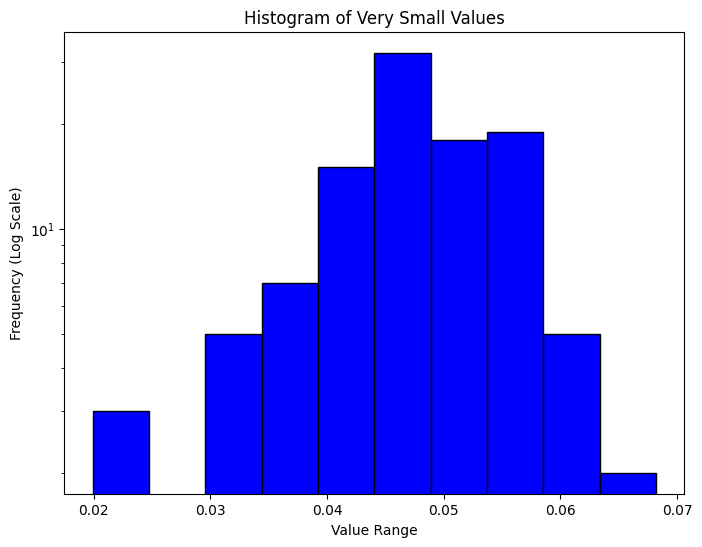

In [231]:
import matplotlib.pyplot as plt
y = np.array(y_pred)
plt.figure(figsize=(8, 6))
plt.hist(y, bins=10, color='blue', edgecolor='black', log=True)

# Adding labels and title
plt.title("Histogram of Very Small Values")
plt.xlabel("Value Range")
plt.ylabel("Frequency (Log Scale)")

# Show the histogram
plt.show()

In [212]:
y_pred  = []
y_true = []
batch = torch.zeros(23, dtype=torch.long)


with torch.no_grad():
    for graph in thors_kamp:
        output = gat(graph.x, graph.edge_index, graph.weight, batch)
        y_pred.append(output.item())
        y_true.append(graph.momentum)


RuntimeError: Expected index [23] to be smaller than self [1] apart from dimension 0 and to be smaller size than src [11]

In [232]:
y_pred  = []
y_true = []
batch = torch.zeros(23, dtype=torch.long)

with torch.no_grad():
    for graph in thors_kamp:
        output = gat(graph.x, graph.edge_index, graph.weight, batch)
        y_pred.append(output.item())
        y_true.append(graph.momentum)

x= list(range(5, 90, 5))
x.remove(45)

import matplotlib.pyplot as plt

ax = plt.axes()        
ax.yaxis.grid() 
plt.plot(x[0:8], y_pred[0:8], linestyle = 'dotted', color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[0:8], y_true[0:8], color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[8:16], y_pred[8:16], linestyle = 'dotted', color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[8:16], y_true[8:16], color = 'cornflowerblue', linewidth = '2.5')
plt.legend(["Prediction", "True"], loc="upper right")
x_ticks = list(range(0, 95, 5))
plt.xticks(ticks=x_ticks,)

plt.savefig('predictions.pdf', bbox_inches='tight')

RuntimeError: Expected index [23] to be smaller than self [1] apart from dimension 0 and to be smaller size than src [11]